## Project Overview: Metadata-Based Classification

This notebook demonstrates a supervised machine learning workflow that classifies instances using only metadata features. It’s designed to test the predictive power of image metadata fields in identifying fradulent images.

Key aspects:
- Conducts exploratory analysis and correlation checks on metadata fields.
- Implements an XGBoost classifier.
- Conducts **feature removal experiments** to assess robustness and redundancy.
- Includes a **leave-one-out strategy** to systematically test the impact of each individual feature on model performance.
- Tracks key metrics: accuracy, precision, recall, F1.

This approach not only benchmarks model accuracy but also provides **insight into which metadata features truly matter**, helping inform both modeling strategy and data collection priorities.

In [2]:
# Import libraries
import boto3
import os
import sagemaker
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import shutil
import copy
import numpy as np
import math
from sagemaker.pytorch import PyTorch, PyTorchModel
from sagemaker import get_execution_role, Session
from sagemaker.inputs import TrainingInput
from sagemaker.xgboost import XGBoost
from sagemaker.s3 import S3Uploader
from sagemaker.image_uris import retrieve
from sagemaker.tuner import HyperparameterTuner, IntegerParameter, ContinuousParameter
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import CSVDeserializer
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from tqdm import tqdm
from random import choice
from itertools import product
from typing import Optional, List
from scipy import stats

/opt/conda/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/conda/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [3]:
# Display all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
# Initialize S3 client
s3 = boto3.client('s3')

# Specify the bucket and files
bucket = 'your-bucket-name'
authentic_file = 'example-project/Classifier/metadata - authentic.json'
tampered_file = 'example-project/Classifier/metadata - tampered.json'

# Load authentic data
authentic_obj = s3.get_object(Bucket=bucket, Key=authentic_file)
df_authentic = pd.read_json(authentic_obj['Body'])

# Load tampered data
tampered_obj = s3.get_object(Bucket=bucket, Key=tampered_file)
df_tampered = pd.read_json(tampered_obj['Body'])

# Label the data: 0 for authentic, 1 for tampered
df_authentic['target'] = 0
df_tampered['target'] = 1

# Combine both DataFrames into one
df = pd.concat([df_authentic, df_tampered])

In [5]:
# Ensure df instantiated correctly
df

ImageName JPEG - Compression Type  \
0                             Au_ani_00001.jpg                Baseline   
1                             Au_ani_00002.jpg                Baseline   
2                             Au_ani_00003.jpg                Baseline   
3                             Au_ani_00004.jpg                Baseline   
4                             Au_ani_00005.jpg                Baseline   
...                                        ...                     ...   
5118  Tp_S_NRN_S_O_cha00077_cha00077_11017.jpg                Baseline   
5119  Tp_S_NRN_S_O_cha10126_cha10126_12153.jpg                Baseline   
5120  Tp_S_NRN_S_O_cha10187_cha10187_12308.jpg                Baseline   
5121  Tp_S_NRN_S_O_nat00032_nat00032_00947.tif                     NaN   
5122  Tp_S_NRN_S_O_sec00036_sec00036_00764.tif                     NaN   

     JPEG - Data Precision JPEG - Image Height JPEG - Image Width  \
0                   8 bits          256 pixels         384 pixels   
1                   8 bits          256 pixels         384 pixels   
2                   8 bits          256 pixels         384 pixels   
3                   8 bits          256 pixels         384 pixels   
4                   8 bits          256 pixels         384 pixels   
...                    ...                 ...                ...   
5118                8 bits          256 pixels         384 pixels   
5119                8 bits          314 pixels         550 pixels   
5120                8 bits          572 pixels         800 pixels   
5121                   NaN                 NaN                NaN   
5122                   NaN                 NaN                NaN   

      JPEG - Number of Components  \
0                             3.0   
1                             3.0   
2                             3.0   
3                             3.0   
4                             3.0   
...                           ...   
5118                          3.0   
5119                          3.0   
5120                          3.0   
5121                          NaN   
5122                          NaN   

                                     JPEG - Component 1  \
0     Y component: Quantization table 0, Sampling fa...   
1     Y component: Quantization table 0, Sampling fa...   
2     Y component: Quantization table 0, Sampling fa...   
3     Y component: Quantization table 0, Sampling fa...   
4     Y component: Quantization table 0, Sampling fa...   
...                                                 ...   
5118  Y component: Quantization table 0, Sampling fa...   
5119  Y component: Quantization table 0, Sampling fa...   
5120  Y component: Quantization table 0, Sampling fa...   
5121                                                NaN   
5122                                                NaN   

                                     JPEG - Component 2  \
0     Cb component: Quantization table 1, Sampling f...   
1     Cb component: Quantization table 1, Sampling f...   
2     Cb component: Quantization table 1, Sampling f...   
3     Cb component: Quantization table 1, Sampling f...   
4     Cb component: Quantization table 1, Sampling f...   
...                                                 ...   
5118  Cb component: Quantization table 1, Sampling f...   
5119  Cb component: Quantization table 1, Sampling f...   
5120  Cb component: Quantization table 1, Sampling f...   
5121                                                NaN   
5122                                                NaN   

                                     JPEG - Component 3  JFIF - Version  ...  \
0     Cr component: Quantization table 1, Sampling f...             1.1  ...   
1     Cr component: Quantization table 1, Sampling f...             1.1  ...   
2     Cr component: Quantization table 1, Sampling f...             1.1  ...   
3     Cr component: Quantization table 1, Sampling f...             1.1  ...   
4     Cr component: Quantization table 1, Sampling f... 

## Exploratory Data Analysis (EDA)

In [29]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12614 entries, 0 to 5122
Data columns (total 677 columns):
 #    Column                                                         Non-Null Count  Dtype  
---   ------                                                         --------------  -----  
 0    ImageName                                                      12614 non-null  object 
 1    JPEG - Compression Type                                        9501 non-null   object 
 2    JPEG - Data Precision                                          9501 non-null   object 
 3    JPEG - Image Height                                            9501 non-null   object 
 4    JPEG - Image Width                                             9501 non-null   object 
 5    JPEG - Number of Components                                    9501 non-null   float64
 6    JPEG - Component 1                                             9501 non-null   object 
 7    JPEG - Component 2                              

In [5]:
# Remove columns where the number of non-null values is 'clearly' too small (<=200)
df_filtered = df.dropna(thresh=201, axis=1)
df_filtered.info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12614 entries, 0 to 5122
Data columns (total 161 columns):
 #    Column                                        Non-Null Count  Dtype  
---   ------                                        --------------  -----  
 0    ImageName                                     12614 non-null  object 
 1    JPEG - Compression Type                       9501 non-null   object 
 2    JPEG - Data Precision                         9501 non-null   object 
 3    JPEG - Image Height                           9501 non-null   object 
 4    JPEG - Image Width                            9501 non-null   object 
 5    JPEG - Number of Components                   9501 non-null   float64
 6    JPEG - Component 1                            9501 non-null   object 
 7    JPEG - Component 2                            9501 non-null   object 
 8    JPEG - Component 3                            9501 non-null   object 
 9    JFIF - Version                                887

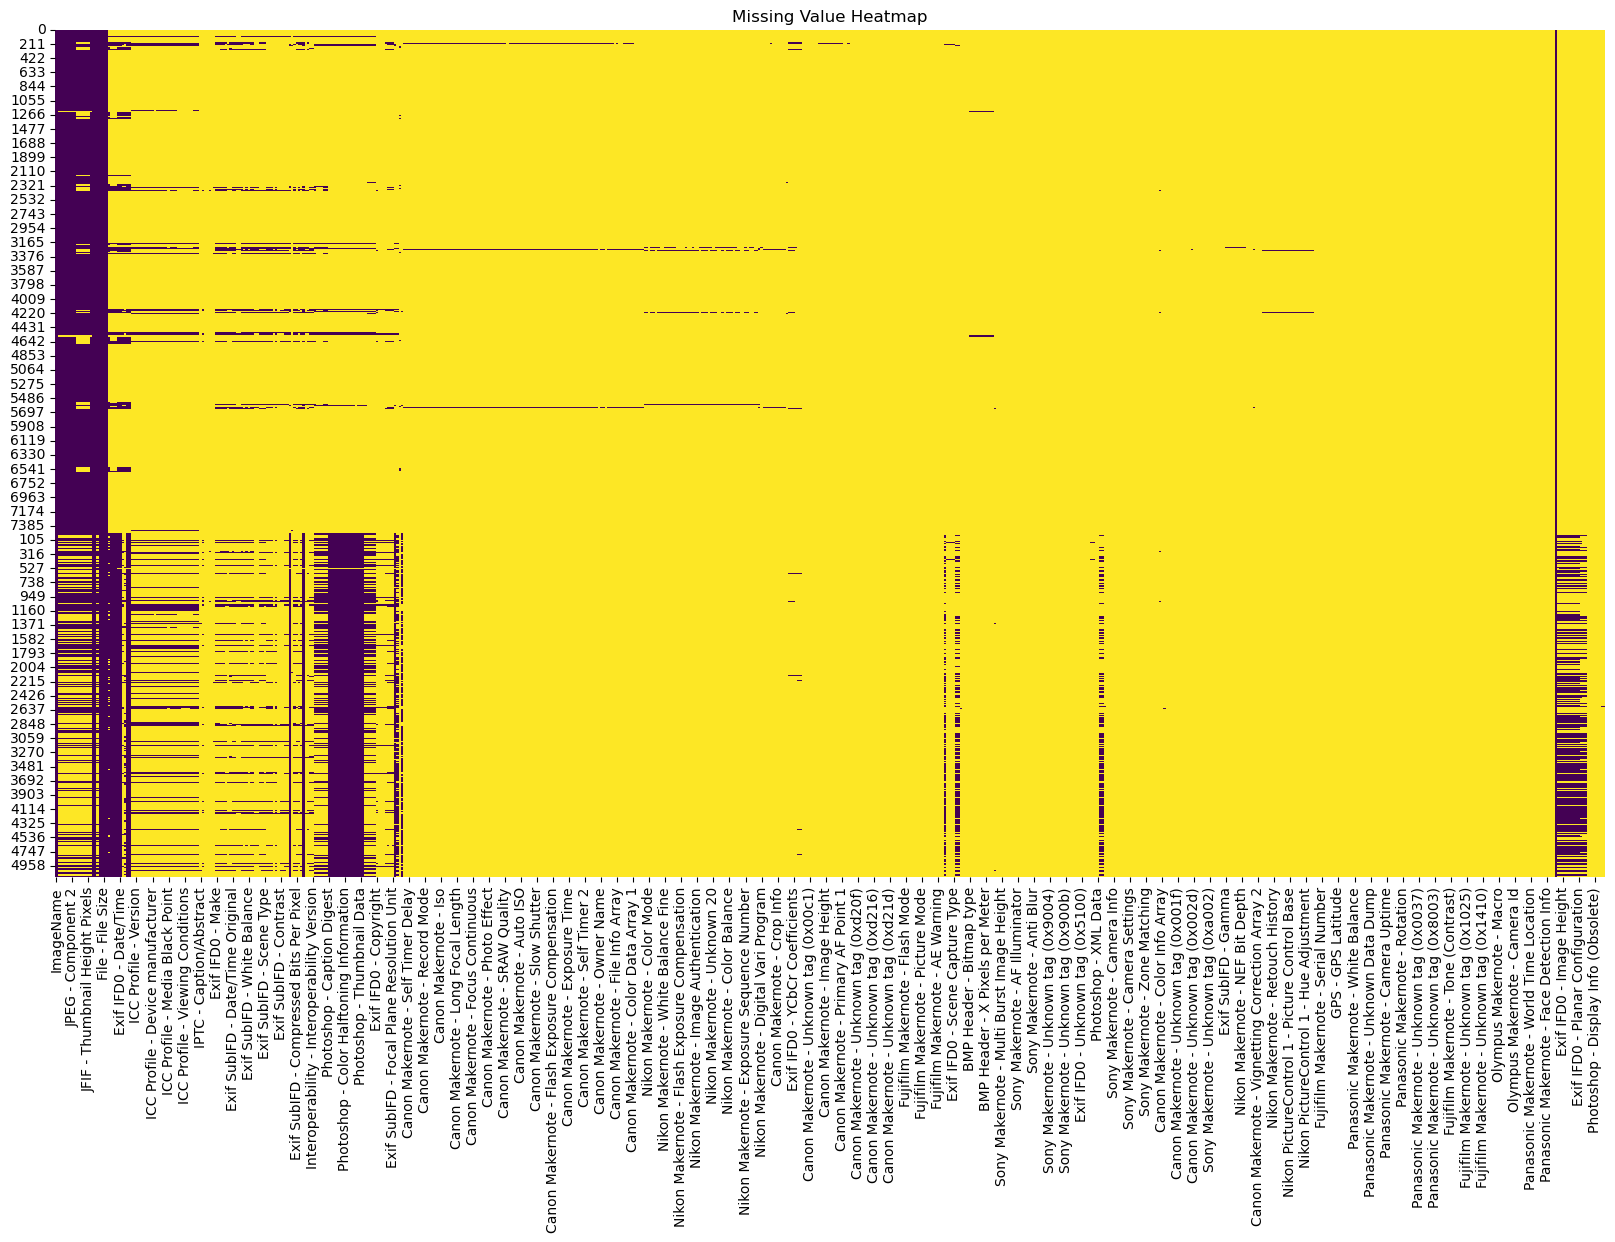

In [6]:
# Generate a heatmap to visualize the missing values in the DataFrame
plt.figure(figsize=(20,11))  # Setting the figure size for better visibility
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Value Heatmap')
plt.show()

In [7]:
# Calculate the percentage of missing values for each column
missing_percentage = (df_filtered.isnull().sum() / len(df)) * 100

In [8]:
missing_percentage

ImageName                                        0.000000
JPEG - Compression Type                         24.678928
JPEG - Data Precision                           24.678928
JPEG - Image Height                             24.678928
JPEG - Image Width                              24.678928
JPEG - Number of Components                     24.678928
JPEG - Component 1                              24.678928
JPEG - Component 2                              24.678928
JPEG - Component 3                              24.678928
JFIF - Version                                  29.625813
JFIF - Resolution Units                         29.625813
JFIF - X Resolution                             29.625813
JFIF - Y Resolution                             29.625813
JFIF - Thumbnail Width Pixels                   29.625813
JFIF - Thumbnail Height Pixels                  29.625813
Huffman - Number of Tables                      24.678928
File Type - Detected File Type Name              0.000000
File Type - De

In [9]:
# Identify columns with more than 75% missing values
columns_to_remove = missing_percentage[missing_percentage > 75].index.tolist()

In [10]:
# Remove those columns
df_filtered.drop(columns=columns_to_remove, inplace=True)

/tmp/ipykernel_18/323152888.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.drop(columns=columns_to_remove, inplace=True)


In [10]:
df_filtered.info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12614 entries, 0 to 5122
Data columns (total 53 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   ImageName                                 12614 non-null  object 
 1   JPEG - Compression Type                   9501 non-null   object 
 2   JPEG - Data Precision                     9501 non-null   object 
 3   JPEG - Image Height                       9501 non-null   object 
 4   JPEG - Image Width                        9501 non-null   object 
 5   JPEG - Number of Components               9501 non-null   float64
 6   JPEG - Component 1                        9501 non-null   object 
 7   JPEG - Component 2                        9501 non-null   object 
 8   JPEG - Component 3                        9501 non-null   object 
 9   JFIF - Version                            8877 non-null   float64
 10  JFIF - Resolution Units            

In [11]:
df_filtered['Photoshop - ICC Untagged Profile'].value_counts()

1.0    4233
Name: Photoshop - ICC Untagged Profile, dtype: int64

In [12]:
df_filtered['Photoshop - Thumbnail Data'].nunique()

4594

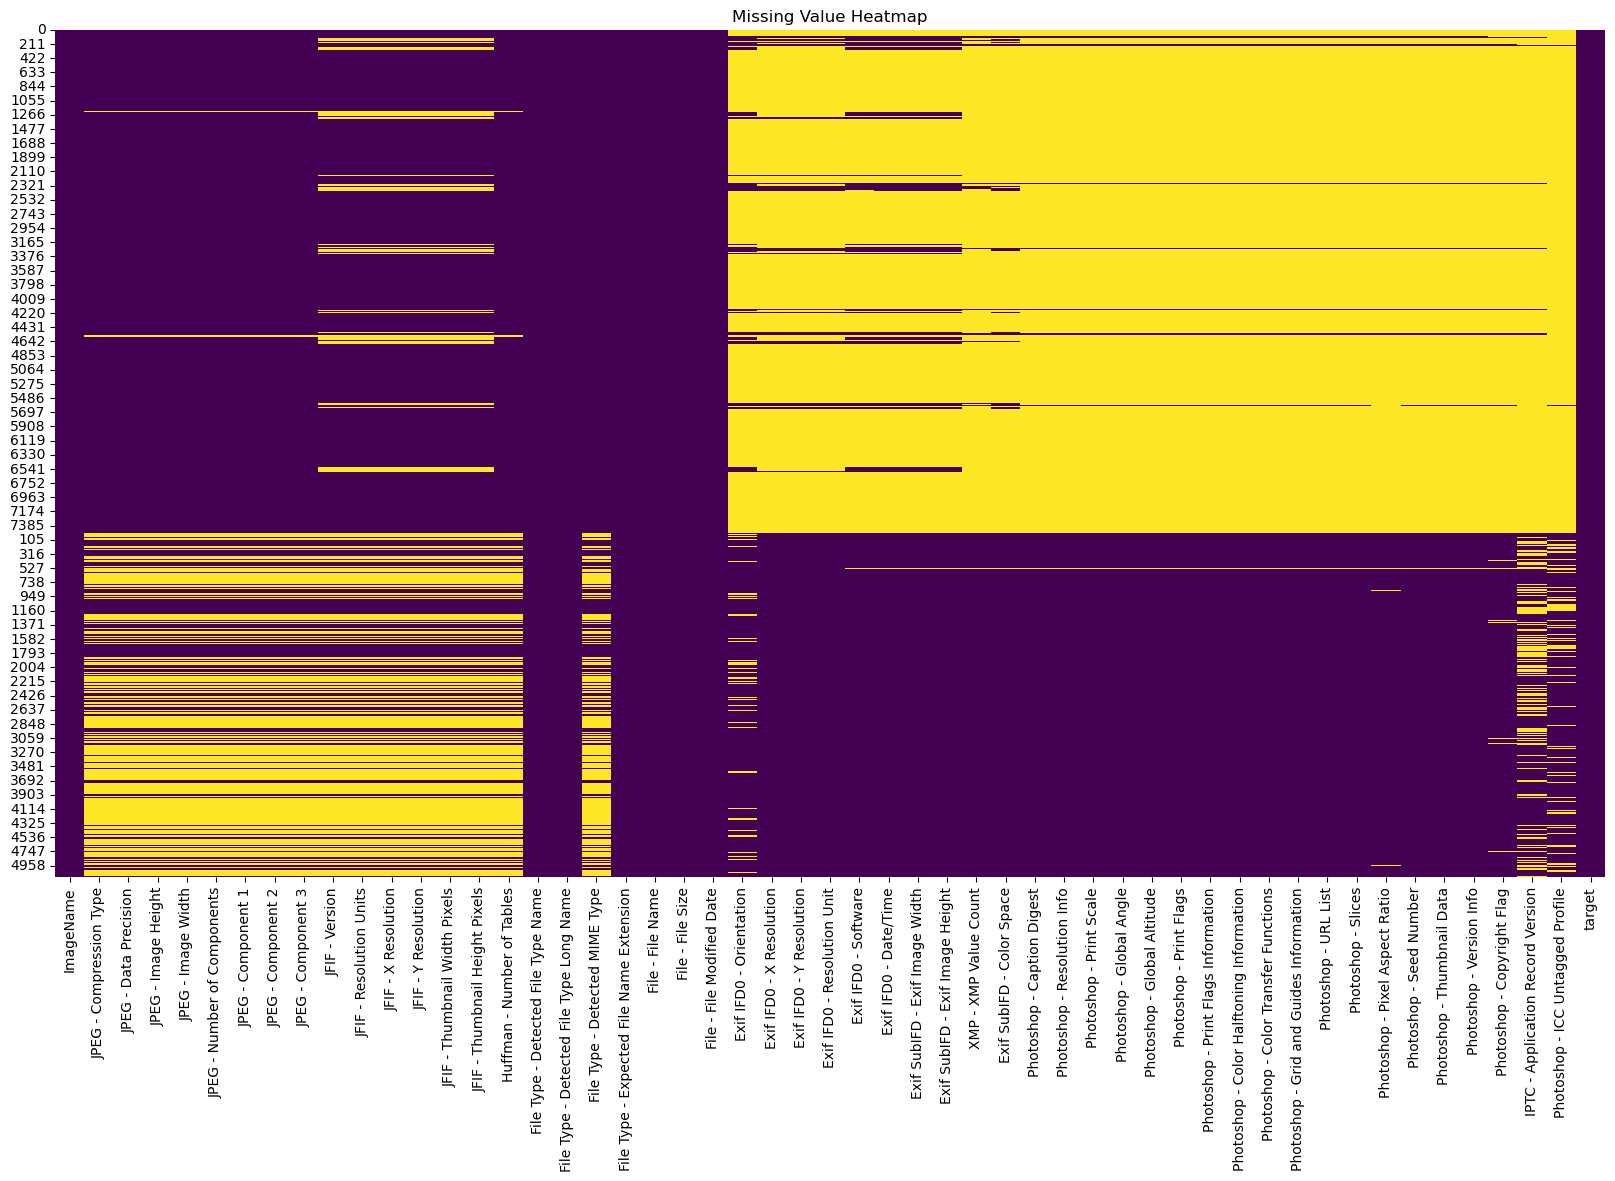

In [13]:
# Generate a heatmap to visualize the missing values in df_filtered
## We're looking for any sign that missing values occure systematically 
plt.figure(figsize=(20,11))  # Setting the figure size for better visibility
sns.heatmap(df_filtered.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Value Heatmap')
plt.show()

In [49]:
df_filtered['JPEG - Compression Type'].value_counts()

Baseline                9493
Progressive, Huffman       8
Name: JPEG - Compression Type, dtype: int64

In [14]:
# Check correctness of data types.
# Change if necessary.

# Function to clean and convert the 'JFIF - X Resolution' column
def convert_str_to_int(series):
    """
    Converts a Pandas Series of string values into integers by removing any non-numeric characters.
    
    Parameters:
    series (pd.Series): A Pandas Series containing the string representations of the numbers.
    
    Returns:
    pd.Series: A new Pandas Series with the cleaned integer values.
    """
    
    def clean_value(value):
        """
        Inner function to clean and convert a single value to an integer.
        
        Parameters:
        value (any): The original value, which can be of any type.
        
        Returns:
        int or None: The cleaned and converted integer value, or None if conversion is not possible.
        """
        if pd.isna(value):
            return np.nan  # Handle NaN values
        elif isinstance(value, str):
            cleaned_value = ''.join(filter(str.isdigit, value))
            return int(cleaned_value) if cleaned_value else None
        elif isinstance(value, (int, float)):
            try:
                return int(value)
            except ValueError:  # Handle any ValueError, including converting NaN to int
                return np.nan
        else:
            return None
    
    return series.apply(clean_value)

In [15]:
def convert_str_to_datetime(series, format_str=None):
    """
    Converts a Pandas Series of string dates into datetime objects.

    Parameters:
    series (pd.Series): A Pandas Series containing the string representations of the dates.
    format_str (str, optional): The date format string to use for parsing.
    
    Returns:
    pd.Series: A new Pandas Series with datetime objects.
    """
    
    def convert_value(value):
        """
        Inner function to convert a single value to a datetime object.
        
        Parameters:
        value (any): The original value, which can be of any type.
        
        Returns:
        pd.Timestamp or None: The converted datetime object, or None if conversion is not possible.
        """
        if pd.isna(value):
            return np.nan
        try:
            if format_str:
                return pd.to_datetime(value, format=format_str, errors='raise')
            else:
                return pd.to_datetime(value, errors='raise')
        except Exception:
            return None
    
    return series.apply(convert_value)

In [16]:
# Apply the cleaning function to the 'JFIF - X Resolution' column
df_filtered['JFIF - X Resolution'] = convert_str_to_int(df_filtered['JFIF - X Resolution'])
df_filtered['JFIF - Y Resolution'] = convert_str_to_int(df_filtered['JFIF - Y Resolution'])
df_filtered['Huffman - Number of Tables'] = convert_str_to_int(df_filtered['Huffman - Number of Tables'])
df_filtered['JPEG - Data Precision'] = convert_str_to_int(df_filtered['JPEG - Data Precision'])
df_filtered['JPEG - Image Height (Pixels)'] = convert_str_to_int(df_filtered['JPEG - Image Height']) # remember to drop original
df_filtered['JPEG - Image Width (Pixels)'] = convert_str_to_int(df_filtered['JPEG - Image Width']) # remember to drop original 
df_filtered['File - File Size (Bytes)'] = convert_str_to_int(df_filtered['File - File Size']) # remember to drop original
df_filtered['File - File Modified Date'] = convert_str_to_datetime(df_filtered['File - File Modified Date']) 
df_filtered['Exif IFD0 - Date/Time'] = convert_str_to_datetime(df_filtered['Exif IFD0 - Date/Time'])
df_filtered['Exif SubIFD - Exif Image Width (Pixels)'] = convert_str_to_int(df_filtered['Exif SubIFD - Exif Image Width']) # remember to drop original 
df_filtered['Exif SubIFD - Exif Image Height (Pixels)'] = convert_str_to_int(df_filtered['Exif SubIFD - Exif Image Height']) # remember to drop original 

/tmp/ipykernel_18/840173026.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['JFIF - X Resolution'] = convert_str_to_int(df_filtered['JFIF - X Resolution'])
/tmp/ipykernel_18/840173026.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['JFIF - Y Resolution'] = convert_str_to_int(df_filtered['JFIF - Y Resolution'])
/tmp/ipykernel_18/840173026.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

/tmp/ipykernel_18/1008310763.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Exif SubIFD - Exif Image Width (Pixels)'] = convert_str_to_int(df_filtered['Exif SubIFD - Exif Image Width']) # remember to drop original
/tmp/ipykernel_18/1008310763.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Exif SubIFD - Exif Image Height (Pixels)'] = convert_str_to_int(df_filtered['Exif SubIFD - Exif Image Height']) # remember to drop original


In [18]:
# Check
df_filtered.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12614 entries, 0 to 5122
Data columns (total 58 columns):
 #   Column                                    Non-Null Count  Dtype                               
---  ------                                    --------------  -----                               
 0   ImageName                                 12614 non-null  object                              
 1   JPEG - Compression Type                   9501 non-null   object                              
 2   JPEG - Data Precision                     9501 non-null   float64                             
 3   JPEG - Image Height                       9501 non-null   object                              
 4   JPEG - Image Width                        9501 non-null   object                              
 5   JPEG - Number of Components               9501 non-null   float64                             
 6   JPEG - Component 1                        9501 non-null   object                       

In [18]:
# Create indicator and interaction variables before dropping variables on which they depend
# Indicator variables indicate the presence or absence of specific metadata fields

# Indicator for EXIF Data
df_filtered['has_EXIF_data'] = df_filtered.filter(like='Exif').notna().any(axis=1).astype(int)

# Indicator for Photoshop Data
df_filtered['has_Photoshop_data'] = df_filtered.filter(like='Photoshop').notna().any(axis=1).astype(int)

# Indicator for JPEG Data
df_filtered['has_JPEG_data'] = df_filtered.filter(like='JPEG').notna().any(axis=1).astype(int)

# Indicator for JFIF Data
df_filtered['has_JFIF_data'] = df_filtered.filter(like='JFIF').notna().any(axis=1).astype(int)

# Indicator for XMP Data
df_filtered['has_XMP_data'] = df_filtered['XMP - XMP Value Count'].notna().astype(int)

# Creating Interaction Terms
# Interaction between EXIF and Photoshop Data
df_filtered['EXIF_Photoshop_interaction'] = df_filtered['has_EXIF_data'] * df_filtered['has_Photoshop_data']

# Interaction between JPEG and JFIF Data
df_filtered['JPEG_JFIF_interaction'] = df_filtered['has_JPEG_data'] * df_filtered['has_JFIF_data']

# Interaction between EXIF and XMP Data
df_filtered['EXIF_XMP_interaction'] = df_filtered['has_EXIF_data'] * df_filtered['has_XMP_data']

# Interaction between Photoshop and XMP Data
df_filtered['Photoshop_XMP_interaction'] = df_filtered['has_Photoshop_data'] * df_filtered['has_XMP_data']

# Displaying the first few rows to verify
df_filtered[['has_EXIF_data', 'has_Photoshop_data', 'has_JPEG_data', 'has_JFIF_data', 'has_XMP_data',
             'EXIF_Photoshop_interaction', 'JPEG_JFIF_interaction', 'EXIF_XMP_interaction', 
             'Photoshop_XMP_interaction']].head()

/tmp/ipykernel_18/1376234067.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['has_EXIF_data'] = df_filtered.filter(like='Exif').notna().any(axis=1).astype(int)
/tmp/ipykernel_18/1376234067.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['has_Photoshop_data'] = df_filtered.filter(like='Photoshop').notna().any(axis=1).astype(int)
/tmp/ipykernel_18/1376234067.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

has_EXIF_data  has_Photoshop_data  has_JPEG_data  has_JFIF_data  \
0              0                   0              1              1   
1              0                   0              1              1   
2              0                   0              1              1   
3              0                   0              1              1   
4              0                   0              1              1   

   has_XMP_data  EXIF_Photoshop_interaction  JPEG_JFIF_interaction  \
0             0                           0                      1   
1             0                           0                      1   
2             0                           0                      1   
3             0                           0                      1   
4             0                           0                      1   

   EXIF_XMP_interaction  Photoshop_XMP_interaction  
0                     0                          0  
1                     0                          0  
2                     0                          0  
3                     0                          0  
4                     0                          0

In [20]:
# Check
df_filtered.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12614 entries, 0 to 5122
Data columns (total 67 columns):
 #   Column                                    Non-Null Count  Dtype                               
---  ------                                    --------------  -----                               
 0   ImageName                                 12614 non-null  object                              
 1   JPEG - Compression Type                   9501 non-null   object                              
 2   JPEG - Data Precision                     9501 non-null   float64                             
 3   JPEG - Image Height                       9501 non-null   object                              
 4   JPEG - Image Width                        9501 non-null   object                              
 5   JPEG - Number of Components               9501 non-null   float64                             
 6   JPEG - Component 1                        9501 non-null   object                       

In [51]:
df_filtered['Exif IFD0 - X Resolution'].value_counts()

4.0    9493
5.0       8
Name: Huffman - Number of Tables, dtype: int64

In [19]:
# Chi-Square Test for Independence
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(df_filtered['File Type - Detected MIME Type'], df_filtered['File Type - Detected File Type Name'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Interpret the result
if p < 0.05:
    print(f"The variables are associated (p-value: {p})")
else:
    print(f"The variables are not associated (p-value: {p})")
    
# Are associated. So, drop 'File Type - Detected MIME Type'

The variables are associated (p-value: 0.0)


In [22]:
contingency_table

File Type - Detected File Type Name  BMP  JPEG  TIFF
File Type - Detected MIME Type                      
image/bmp                             54     0     0
image/jpeg                             0  9501     0
image/tiff                             0     0     8

In [54]:
df_filtered[['File Type - Detected MIME Type', 'File Type - Detected File Type Name']].corr().head()

Empty DataFrame
Columns: []
Index: []

In [20]:
# Drop columns: both those 'original' columns specified above and those determined by analysis
df_dropped = df_filtered.drop([
    'JPEG - Image Height', 'JPEG - Image Width', 'File - File Size', 'Exif SubIFD - Exif Image Width', 'Exif SubIFD - Exif Image Height', 'JFIF - Thumbnail Width Pixels', 'JFIF - Thumbnail Height Pixels',
    'Photoshop - Global Altitude', 'Photoshop - Pixel Aspect Ratio', 'Photoshop - ICC Untagged Profile', 'Photoshop - Print Scale', 'Photoshop - Print Flags', 'Photoshop - Print Flags Information', 
    'Photoshop - Color Halftoning Information', 'Photoshop - Color Transfer Functions',  'Photoshop - Grid and Guides Information', 'Photoshop - Pixel Aspect Ratio', 'Photoshop - Copyright Flag', 
    'Photoshop - URL List', 'Photoshop - Global Angle', 'JPEG - Compression Type', 'JPEG - Number of Components', 'JFIF - Resolution Units', 'Huffman - Number of Tables', 'File Type - Detected File Type Long Name',
    'File Type - Expected File Name Extension', 'File - File Name', 'File Type - Detected MIME Type'
    ], axis=1)

In [21]:
df_dropped.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12614 entries, 0 to 5122
Data columns (total 40 columns):
 #   Column                                    Non-Null Count  Dtype                               
---  ------                                    --------------  -----                               
 0   ImageName                                 12614 non-null  object                              
 1   JPEG - Data Precision                     9501 non-null   float64                             
 2   JPEG - Component 1                        9501 non-null   object                              
 3   JPEG - Component 2                        9501 non-null   object                              
 4   JPEG - Component 3                        9501 non-null   object                              
 5   JFIF - Version                            8877 non-null   float64                             
 6   JFIF - X Resolution                       8877 non-null   float64                      

### Compare train, validation and test sets

In [26]:
# Mild class imbalance (60/40). So, 70/15/15 split
# First, let's split the data into training and temporary sets
train, temp = train_test_split(df_dropped, test_size=0.3, stratify=df_dropped['target'], random_state=42)

# Now, let's split the temporary set into validation and test sets
validation, test = train_test_split(temp, test_size=0.5, stratify=temp['target'], random_state=42)

# Checking the class distribution in each set
print("Training set class distribution:")
print(train['target'].value_counts(normalize=True))
print("\nValidation set class distribution:")
print(validation['target'].value_counts(normalize=True))
print("\nTest set class distribution:")
print(test['target'].value_counts(normalize=True))

Training set class distribution:
0    0.593838
1    0.406162
Name: target, dtype: float64

Validation set class distribution:
0    0.59408
1    0.40592
Name: target, dtype: float64

Test set class distribution:
0    0.593767
1    0.406233
Name: target, dtype: float64


In [22]:
def compare_all_distributions(
        train: pd.DataFrame,
        validation: pd.DataFrame,
        test: pd.DataFrame,
        features: Optional[List[str]] = None,
        kde: Optional[bool] = True,
        element: Optional[str] = 'step',
        stat: Optional[str] = 'density',
        common_norm: Optional[bool] = False
) -> None:
    """
    Compare the distribution of all features (numerical or categorical) across training, validation, and test sets.

    Parameters:
    - train (pd.DataFrame): The training dataset.
    - validation (pd.DataFrame): The validation dataset.
    - test (pd.DataFrame): The test dataset.
    - features (Optional[List[str]]): List of features to plot (default is all features).
    - kde (Optional[bool]): Whether to plot a Kernel Density Estimate (default is True).
    - element (Optional[str]): Style of the histogram (default is 'step').
    - stat (Optional[str]): The type of normalization for the histogram (default is 'density').
    - common_norm (Optional[bool]): Whether to normalize all datasets to a common density (default is False).

    Returns:
    - None
    """

    if features is None:
        features = train.columns.tolist()

    for feature in features:
        plt.figure(figsize=(10, 6))

        if pd.api.types.is_numeric_dtype(train[feature]):
            for dataset, label in zip([train, validation, test], ['Train', 'Validation', 'Test']):
                sns.histplot(
                    dataset[feature],
                    kde=kde,
                    element=element,
                    stat=stat,
                    common_norm=common_norm,
                    label=label
                )
            plt.ylabel('Density' if stat == 'density' else 'Count')
        else:
            concatenated_data = pd.concat([train, validation, test], keys=['Train', 'Validation', 'Test']).reset_index(level=0)
            sns.countplot(x=feature, hue='level_0', data=concatenated_data)
            plt.ylabel('Count')

        plt.xlabel(feature)
        plt.title(f'Distribution of {feature} across Data Splits')
        plt.legend()
        plt.show()

/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


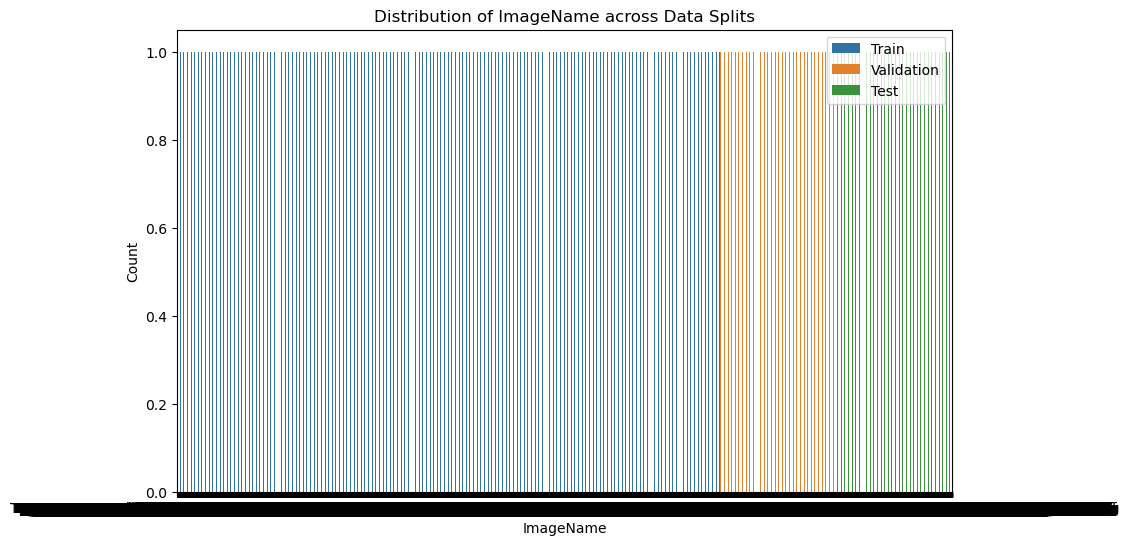

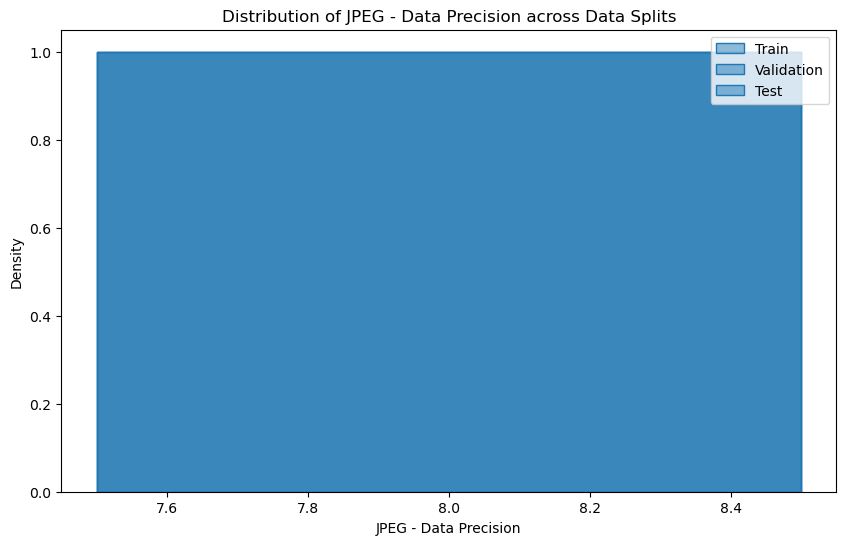

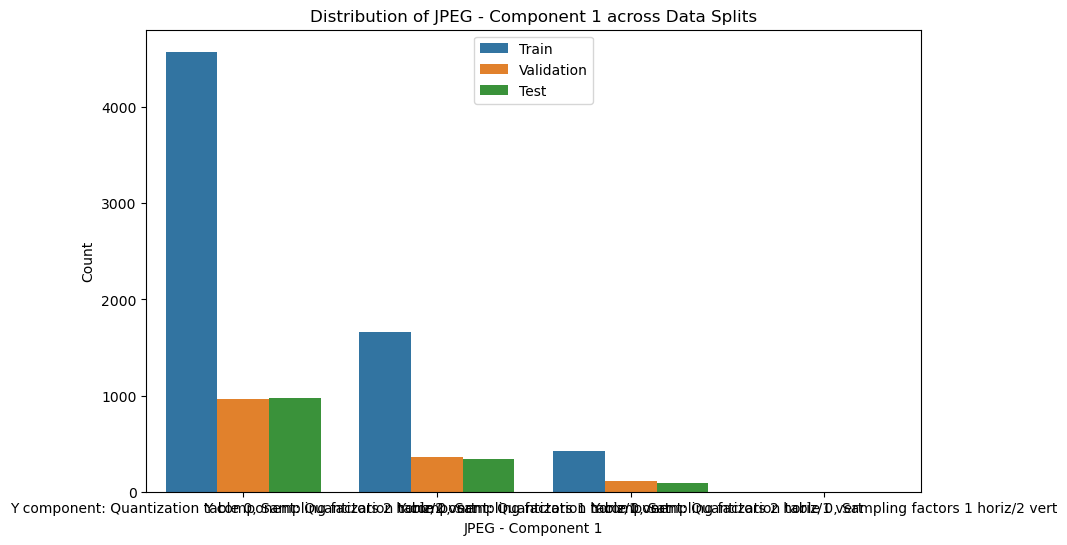

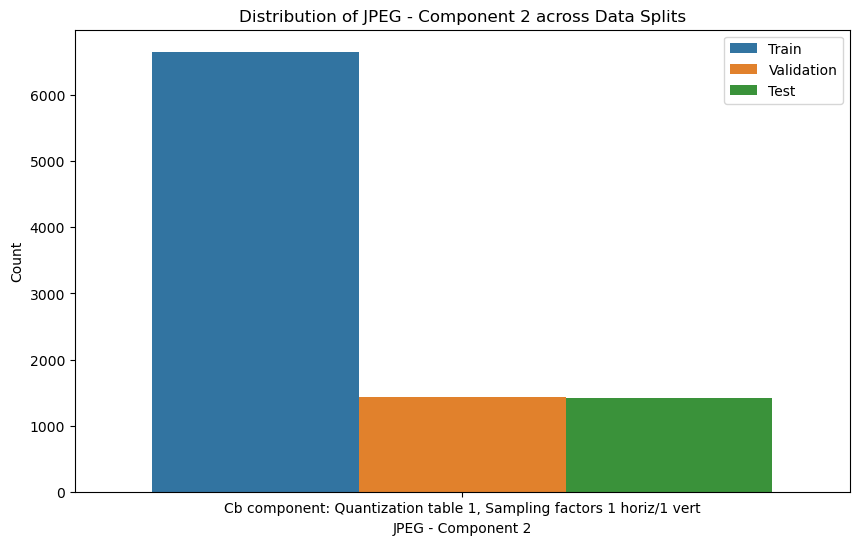

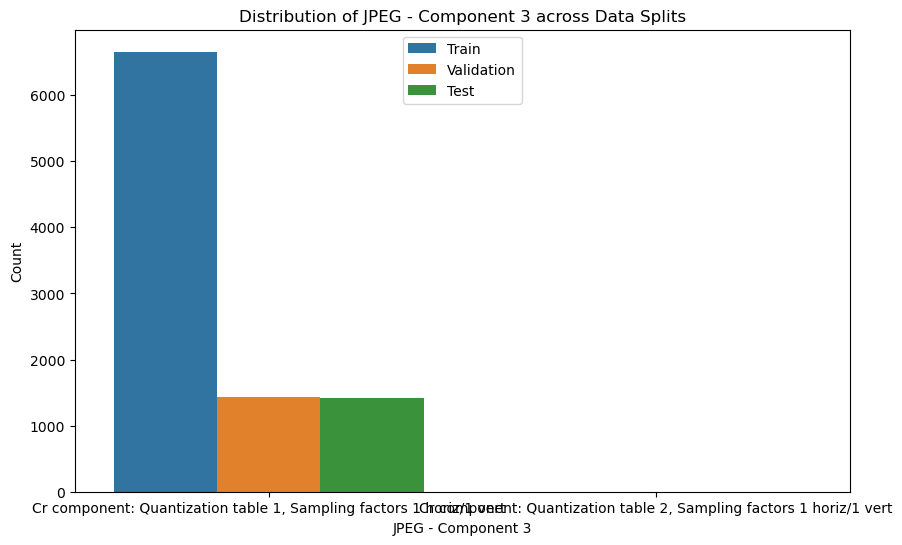

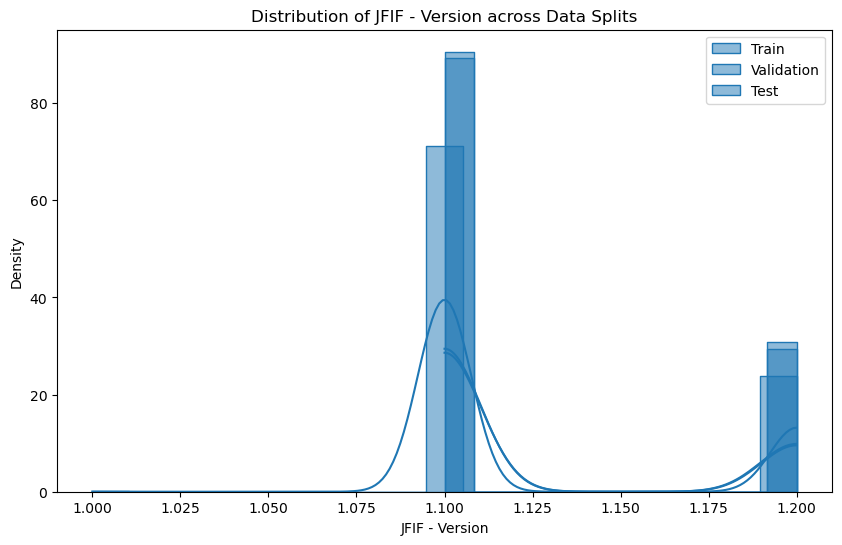

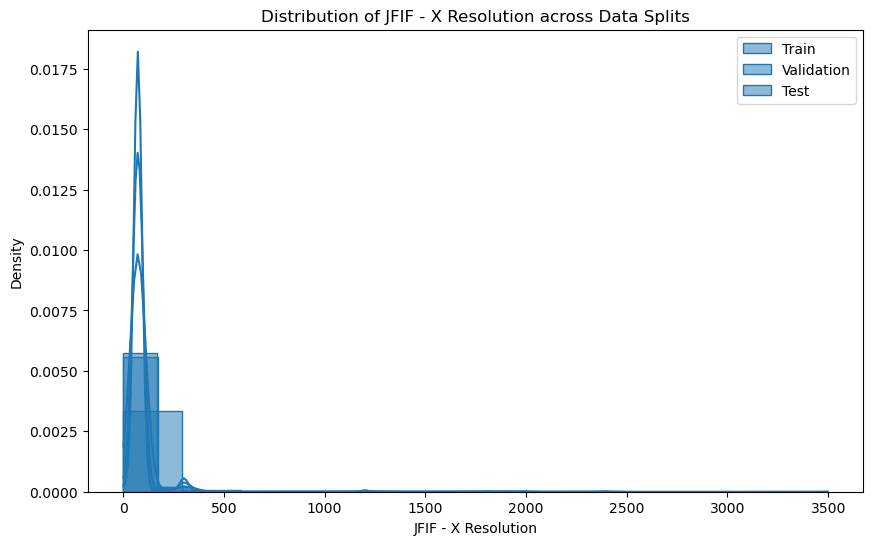

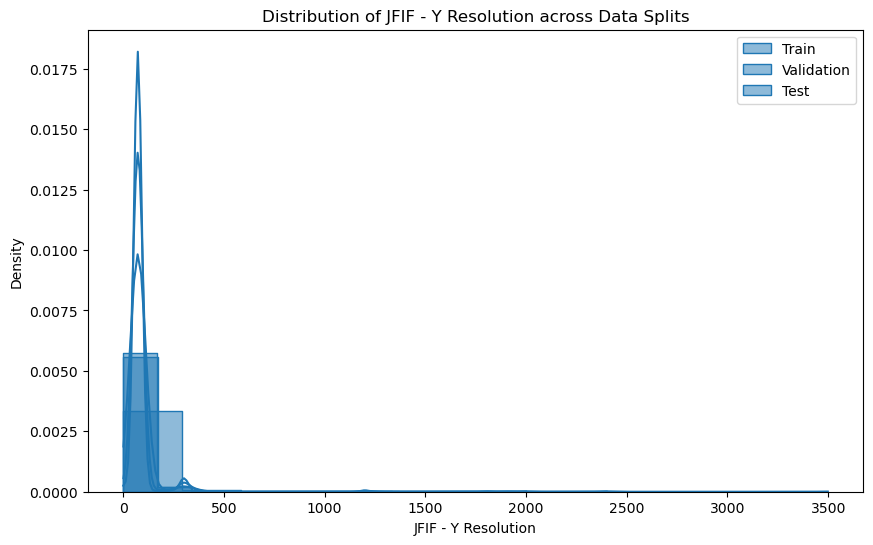

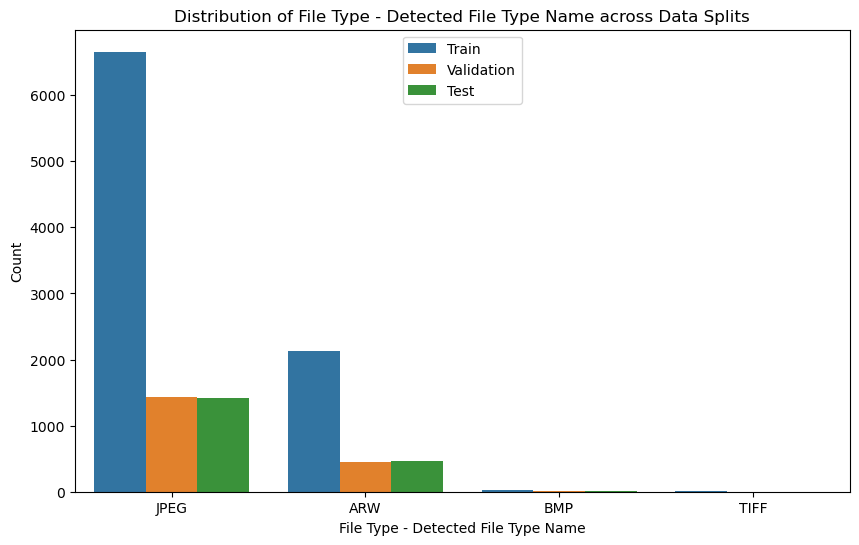

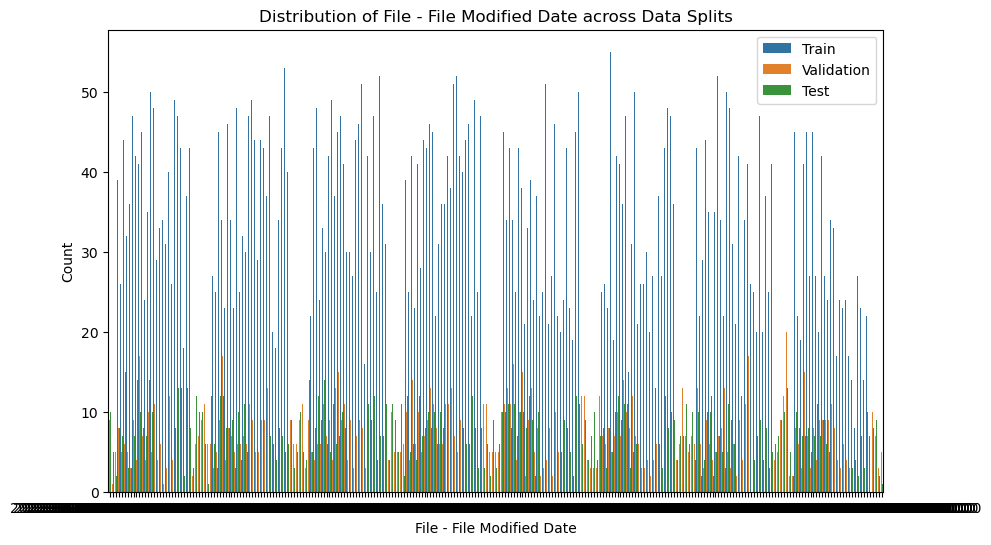

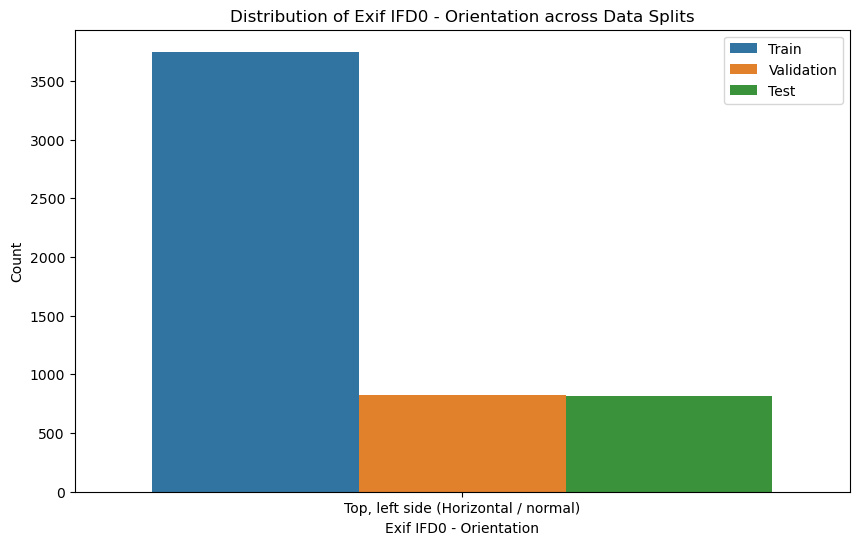

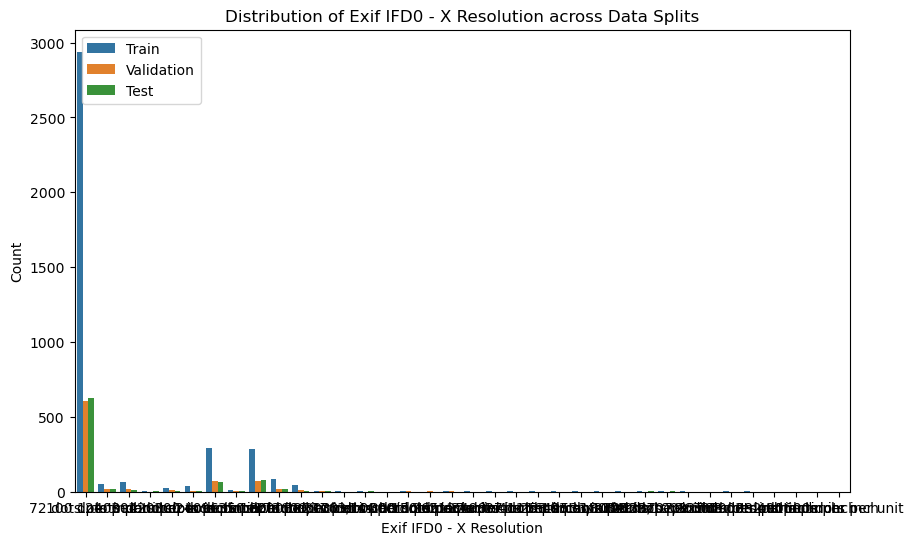

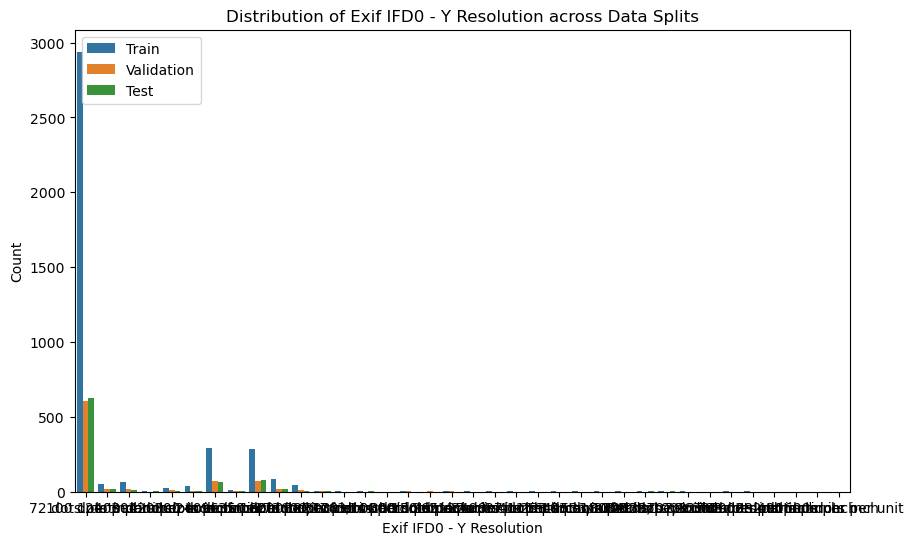

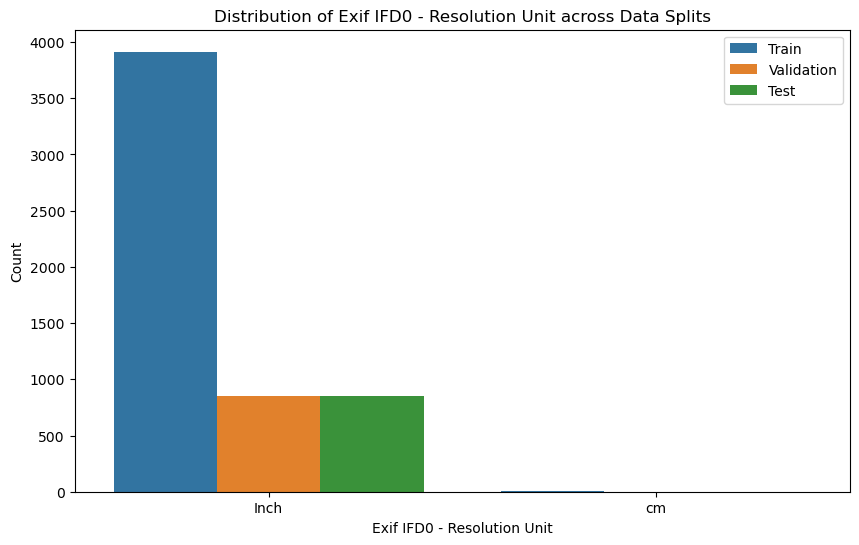

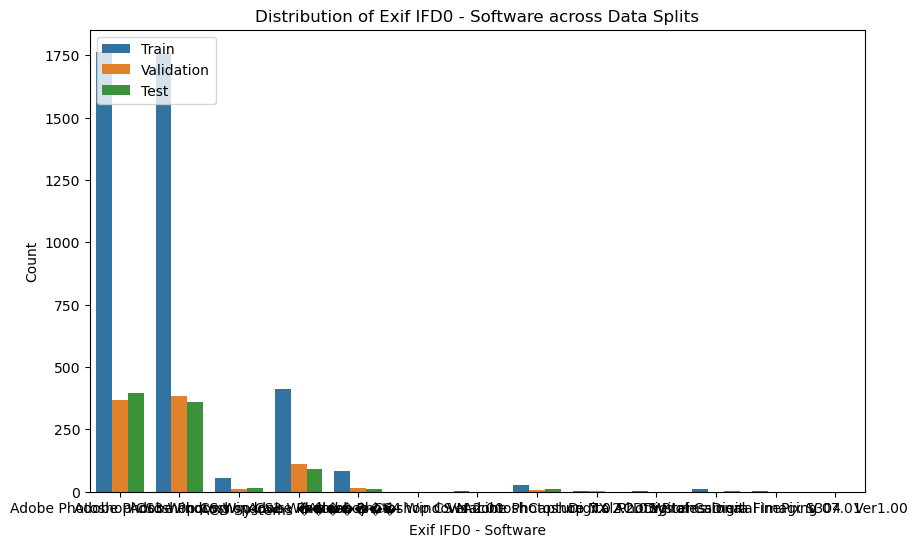

/opt/conda/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/opt/conda/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/opt/conda/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


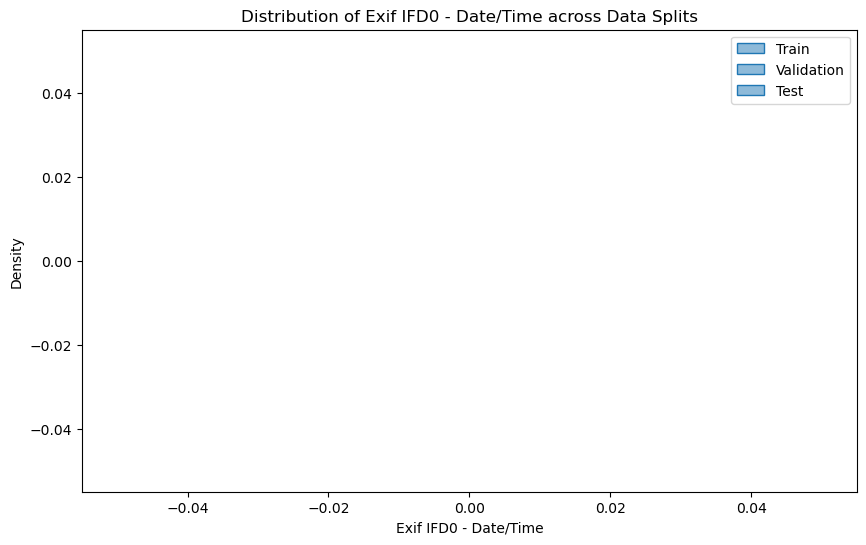

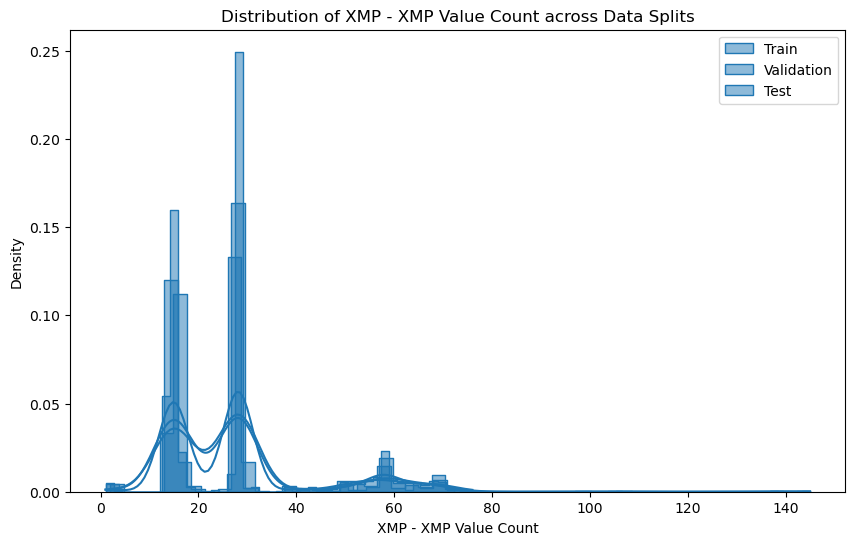

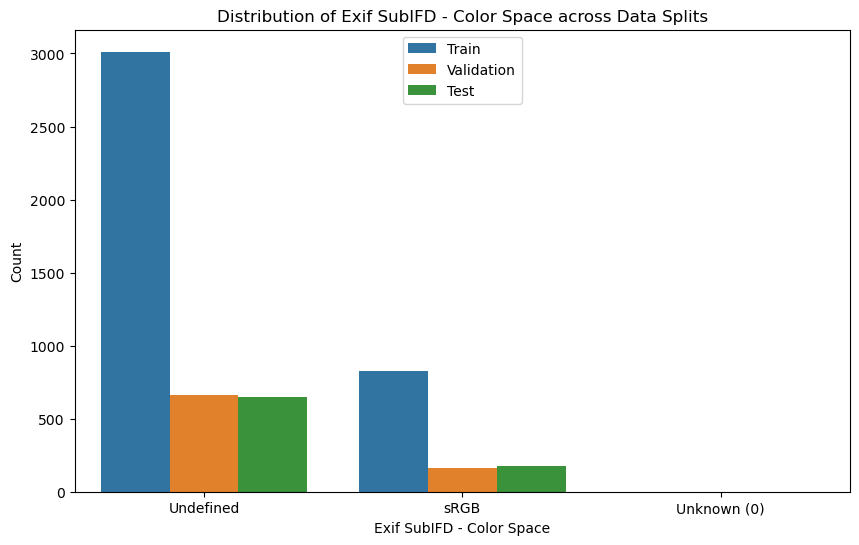

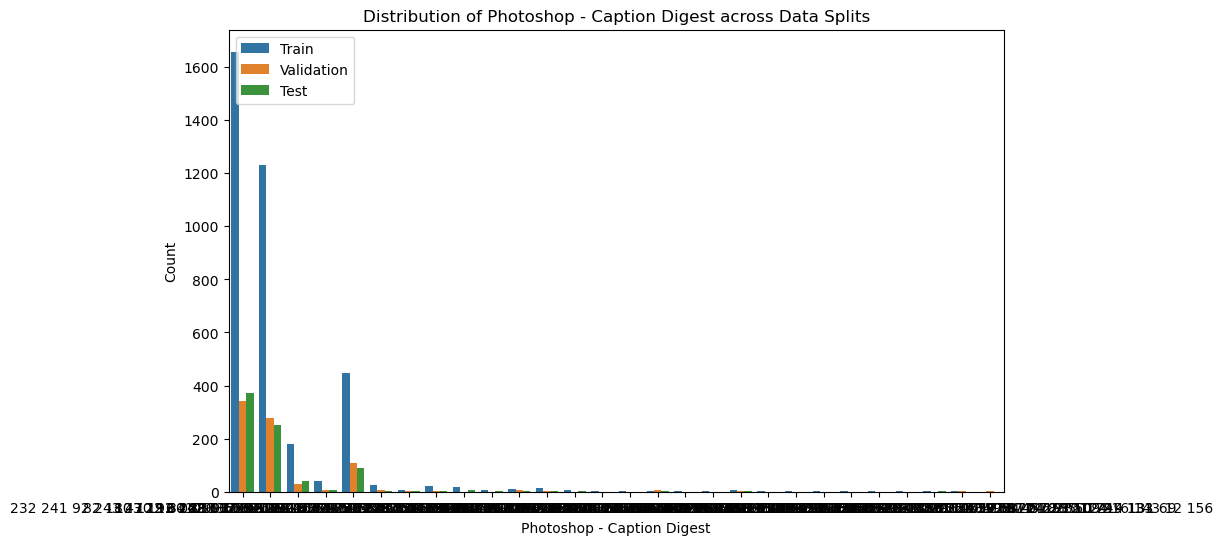

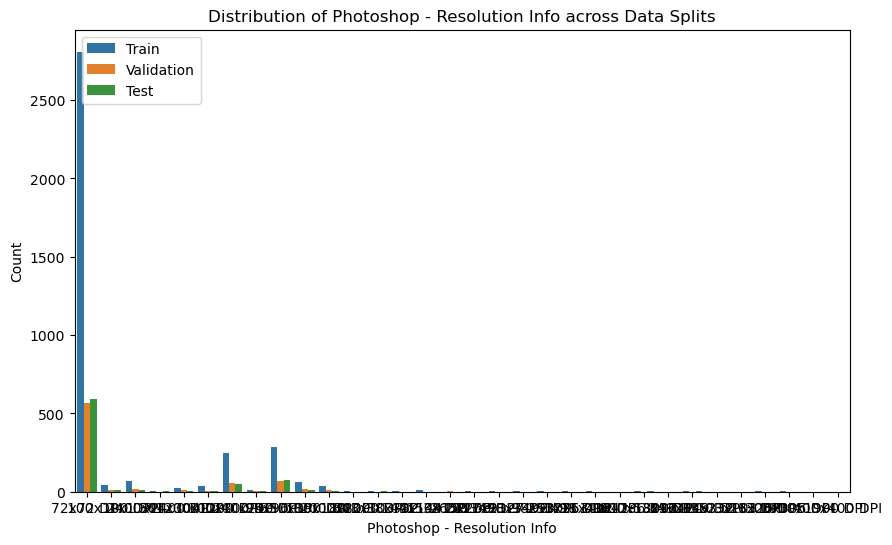

/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27792 (\N{CJK UNIFIED IDEOGRAPH-6C90}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 28020 (\N{CJK UNIFIED IDEOGRAPH-6D74}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38451 (\N{CJK UNIFIED IDEOGRAPH-9633}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20809 (\N{CJK UNIFIED IDEOGRAPH-5149}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26410 (\N{CJK UNIFIED IDEOGRAPH-672A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/

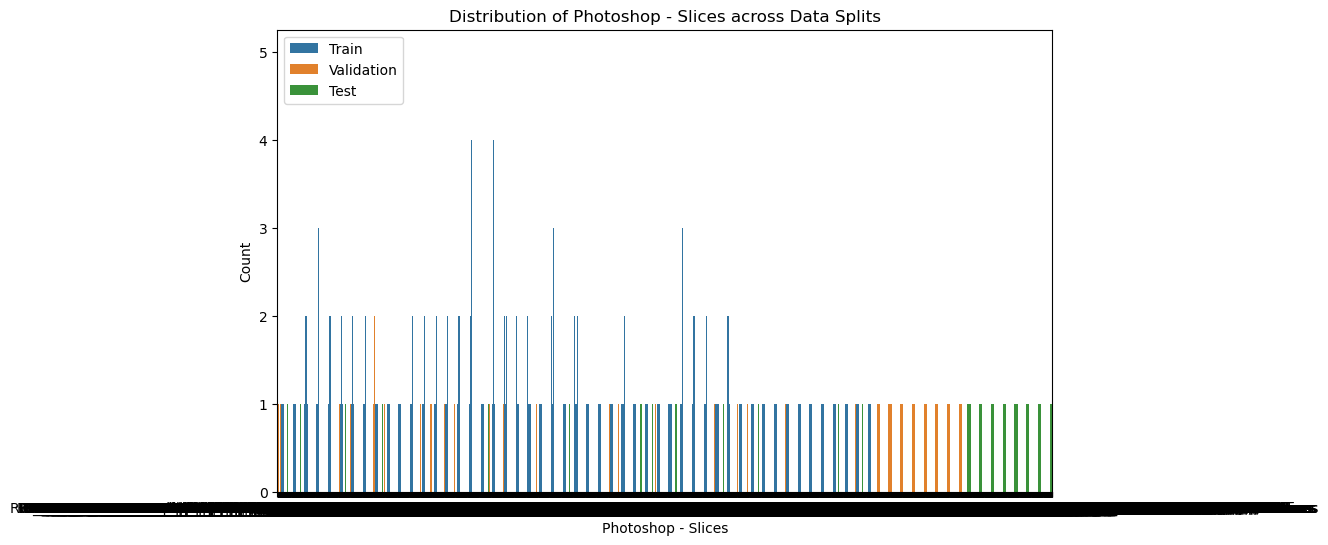

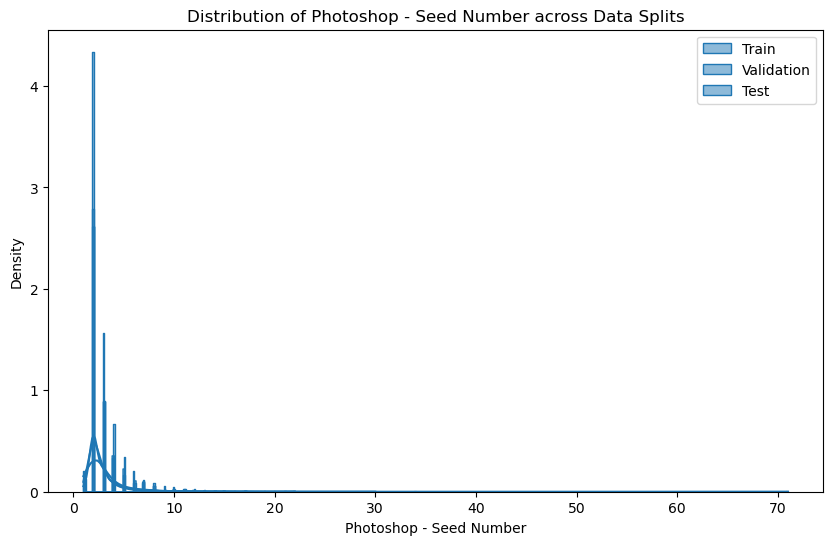

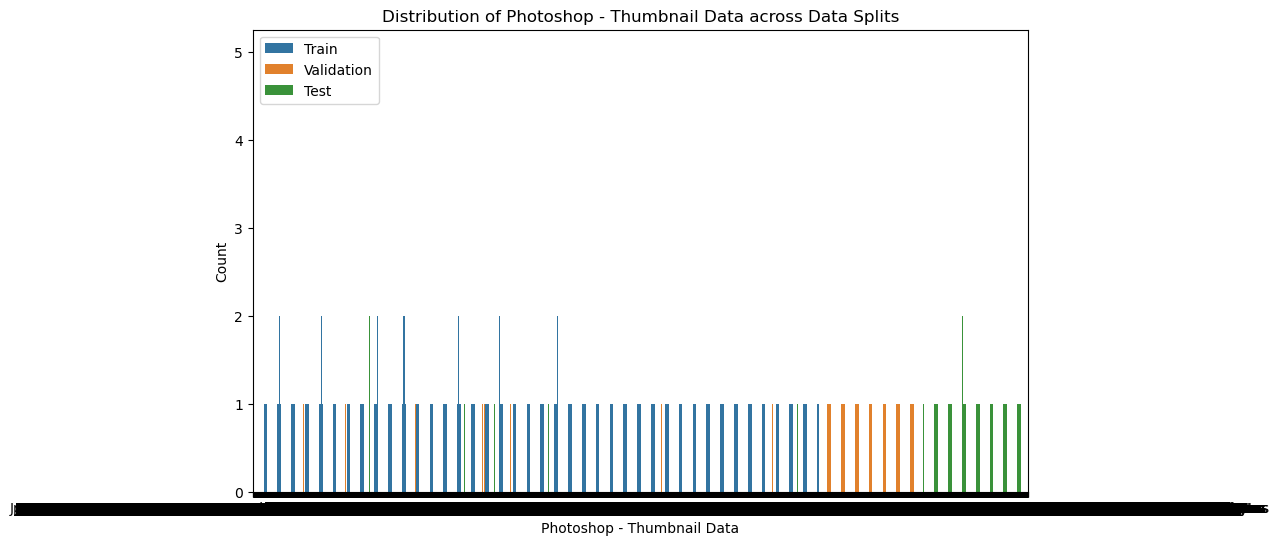

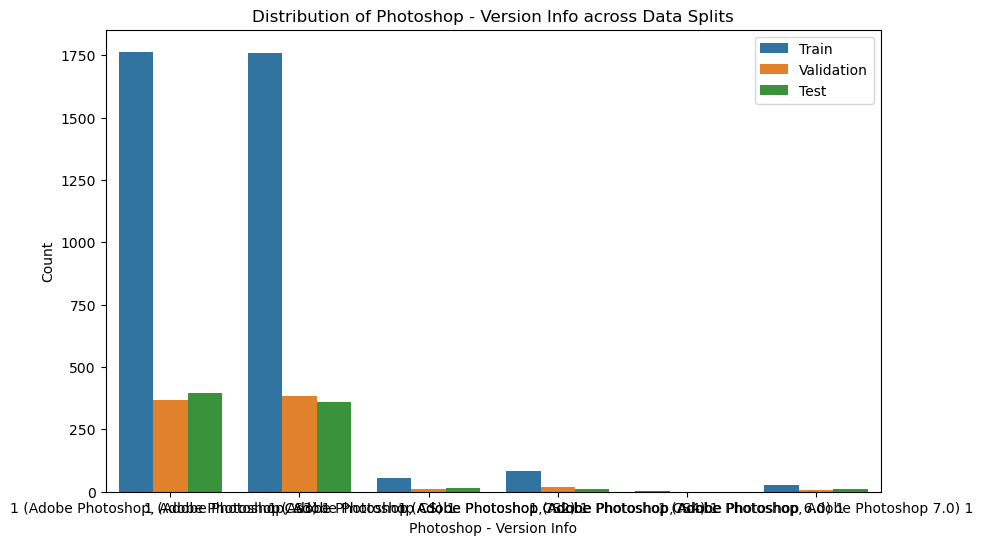

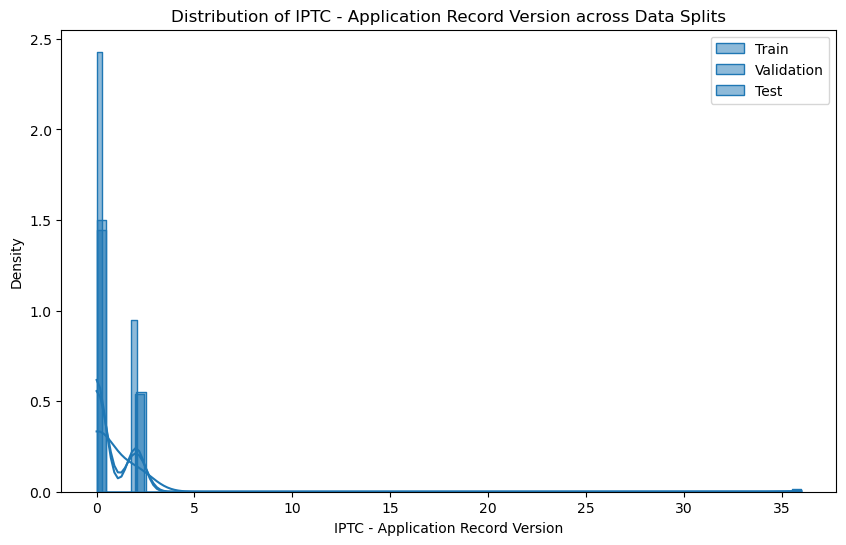

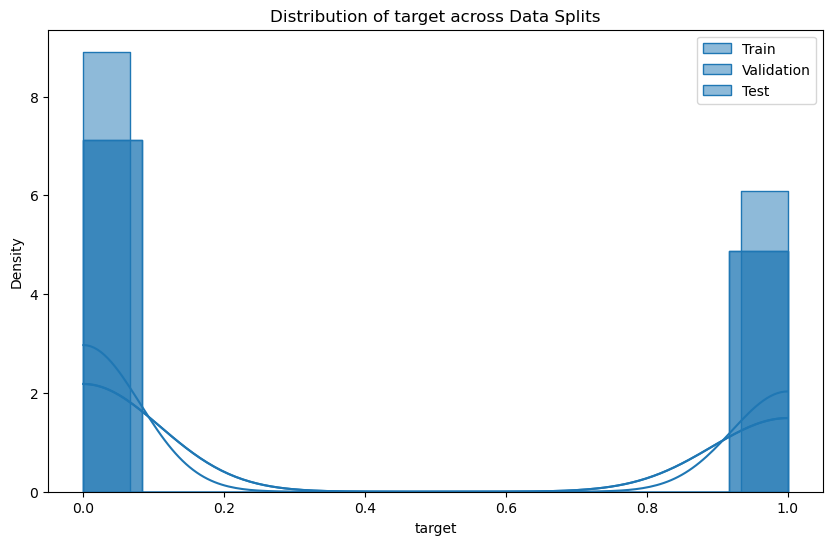

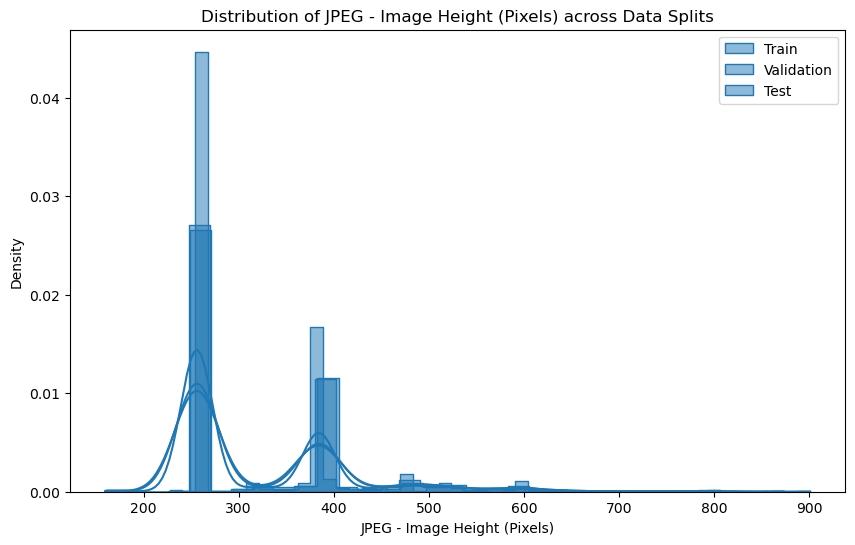

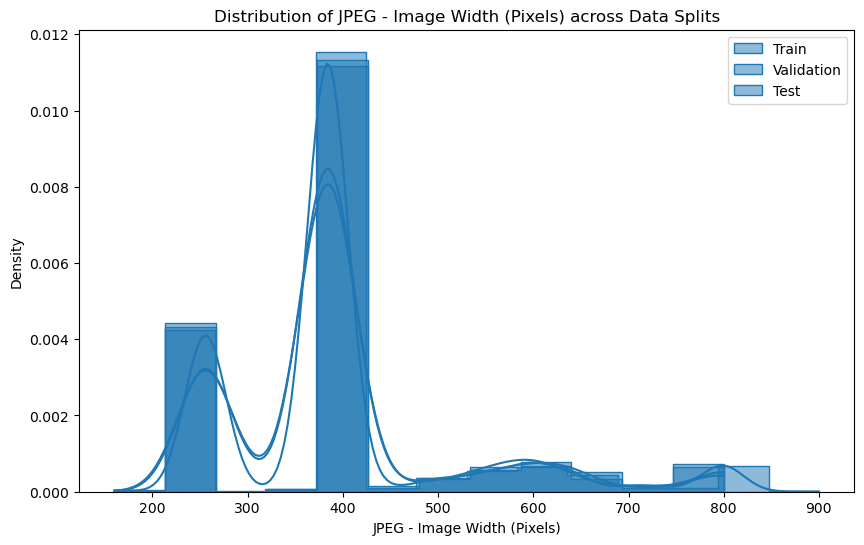

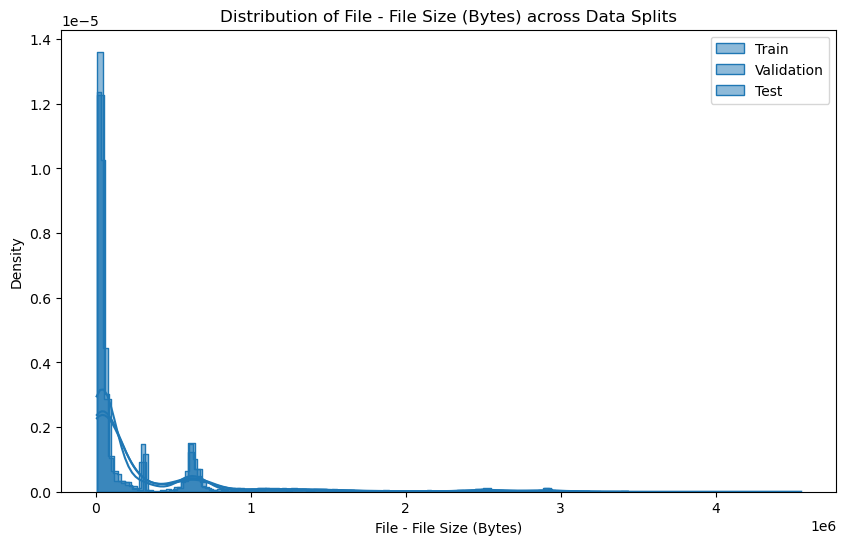

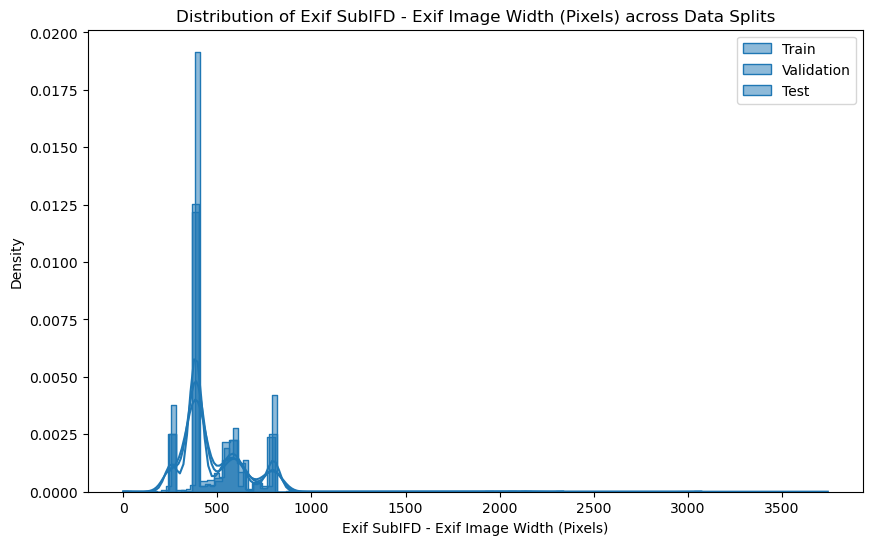

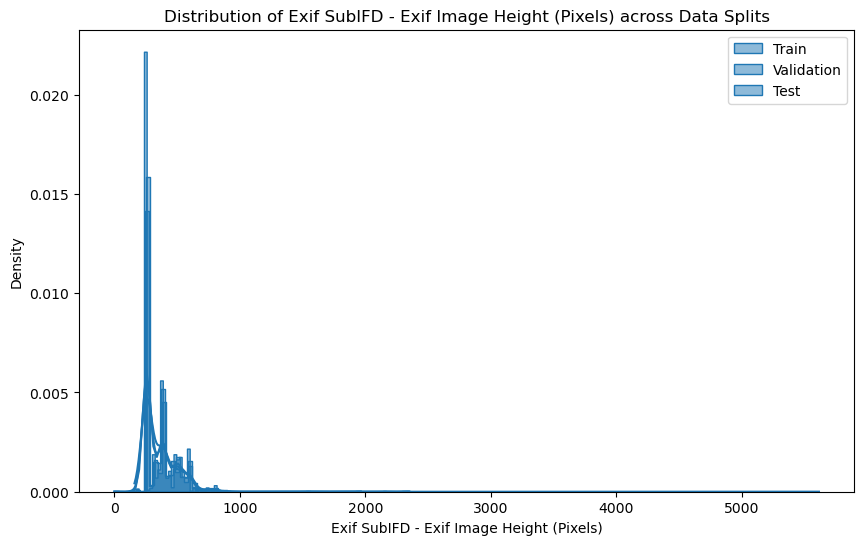

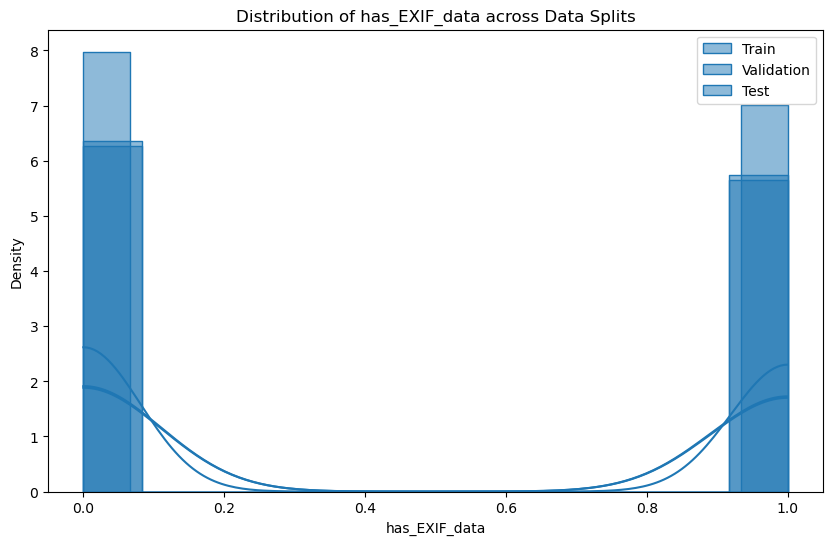

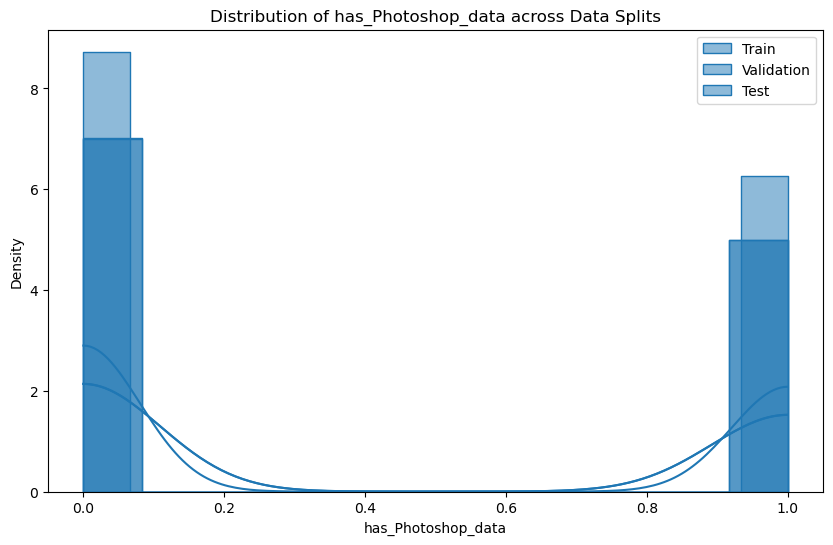

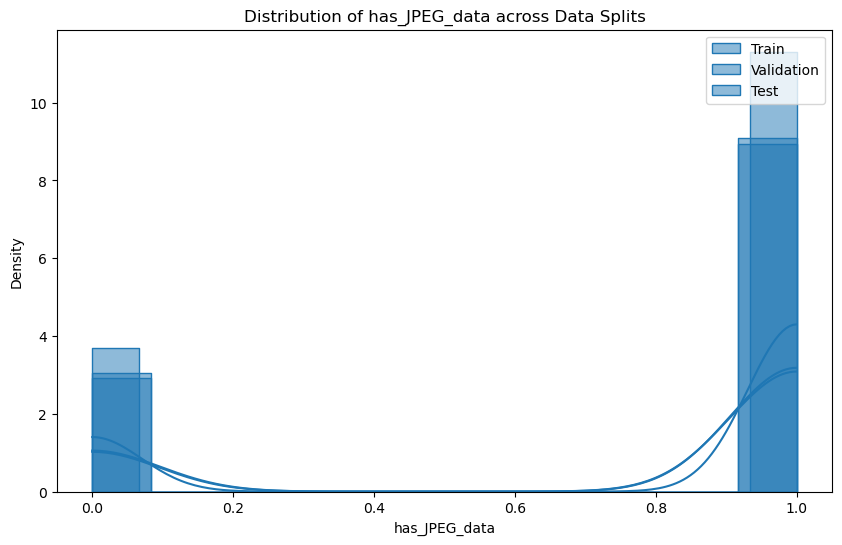

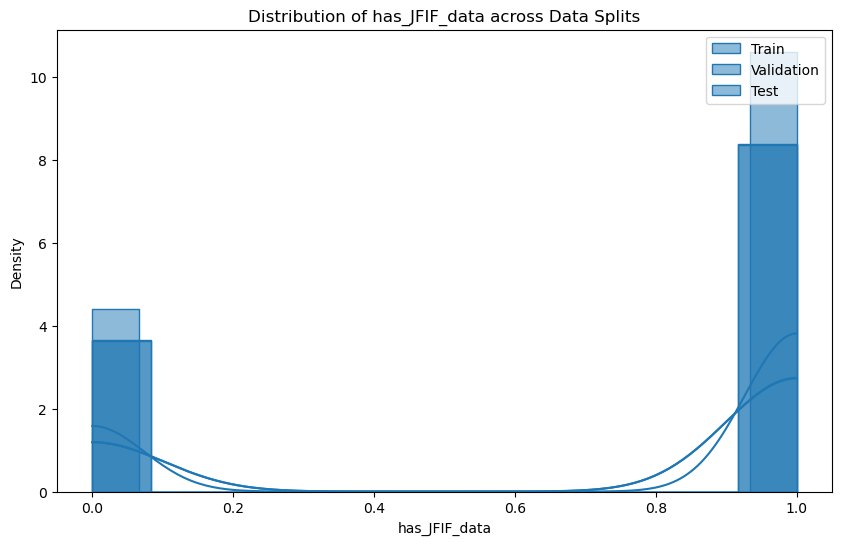

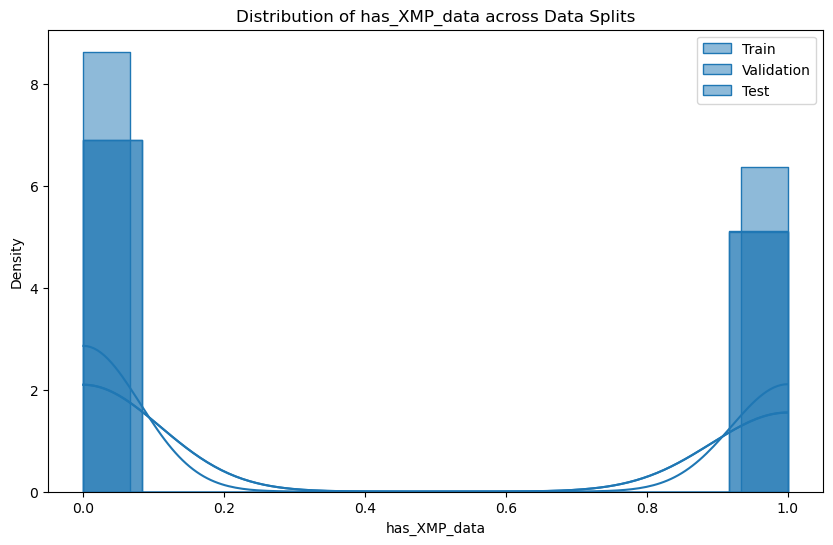

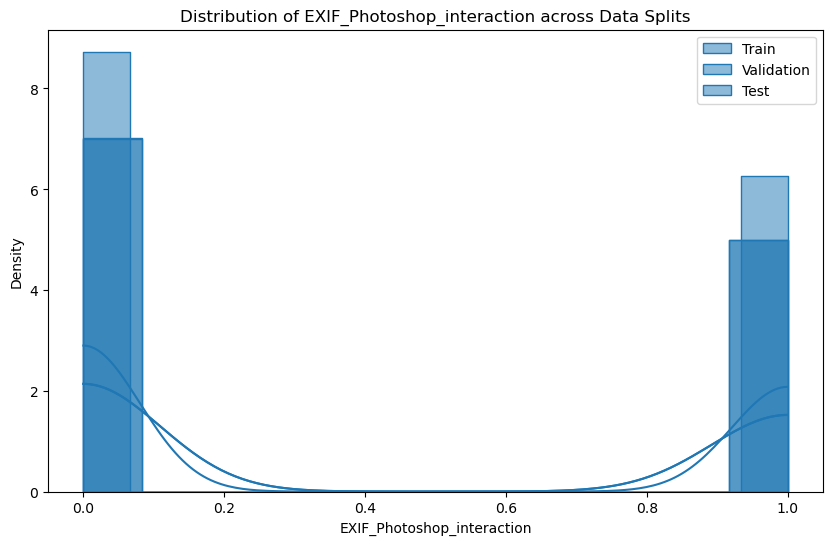

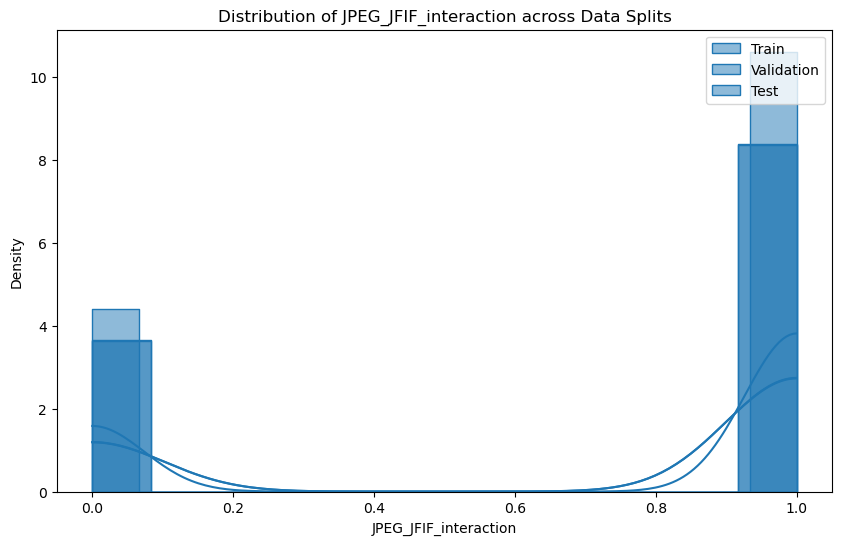

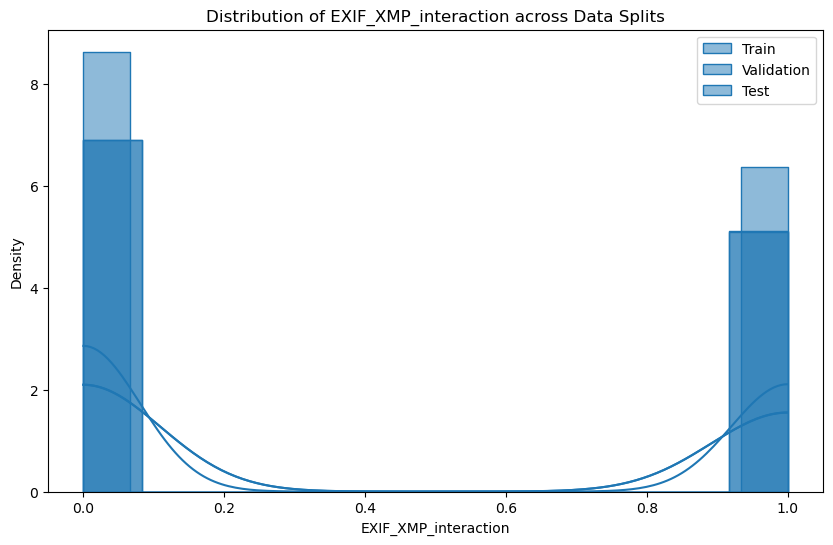

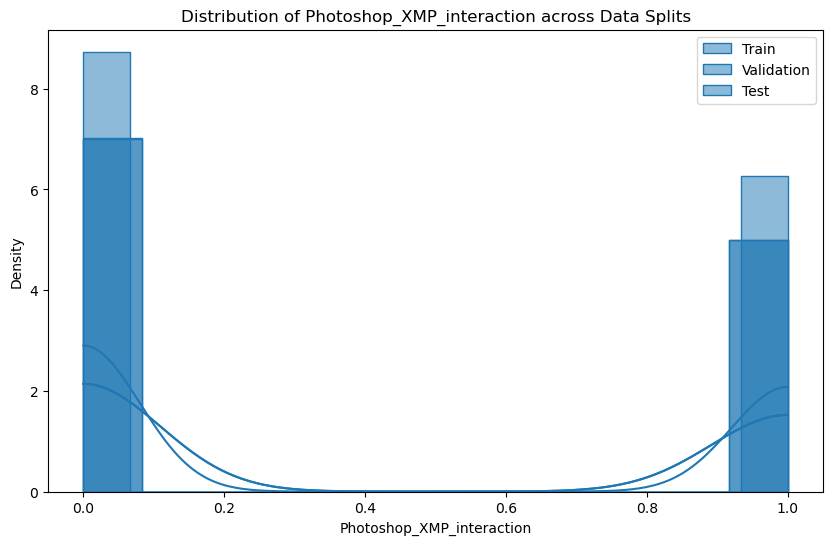

In [61]:
compare_all_distributions(train, validation, test)

In [ ]:
def generate_summary_statistics(df, label):
    """Generates summary statistics for all data types within a DataFrame."""
    stats = df.describe(include='all')
    return stats

def compare_summary_statistics(train, validation, test):
    """Generates and returns summary statistics for train, validation, and test datasets."""
    train_stats = generate_summary_statistics(train, 'Train')
    val_stats = generate_summary_statistics(validation, 'Validation')
    test_stats = generate_summary_statistics(test, 'Test')

    return train_stats, val_stats, test_stats

# Assuming train, validation, and test are your DataFrame variables
train_stats, val_stats, test_stats = compare_summary_statistics(train, validation, test)

In [88]:
print("Train Summary Statistics:")
train_stats

Train Summary Statistics:


ImageName  JPEG - Data Precision  \
count               8829                 6658.0   
unique              8829                    NaN   
top     Au_nat_00003.jpg                    NaN   
freq                   1                    NaN   
first                NaN                    NaN   
last                 NaN                    NaN   
mean                 NaN                    8.0   
std                  NaN                    0.0   
min                  NaN                    8.0   
25%                  NaN                    8.0   
50%                  NaN                    8.0   
75%                  NaN                    8.0   
max                  NaN                    8.0   

                                       JPEG - Component 1  \
count                                                6658   
unique                                                  3   
top     Y component: Quantization table 0, Sampling fa...   
freq                                                 4576   
first                                                 NaN   
last                                                  NaN   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

                                       JPEG - Component 2  \
count                                                6658   
unique                                                  1   
top     Cb component: Quantization table 1, Sampling f...   
freq                                                 6658   
first                                                 NaN   
last                                                  NaN   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

                                       JPEG - Component 3  JFIF - Version  \
count                                                6658     6240.000000   
unique                                                  2             NaN   
top     Cr component: Quantization table 1, Sampling f...             NaN   
freq                                                 6656             NaN   
first                                                 NaN             NaN   
last                                                  NaN             NaN   
mean                                                  NaN        1.124952   
std                                                   NaN        0.043425   
min                                                   NaN        1.000000   
25%                                                   NaN        1.100000   
50%                                                   NaN        1.100000   
75%                                                   NaN        1.200000   
max                                                   NaN        1.200000   

        JFIF - X Resolution  JFIF - Y Resolution  \
count           6240.000000          6240.000000   
unique                  NaN                  NaN   
top                     NaN                  NaN   
freq                    NaN                  NaN   
first                   NaN                  NaN   
last                    NaN                  NaN   
mean              88.176122            88.176122   
std              116.852397           116.852397   
min                0.000000             0.0

In [89]:
print("Validation Summary Statistics:")
val_stats

Validation Summary Statistics:


ImageName  JPEG - Data Precision  \
count               1892                 1432.0   
unique              1892                    NaN   
top     Au_ani_30746.jpg                    NaN   
freq                   1                    NaN   
first                NaN                    NaN   
last                 NaN                    NaN   
mean                 NaN                    8.0   
std                  NaN                    0.0   
min                  NaN                    8.0   
25%                  NaN                    8.0   
50%                  NaN                    8.0   
75%                  NaN                    8.0   
max                  NaN                    8.0   

                                       JPEG - Component 1  \
count                                                1432   
unique                                                  4   
top     Y component: Quantization table 0, Sampling fa...   
freq                                                  964   
first                                                 NaN   
last                                                  NaN   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

                                       JPEG - Component 2  \
count                                                1432   
unique                                                  1   
top     Cb component: Quantization table 1, Sampling f...   
freq                                                 1432   
first                                                 NaN   
last                                                  NaN   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

                                       JPEG - Component 3  JFIF - Version  \
count                                                1432     1320.000000   
unique                                                  1             NaN   
top     Cr component: Quantization table 1, Sampling f...             NaN   
freq                                                 1432             NaN   
first                                                 NaN             NaN   
last                                                  NaN             NaN   
mean                                                  NaN        1.125606   
std                                                   NaN        0.043662   
min                                                   NaN        1.100000   
25%                                                   NaN        1.100000   
50%                                                   NaN        1.100000   
75%                                                   NaN        1.200000   
max                                                   NaN        1.200000   

        JFIF - X Resolution  JFIF - Y Resolution  \
count           1320.000000          1320.000000   
unique                  NaN                  NaN   
top                     NaN                  NaN   
freq                    NaN                  NaN   
first                   NaN                  NaN   
last                    NaN                  NaN   
mean              87.534848            87.534848   
std              111.497398           111.497398   
min                1.000000             1.0

In [90]:
print("\nTest Summary Statistics:")
test_stats


Test Summary Statistics:


ImageName  JPEG - Data Precision  \
count                                       1893                 1411.0   
unique                                      1893                    NaN   
top     Tp_D_NRD_S_B_arc00096_arc00045_11798.jpg                    NaN   
freq                                           1                    NaN   
first                                        NaN                    NaN   
last                                         NaN                    NaN   
mean                                         NaN                    8.0   
std                                          NaN                    0.0   
min                                          NaN                    8.0   
25%                                          NaN                    8.0   
50%                                          NaN                    8.0   
75%                                          NaN                    8.0   
max                                          NaN                    8.0   

                                       JPEG - Component 1  \
count                                                1411   
unique                                                  4   
top     Y component: Quantization table 0, Sampling fa...   
freq                                                  975   
first                                                 NaN   
last                                                  NaN   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

                                       JPEG - Component 2  \
count                                                1411   
unique                                                  1   
top     Cb component: Quantization table 1, Sampling f...   
freq                                                 1411   
first                                                 NaN   
last                                                  NaN   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

                                       JPEG - Component 3  JFIF - Version  \
count                                                1411     1317.000000   
unique                                                  1             NaN   
top     Cr component: Quantization table 1, Sampling f...             NaN   
freq                                                 1411             NaN   
first                                                 NaN             NaN   
last                                                  NaN             NaN   
mean                                                  NaN        1.124525   
std                                                   NaN        0.043040   
min                                                   NaN        1.100000   
25%                                                   NaN        1.100000   
50%                                                   NaN        1.100000   
75%                                                   NaN        1.100000   
max                                                   NaN        1.200000   

        JFIF - X Resolution  JFIF - Y Resolution  \
count           1317.000000          1317.000000   
unique                  NaN                  NaN   
top                     NaN                

In [56]:
test['has_EXIF_data'].value_counts(normalize=True, dropna=False)

0    0.529319
1    0.470681
Name: has_EXIF_data, dtype: float64

In [57]:
# Create binary features to identify whether JPEG image width and height differ to EXIF image width and height - should be the same, but both may not be updated after a manipulation
# For the training set
train['Width_Discrepancy'] = (train['JPEG - Image Width (Pixels)'] != train['Exif SubIFD - Exif Image Width (Pixels)']).astype(int)
train['Height_Discrepancy'] = (train['JPEG - Image Height (Pixels)'] != train['Exif SubIFD - Exif Image Height (Pixels)']).astype(int)

# For the validation set
validation['Width_Discrepancy'] = (validation['JPEG - Image Width (Pixels)'] != validation['Exif SubIFD - Exif Image Width (Pixels)']).astype(int)
validation['Height_Discrepancy'] = (validation['JPEG - Image Height (Pixels)'] != validation['Exif SubIFD - Exif Image Height (Pixels)']).astype(int)

# For the test set
test['Width_Discrepancy'] = (test['JPEG - Image Width (Pixels)'] != test['Exif SubIFD - Exif Image Width (Pixels)']).astype(int)
test['Height_Discrepancy'] = (test['JPEG - Image Height (Pixels)'] != test['Exif SubIFD - Exif Image Height (Pixels)']).astype(int)

In [28]:
earliest_date = df_dropped['File - File Modified Date'].min()
latest_date = df_dropped['File - File Modified Date'].max()

print(f"Earliest Date: {earliest_date}")
print(f"Latest Date: {latest_date}")

Earliest Date: 2023-10-11 10:18:14+01:00
Latest Date: 2023-10-11 10:23:51+01:00


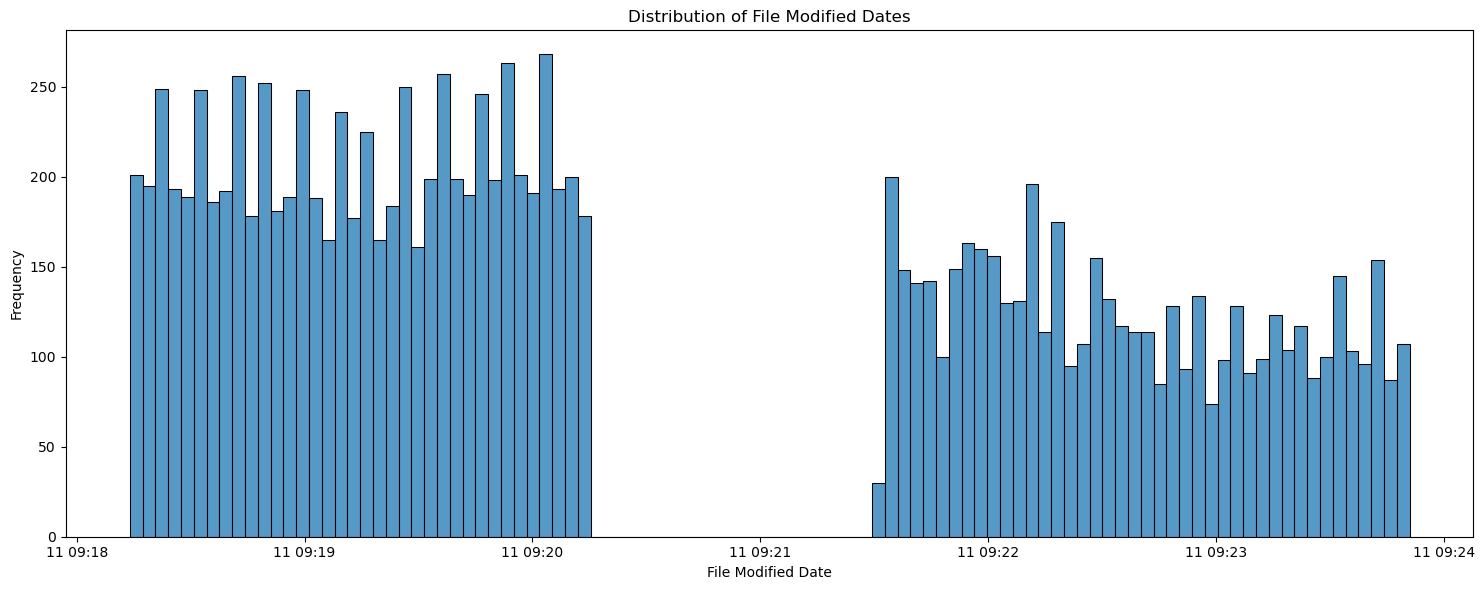

In [27]:
# Visualizing the distribution of dates
plt.figure(figsize=(15, 6))
sns.histplot(df_dropped['File - File Modified Date'], kde=False, bins=100)
plt.title('Distribution of File Modified Dates')
plt.xlabel('File Modified Date')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [ ]:
# File modified date seems to refer to the date on which I downloaded the data. So, drop

In [58]:
# SEE BELOW - Photoshop - Caption Digest - drop AFTER 'has Photoshop - Caption Digest' feature created
train['Has_Photoshop_Caption_Digest'] = train['Photoshop - Caption Digest'].notna().astype(int)
validation['Has_Photoshop_Caption_Digest'] = validation['Photoshop - Caption Digest'].notna().astype(int)
test['Has_Photoshop_Caption_Digest'] = test['Photoshop - Caption Digest'].notna().astype(int)

In [59]:
# JPEG - Data Precision - seems irrelevant to the problem at hand - drop from all sets
# JPEG Components 2 and 3 only have one unique value - drop
# Exif IFD0 - Orientation - refers to orientation of camera when photo was taken - only one unique value - drop
# Exif IFD0 - Resolution Unit - practically all values are 'Inch' - drop
# Exif IFD0 - Date/Time - all null - drop
# Photoshop - Caption Digest - drop AFTER 'has Photoshop - Caption Digest' feature created
# Photoshop - Thumbnail Data - seems useless - drop
# IPTC - Application Record Version - mostly null or '0' - measure correlation with target.
train.drop([
    'JPEG - Data Precision', 'JPEG - Component 2', 'JPEG - Component 3', 'File - File Modified Date', 'Exif IFD0 - Orientation', 'Exif IFD0 - Resolution Unit', 'Exif IFD0 - Date/Time'
    , 'Photoshop - Caption Digest', 'Photoshop - Thumbnail Data'
    ], axis=1, inplace=True)
validation.drop([
    'JPEG - Data Precision', 'JPEG - Component 2', 'JPEG - Component 3', 'File - File Modified Date', 'Exif IFD0 - Orientation', 'Exif IFD0 - Resolution Unit', 'Exif IFD0 - Date/Time'
    , 'Photoshop - Caption Digest', 'Photoshop - Thumbnail Data'
    ], axis=1, inplace=True)
test.drop([
    'JPEG - Data Precision', 'JPEG - Component 2', 'JPEG - Component 3', 'File - File Modified Date', 'Exif IFD0 - Orientation', 'Exif IFD0 - Resolution Unit', 'Exif IFD0 - Date/Time'
    , 'Photoshop - Caption Digest', 'Photoshop - Thumbnail Data'
    ], axis=1, inplace=True)

In [60]:
train.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8829 entries, 7360 to 4410
Data columns (total 34 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   ImageName                                 8829 non-null   object 
 1   JPEG - Component 1                        6658 non-null   object 
 2   JFIF - Version                            6240 non-null   float64
 3   JFIF - X Resolution                       6240 non-null   float64
 4   JFIF - Y Resolution                       6240 non-null   float64
 5   File Type - Detected File Type Name       8829 non-null   object 
 6   Exif IFD0 - X Resolution                  3917 non-null   object 
 7   Exif IFD0 - Y Resolution                  3917 non-null   object 
 8   Exif IFD0 - Software                      4124 non-null   object 
 9   XMP - XMP Value Count                     3746 non-null   float64
 10  Exif SubIFD - Color Space        

In [61]:
validation.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1892 entries, 1927 to 1043
Data columns (total 34 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   ImageName                                 1892 non-null   object 
 1   JPEG - Component 1                        1432 non-null   object 
 2   JFIF - Version                            1320 non-null   float64
 3   JFIF - X Resolution                       1320 non-null   float64
 4   JFIF - Y Resolution                       1320 non-null   float64
 5   File Type - Detected File Type Name       1892 non-null   object 
 6   Exif IFD0 - X Resolution                  858 non-null    object 
 7   Exif IFD0 - Y Resolution                  858 non-null    object 
 8   Exif IFD0 - Software                      903 non-null    object 
 9   XMP - XMP Value Count                     804 non-null    float64
 10  Exif SubIFD - Color Space        

In [62]:
test.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1893 entries, 4831 to 783
Data columns (total 34 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   ImageName                                 1893 non-null   object 
 1   JPEG - Component 1                        1411 non-null   object 
 2   JFIF - Version                            1317 non-null   float64
 3   JFIF - X Resolution                       1317 non-null   float64
 4   JFIF - Y Resolution                       1317 non-null   float64
 5   File Type - Detected File Type Name       1893 non-null   object 
 6   Exif IFD0 - X Resolution                  850 non-null    object 
 7   Exif IFD0 - Y Resolution                  850 non-null    object 
 8   Exif IFD0 - Software                      888 non-null    object 
 9   XMP - XMP Value Count                     806 non-null    float64
 10  Exif SubIFD - Color Space         

In [63]:
# Save the datasets to CSV files to use later
train.to_csv('train_data.csv', index=False)
validation.to_csv('validation_data.csv', index=False)
test.to_csv('test_data.csv', index=False)

In [66]:
# New features

# Aspect Ratio
# This is the ratio of the image's width to its height. It could capture distortions or rescaling that might happen during image manipulation.
train['Aspect_Ratio'] = train['JPEG - Image Width (Pixels)'] / train['JPEG - Image Height (Pixels)']
validation['Aspect_Ratio'] = validation['JPEG - Image Width (Pixels)'] / validation['JPEG - Image Height (Pixels)']
test['Aspect_Ratio'] = test['JPEG - Image Width (Pixels)'] / test['JPEG - Image Height (Pixels)']

# Resolution Product
# This is the product of the image's X and Y resolutions. It might capture changes in the image quality or rescaling that could occur in manipulated images.
train['Resolution_Product'] = train['JFIF - X Resolution'] * train['JFIF - Y Resolution']
validation['Resolution_Product'] = validation['JFIF - X Resolution'] * validation['JFIF - Y Resolution']
test['Resolution_Product'] = test['JFIF - X Resolution'] * test['JFIF - Y Resolution']

# Size-to-Dimension Ratio
# This is the ratio of the file size to the product of image dimensions. It might capture the level of compression or change in file size that could be indicative of manipulation.
train['Size_to_Dimension_Ratio'] = train['File - File Size (Bytes)'] / (train['JPEG - Image Width (Pixels)'] * train['JPEG - Image Height (Pixels)'])
validation['Size_to_Dimension_Ratio'] = validation['File - File Size (Bytes)'] / (validation['JPEG - Image Width (Pixels)'] * validation['JPEG - Image Height (Pixels)'])
test['Size_to_Dimension_Ratio'] = test['File - File Size (Bytes)'] / (test['JPEG - Image Width (Pixels)'] * test['JPEG - Image Height (Pixels)'])

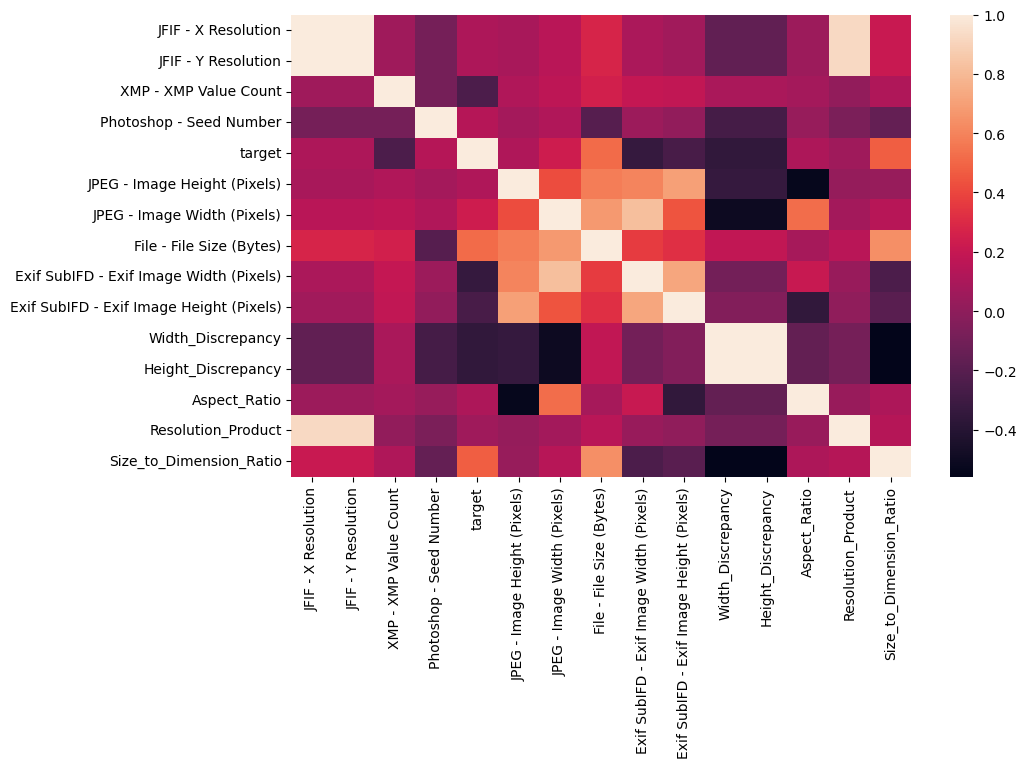

In [90]:
# Heatmap of correlation matrix
plt.figure(figsize=(10,6))
sns.heatmap(train.corr())
plt.show()

In [91]:
train.corr()

JFIF - X Resolution  \
JFIF - X Resolution                                  1.000000   
JFIF - Y Resolution                                  1.000000   
XMP - XMP Value Count                                0.061163   
Photoshop - Seed Number                             -0.093636   
target                                               0.107166   
JPEG - Image Height (Pixels)                         0.088392   
JPEG - Image Width (Pixels)                          0.152658   
File - File Size (Bytes)                             0.272391   
Exif SubIFD - Exif Image Width (Pixels)              0.100448   
Exif SubIFD - Exif Image Height (Pixels)             0.062867   
Width_Discrepancy                                   -0.162682   
Height_Discrepancy                                  -0.162682   
Aspect_Ratio                                         0.045803   
Resolution_Product                                   0.924252   
Size_to_Dimension_Ratio                              0.209220   

                                          JFIF - Y Resolution  \
JFIF - X Resolution                                  1.000000   
JFIF - Y Resolution                                  1.000000   
XMP - XMP Value Count                                0.061163   
Photoshop - Seed Number                             -0.093636   
target                                               0.107166   
JPEG - Image Height (Pixels)                         0.088392   
JPEG - Image Width (Pixels)                          0.152658   
File - File Size (Bytes)                             0.272391   
Exif SubIFD - Exif Image Width (Pixels)              0.100448   
Exif SubIFD - Exif Image Height (Pixels)             0.062867   
Width_Discrepancy                                   -0.162682   
Height_Discrepancy                                  -0.162682   
Aspect_Ratio                                         0.045803   
Resolution_Product                                   0.924252   
Size_to_Dimension_Ratio                              0.209220   

                                          XMP - XMP Value Count  \
JFIF - X Resolution                                    0.061163   
JFIF - Y Resolution                                    0.061163   
XMP - XMP Value Count                                  1.000000   
Photoshop - Seed Number                               -0.091346   
target                                                -0.244988   
JPEG - Image Height (Pixels)                           0.123311   
JPEG - Image Width (Pixels)                            0.167139   
File - File Size (Bytes)                               0.251084   
Exif SubIFD - Exif Image Width (Pixels)                0.196205   
Exif SubIFD - Exif Image Height (Pixels)               0.182043   
Width_Discrepancy                                      0.097417   
Height_Discrepancy                                     0.097417   
Aspect_Ratio                                           0.077028   
Resolution_Product                                     0.009652   
Size_to_Dimension_Ratio                                0.116063   

                                          Photoshop - Seed Number    target  \
JFIF - X Resolution                                     -0.093636  0.107166   
JFIF - Y Resolution                                     -0.093636  0.107166   
XMP - XMP Value Count                                   -0.091346 -0.244988   
Photoshop - Seed Number                                  1.000000  0.136727   
target                                                   0.136727  1.000000   
JPEG - Image Height (Pixels)                             0.076150  0.113559   
JPEG - Image Width (Pixels)                              0.123525  0.231211   
File - File Size (Bytes)                                -0.209070  0.519161   
Exif SubIFD - Exif Image Width (Pixels)                  0.046997 -0.336129   
Exif SubIFD - Exif Image Height (Pixels)                 0.012816 -0.263007   
Width_Discrepancy 

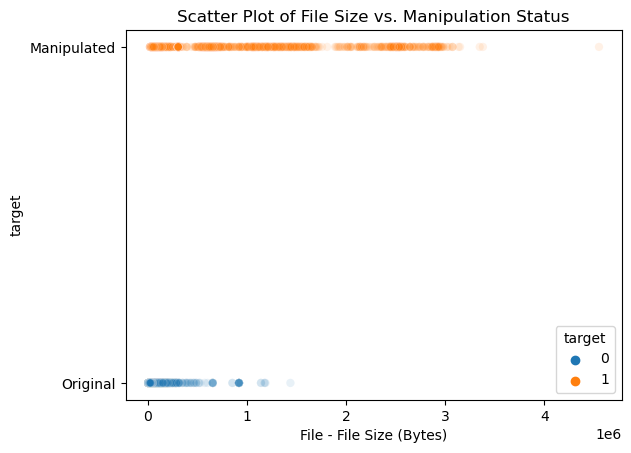

In [87]:
# File size seems strongly correlated with target
sns.scatterplot(x='File - File Size (Bytes)', y='target', data=train, hue='target', alpha=0.1)

plt.yticks([0, 1], ['Original', 'Manipulated'])
plt.title('Scatter Plot of File Size vs. Manipulation Status')
plt.show()

<AxesSubplot:xlabel='target', ylabel='File - File Size (Bytes)'>

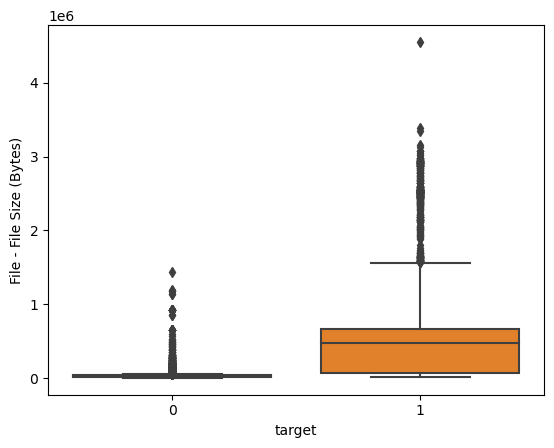

In [83]:
sns.boxplot(x='target', y='File - File Size (Bytes)', data=train)

In [93]:
train.groupby('target')['Photoshop - Seed Number'].count()

target
0     109
1    3581
Name: Photoshop - Seed Number, dtype: int64

In [78]:
train['IPTC - Application Record Version'].value_counts(normalize=True, dropna=False)

NaN     0.721599
0.0     0.199570
2.0     0.077925
36.0    0.000906
Name: IPTC - Application Record Version, dtype: float64

In [79]:
pd.crosstab(train['IPTC - Application Record Version'], train['target'])

target                              0     1
IPTC - Application Record Version          
0.0                                18  1744
2.0                                56   632
36.0                                2     6

In [94]:
# Contingency tables for categorical variables with target
features = [col for col in train.columns if col not in ['ImageName', 'target']]

for feature in features:
    crosstab_result = pd.crosstab(train[feature], train['target'])
    print(f"Crosstab for {feature} with target:\n")
    print(crosstab_result)
    print("\n" + "="*50 + "\n")  # Separator for clarity

Crosstab for JPEG - Component 1 with target:

target                                                 0     1
JPEG - Component 1                                            
Y component: Quantization table 0, Sampling fac...   213  1446
Y component: Quantization table 0, Sampling fac...   423     0
Y component: Quantization table 0, Sampling fac...  4574     2


Crosstab for JFIF - X Resolution with target:

target                  0     1
JFIF - X Resolution            
0.0                     5     0
1.0                    40    23
26.0                    0     1
37.0                    1     0
72.0                 4522  1179
96.0                   88    61
100.0                  18    24
144.0                   2     2
180.0                   6     5
240.0                   9     8
253.0                   0     2
265.0                   0     1
300.0                  57    98
303.0                   2     1
304.0                   7     6
305.0                   2     2
349.0         

In [89]:
# Drop JFIF - Version - perfect correlation with target, but (I believe) this is an artefact of the dataset
# Same for IPTC - Application Record Version - drop
# 'has...data' and interaction features seem too highly correlated with the data - won't generalise well. Remove from model, but keep as rules? Inform Solutions
train.drop([
    'JFIF - Version', 'IPTC - Application Record Version',  'has_EXIF_data', 'has_Photoshop_data', 'has_JPEG_data', 'has_JFIF_data', 'has_XMP_data', 'EXIF_Photoshop_interaction', 'JPEG_JFIF_interaction'
    , 'EXIF_XMP_interaction', 'Photoshop_XMP_interaction', 'Has_Photoshop_Caption_Digest'
    ], axis=1, inplace=True)
validation.drop([
    'JFIF - Version', 'IPTC - Application Record Version',  'has_EXIF_data', 'has_Photoshop_data', 'has_JPEG_data', 'has_JFIF_data', 'has_XMP_data', 'EXIF_Photoshop_interaction', 'JPEG_JFIF_interaction'
    , 'EXIF_XMP_interaction', 'Photoshop_XMP_interaction', 'Has_Photoshop_Caption_Digest'
    ], axis=1, inplace=True)
test.drop([
    'JFIF - Version', 'IPTC - Application Record Version',  'has_EXIF_data', 'has_Photoshop_data', 'has_JPEG_data', 'has_JFIF_data', 'has_XMP_data', 'EXIF_Photoshop_interaction', 'JPEG_JFIF_interaction'
    , 'EXIF_XMP_interaction', 'Photoshop_XMP_interaction', 'Has_Photoshop_Caption_Digest'
    ], axis=1, inplace=True)

In [95]:
# Drop Photoshop - Seed Number - almost all are target
# Photoshop - Slices - drop - almost all unique
# Exif IFD0 - Software - drop - almost all target created in photoshop, which is a category of values in this variable
# File Type - Detected File Type Name - seems to be a file type pattern amongst manipulated - SHOULD I REMOVE?
# Exif IFD0 - X Resolution and Exif IFD0 - Y Resolution - most of the target have one value - 72 dots per inch. Artefact of data creation process? - SHOULD I REMOVE? 
# XMP - XMP Value Count, Exif SubIFD - Color Space, Photoshop - Resolution Info, Photoshop - Slices, Photoshop - Version Info
train.drop([
    'Photoshop - Seed Number', 'Photoshop - Slices', 'Exif IFD0 - Software', 'File Type - Detected File Type Name', 'Exif IFD0 - X Resolution', 'Exif IFD0 - Y Resolution', 'XMP - XMP Value Count'
    , 'Exif SubIFD - Color Space', 'Photoshop - Resolution Info', 'Photoshop - Version Info'
    ], axis=1, inplace=True)
validation.drop([
    'Photoshop - Seed Number', 'Photoshop - Slices', 'Exif IFD0 - Software', 'File Type - Detected File Type Name', 'Exif IFD0 - X Resolution', 'Exif IFD0 - Y Resolution', 'XMP - XMP Value Count'
    , 'Exif SubIFD - Color Space', 'Photoshop - Resolution Info', 'Photoshop - Version Info'
    ], axis=1, inplace=True)
test.drop([
    'Photoshop - Seed Number', 'Photoshop - Slices', 'Exif IFD0 - Software', 'File Type - Detected File Type Name', 'Exif IFD0 - X Resolution', 'Exif IFD0 - Y Resolution', 'XMP - XMP Value Count'
    , 'Exif SubIFD - Color Space', 'Photoshop - Resolution Info', 'Photoshop - Version Info'
    ], axis=1, inplace=True)

In [96]:
train.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8829 entries, 7360 to 4410
Data columns (total 15 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   ImageName                                 8829 non-null   object 
 1   JPEG - Component 1                        6658 non-null   object 
 2   JFIF - X Resolution                       6240 non-null   float64
 3   JFIF - Y Resolution                       6240 non-null   float64
 4   target                                    8829 non-null   int64  
 5   JPEG - Image Height (Pixels)              6658 non-null   float64
 6   JPEG - Image Width (Pixels)               6658 non-null   float64
 7   File - File Size (Bytes)                  8829 non-null   int64  
 8   Exif SubIFD - Exif Image Width (Pixels)   4127 non-null   float64
 9   Exif SubIFD - Exif Image Height (Pixels)  4127 non-null   float64
 10  Width_Discrepancy                

In [97]:
# Contingency tables for categorical variables with target
features = [col for col in train.columns if col not in ['ImageName', 'target']]

for feature in features:
    crosstab_result = pd.crosstab(train[feature], train['target'])
    print(f"Crosstab for {feature} with target:\n")
    print(crosstab_result)
    print("\n" + "="*50 + "\n")  # Separator for clarity

Crosstab for JPEG - Component 1 with target:

target                                                 0     1
JPEG - Component 1                                            
Y component: Quantization table 0, Sampling fac...   213  1446
Y component: Quantization table 0, Sampling fac...   423     0
Y component: Quantization table 0, Sampling fac...  4574     2


Crosstab for JFIF - X Resolution with target:

target                  0     1
JFIF - X Resolution            
0.0                     5     0
1.0                    40    23
26.0                    0     1
37.0                    1     0
72.0                 4522  1179
96.0                   88    61
100.0                  18    24
144.0                   2     2
180.0                   6     5
240.0                   9     8
253.0                   0     2
265.0                   0     1
300.0                  57    98
303.0                   2     1
304.0                   7     6
305.0                   2     2
349.0         

In [98]:
# Drop JPEG - Component 1
train.drop([
    'JPEG - Component 1'
    ], axis=1, inplace=True)
validation.drop([
    'JPEG - Component 1'
    ], axis=1, inplace=True)
test.drop([
    'JPEG - Component 1'
    ], axis=1, inplace=True)

In [99]:
train.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8829 entries, 7360 to 4410
Data columns (total 14 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   ImageName                                 8829 non-null   object 
 1   JFIF - X Resolution                       6240 non-null   float64
 2   JFIF - Y Resolution                       6240 non-null   float64
 3   target                                    8829 non-null   int64  
 4   JPEG - Image Height (Pixels)              6658 non-null   float64
 5   JPEG - Image Width (Pixels)               6658 non-null   float64
 6   File - File Size (Bytes)                  8829 non-null   int64  
 7   Exif SubIFD - Exif Image Width (Pixels)   4127 non-null   float64
 8   Exif SubIFD - Exif Image Height (Pixels)  4127 non-null   float64
 9   Width_Discrepancy                         8829 non-null   int64  
 10  Height_Discrepancy               

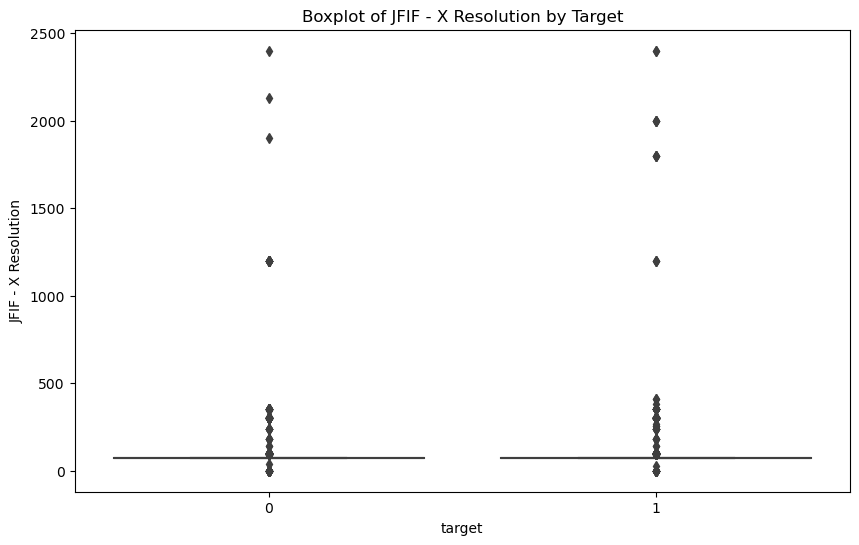

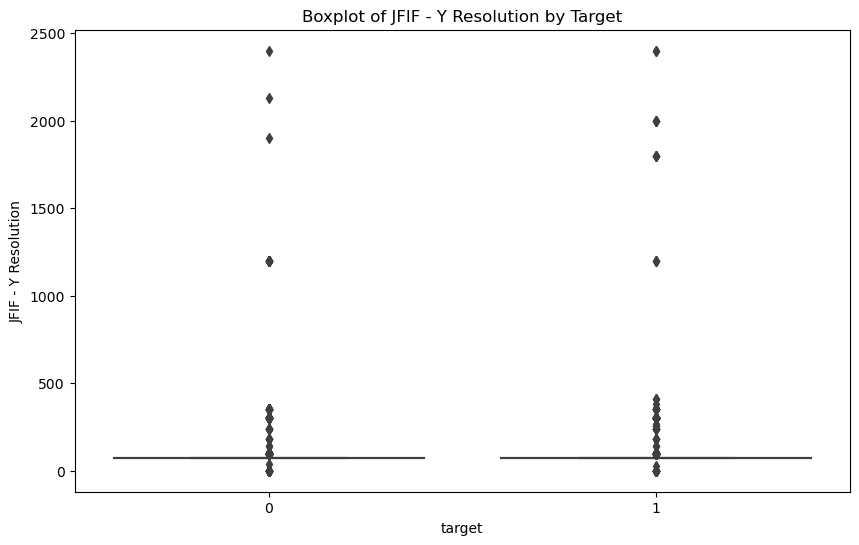

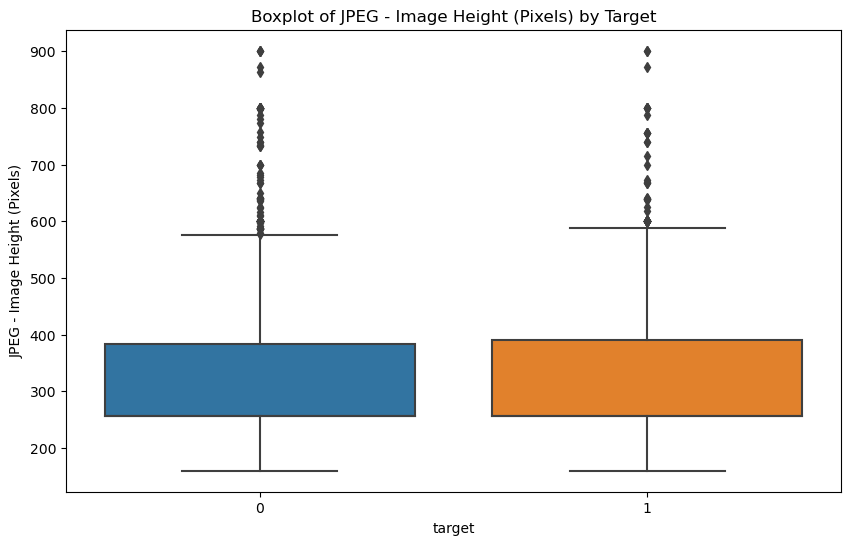

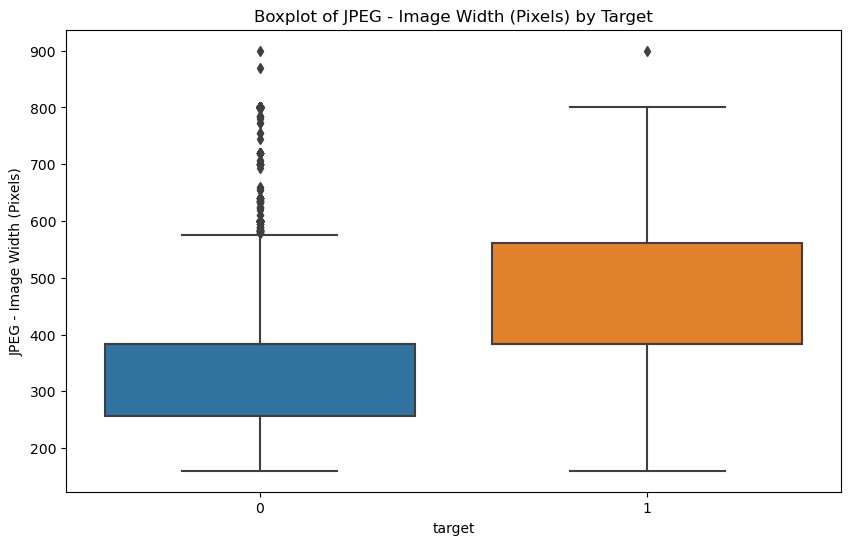

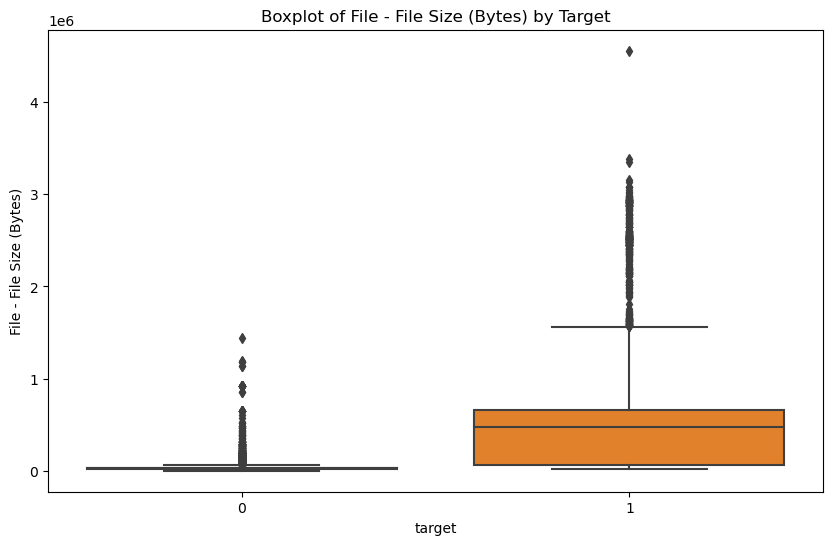

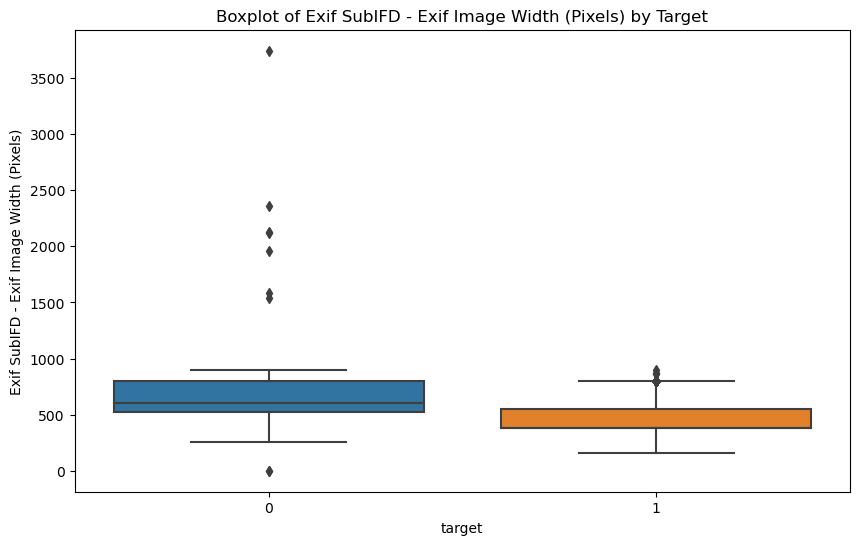

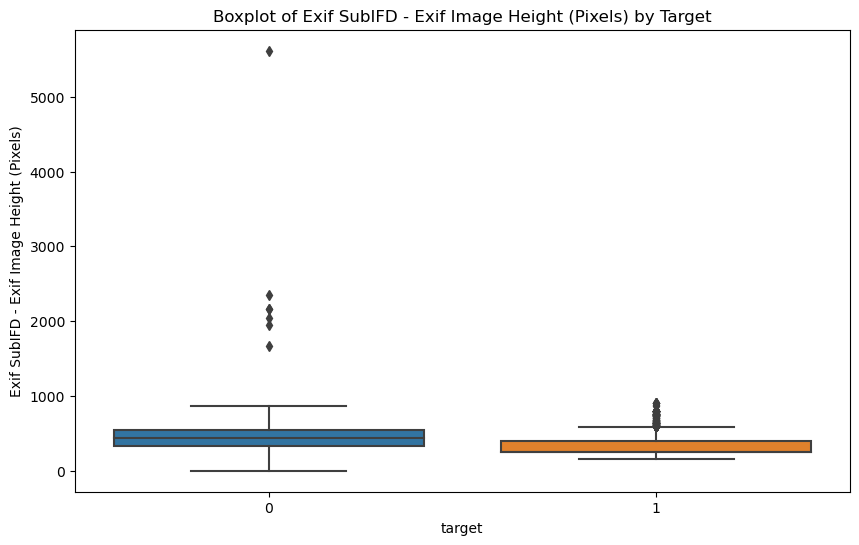

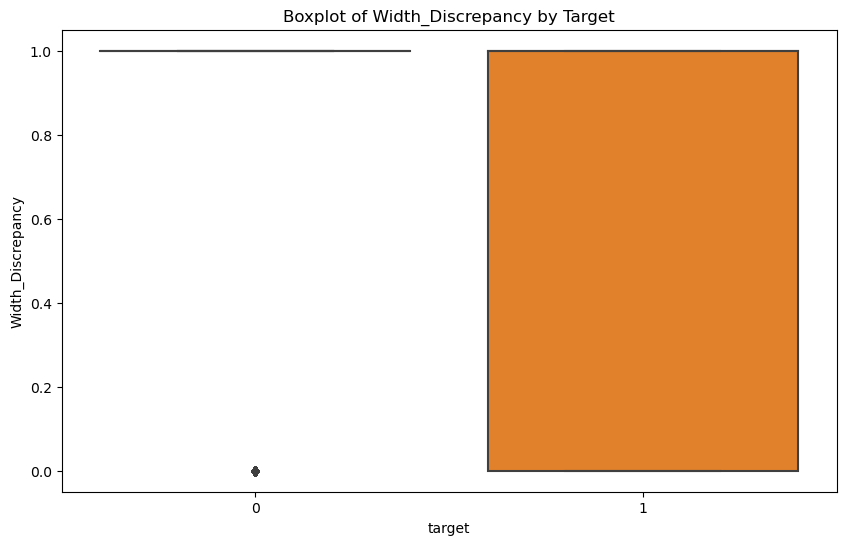

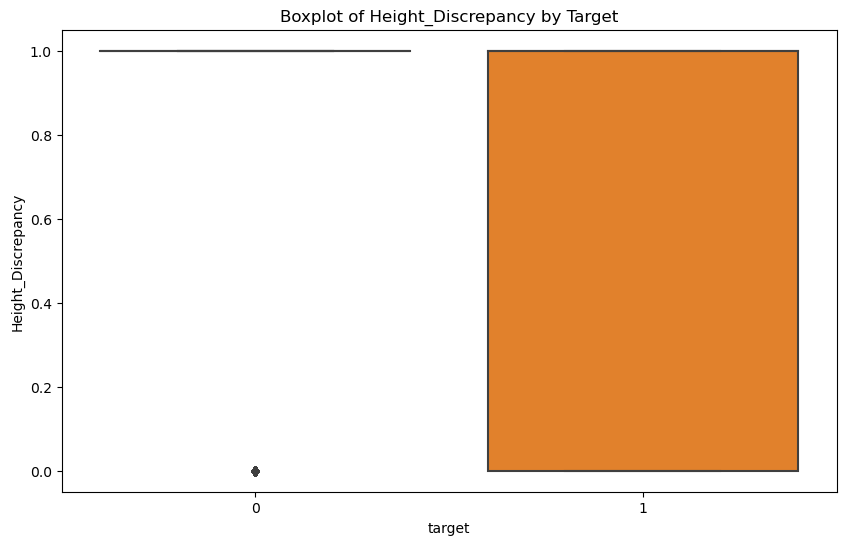

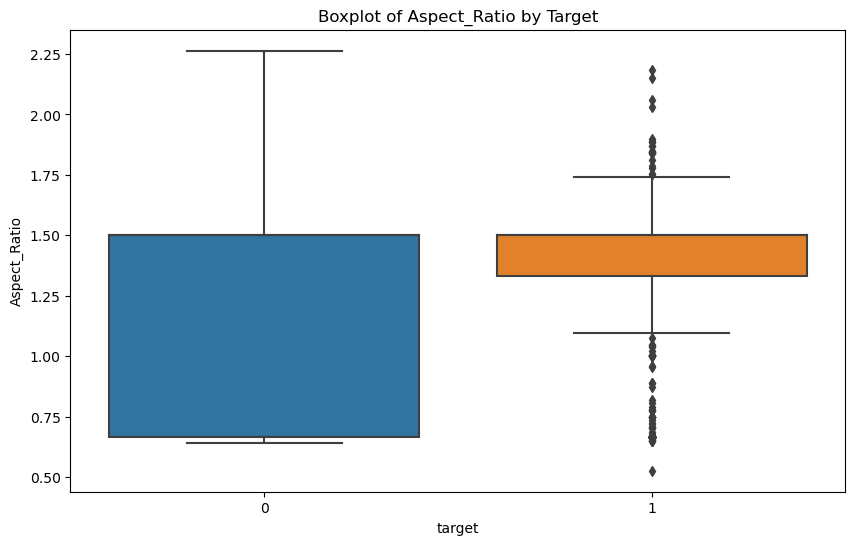

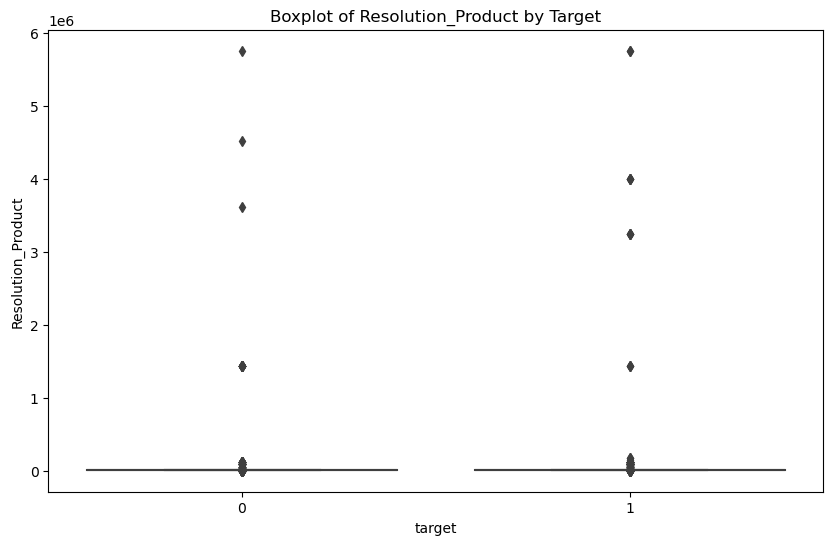

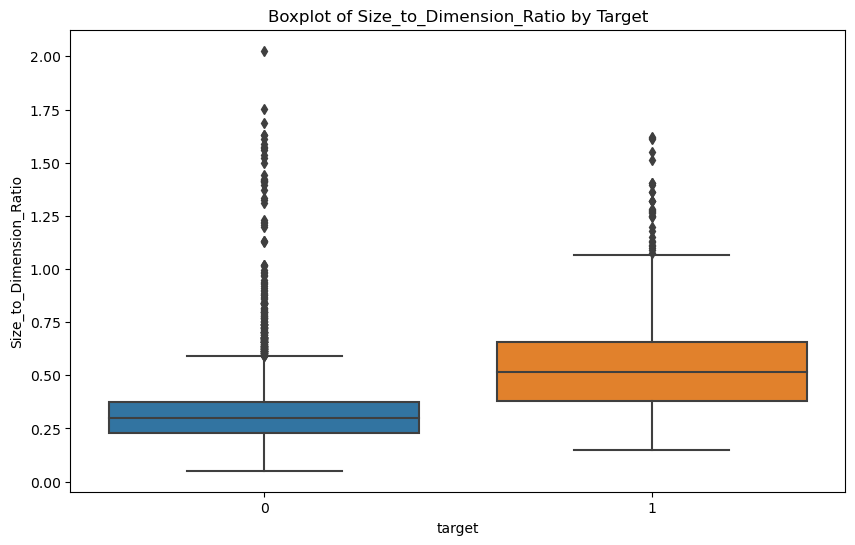

In [25]:
# Boxplots of numeric features vs. target

# List of numeric features in the dataframe 
numeric_features = train.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Exclude the target variable from the numeric features list
numeric_features.remove('target')

# Plot boxplots for each numeric feature against the target
for feature in numeric_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='target', y=feature, data=train)
    plt.title(f'Boxplot of {feature} by Target')
    plt.show()

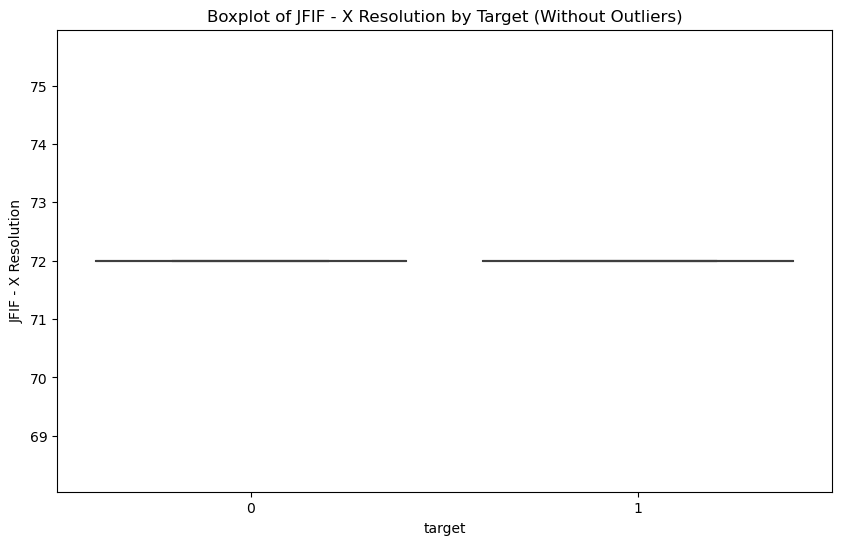

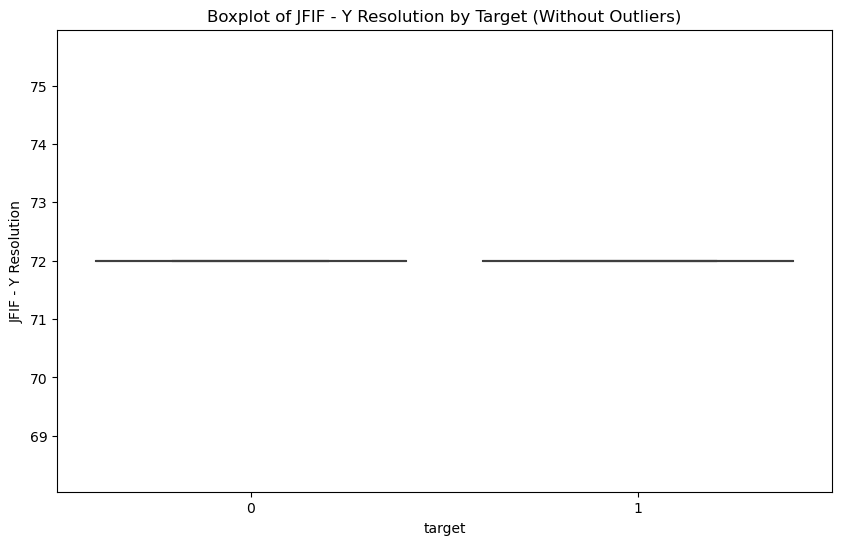

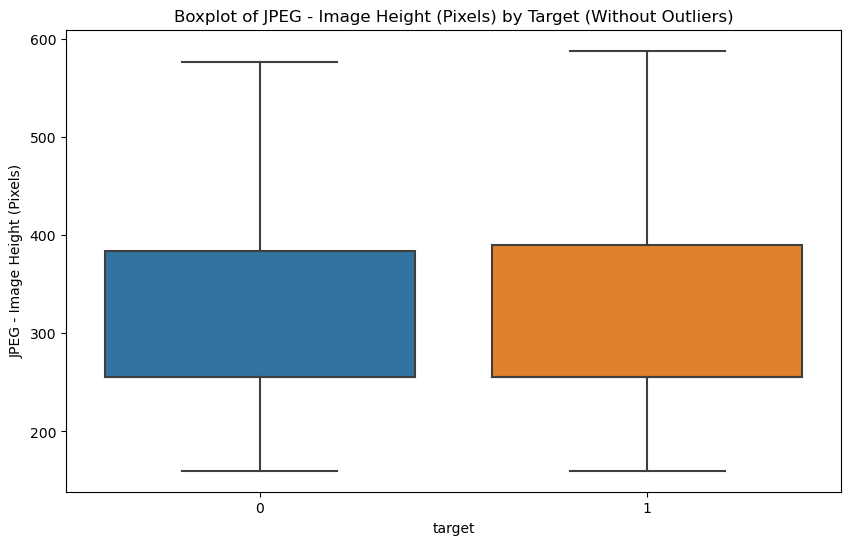

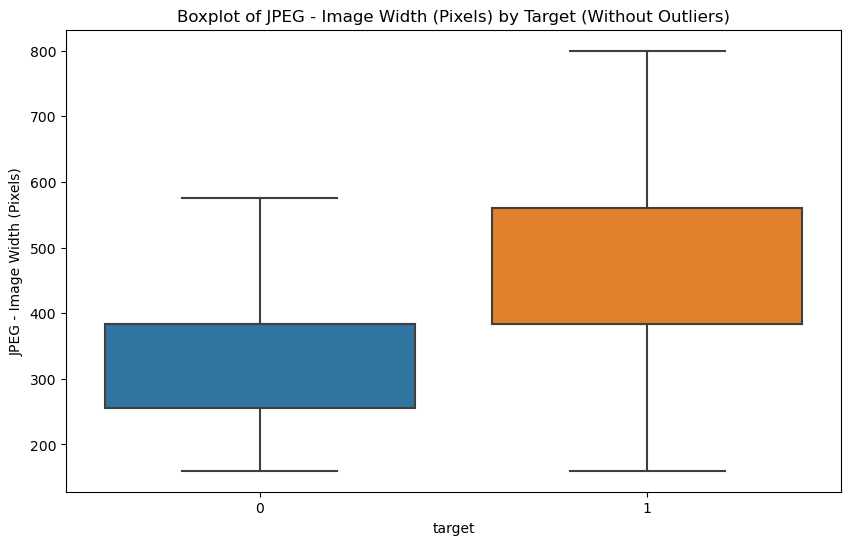

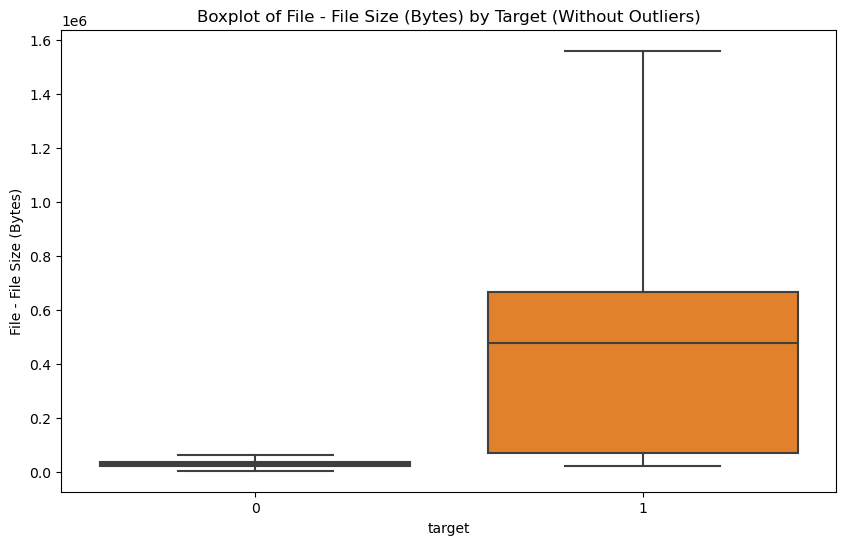

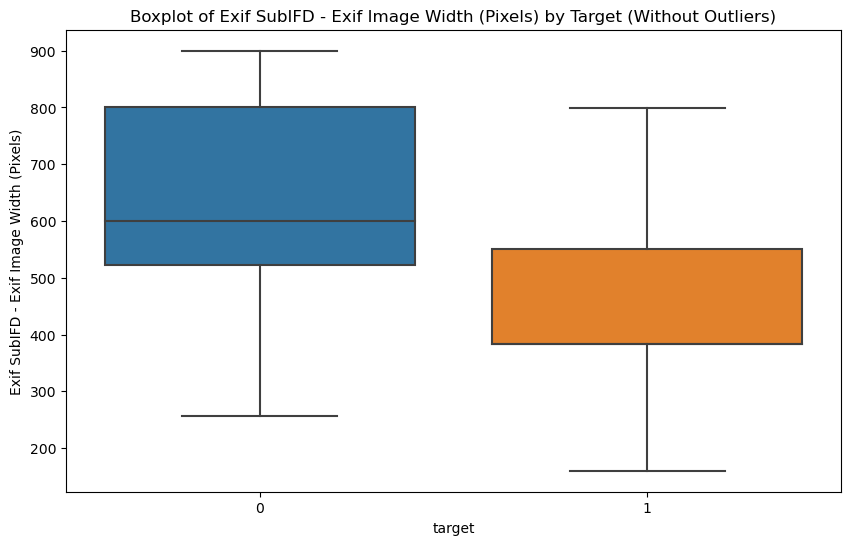

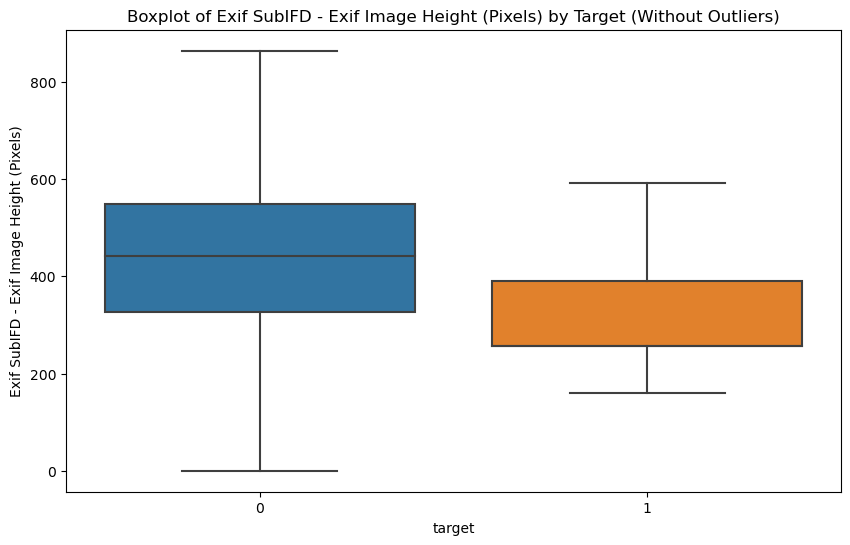

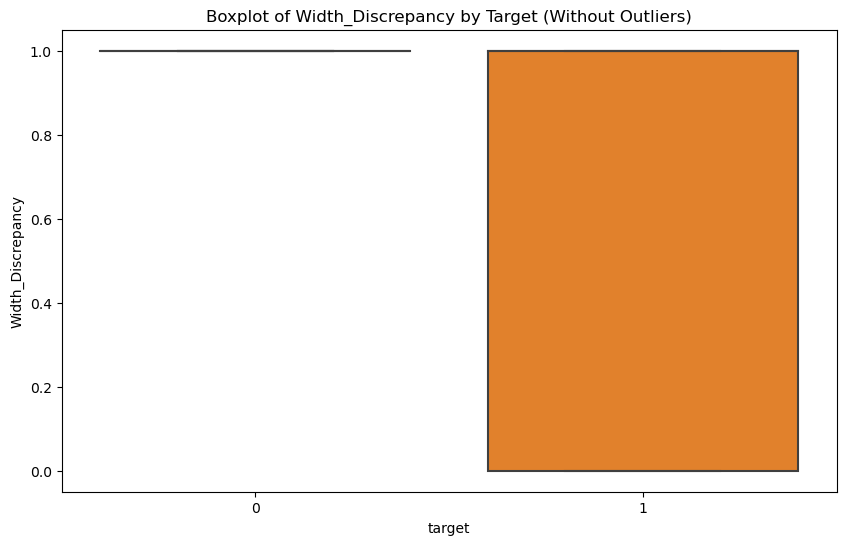

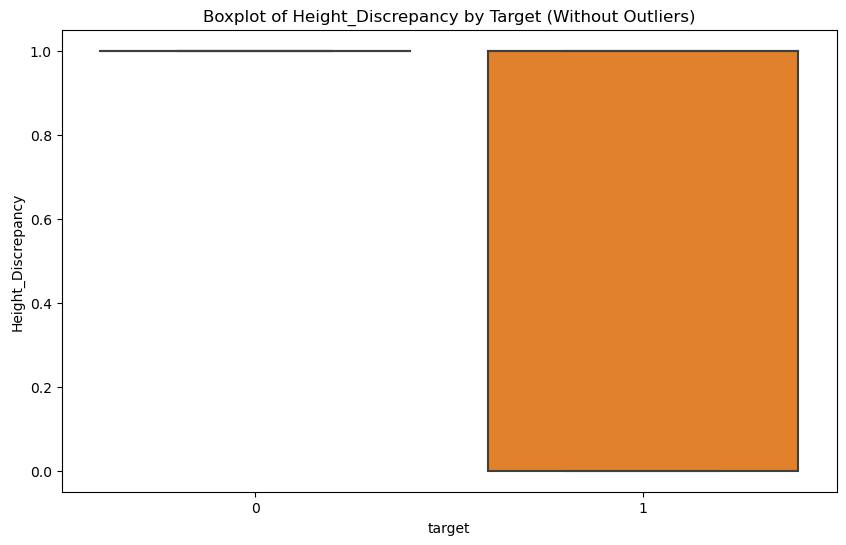

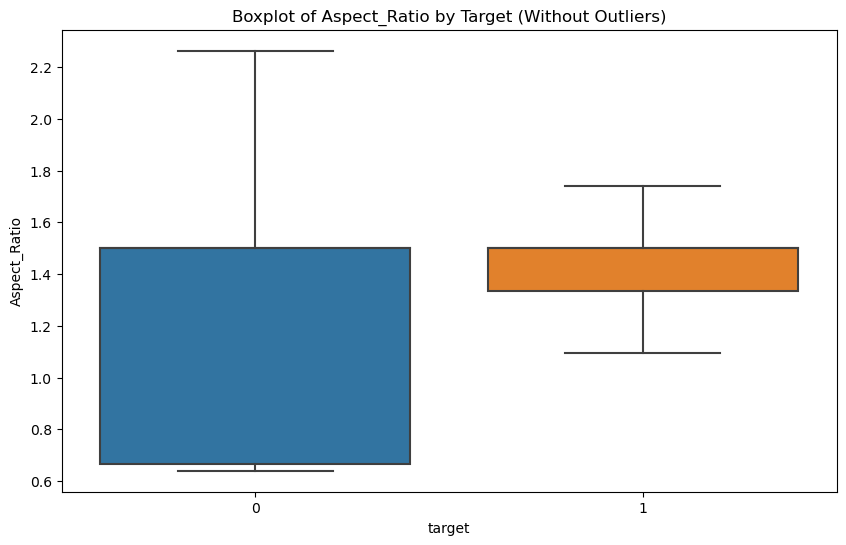

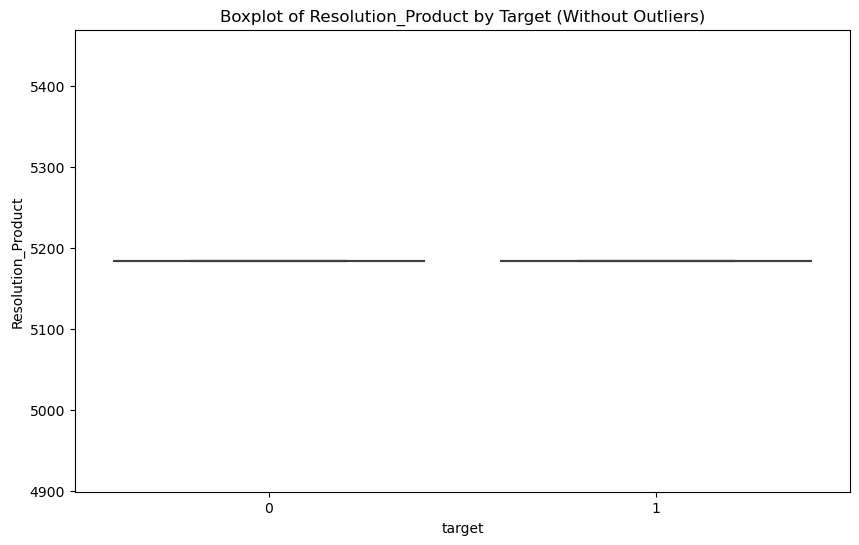

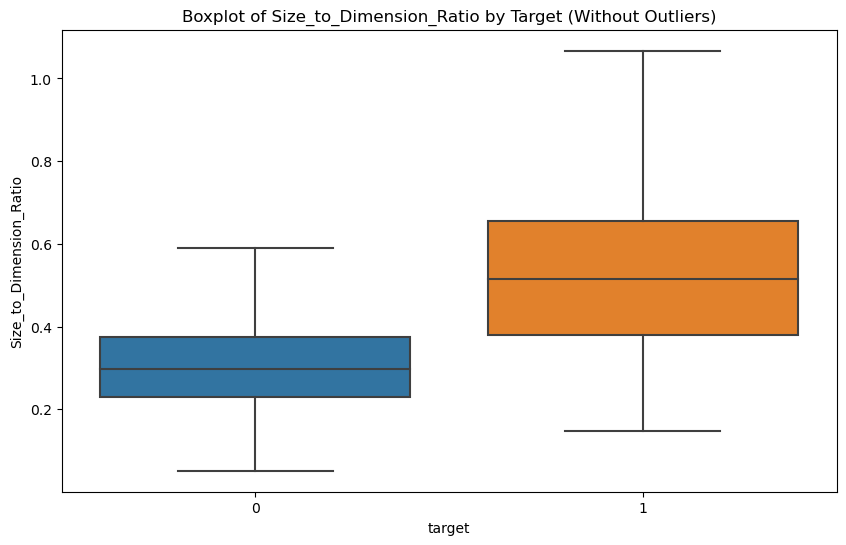

In [101]:
# Boxplots of numeric features vs. target (minus outliers)

# List of numeric features in the dataframe
numeric_features = train.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Exclude the target variable from the numeric features list
numeric_features.remove('target')

# Plot boxplots for each numeric feature against the target without outliers
for feature in numeric_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='target', y=feature, data=train, showfliers=False)
    plt.title(f'Boxplot of {feature} by Target (Without Outliers)')
    plt.show()

In [102]:
# Save the datasets to CSV files to use later
train.to_csv('train_data.csv', index=False)
validation.to_csv('validation_data.csv', index=False)
test.to_csv('test_data.csv', index=False)

In [7]:
# Read train, validation and test CSVs back in as DataFrames
train = pd.read_csv('train_data.csv')
validation = pd.read_csv('validation_data.csv')
test = pd.read_csv('test_data.csv')

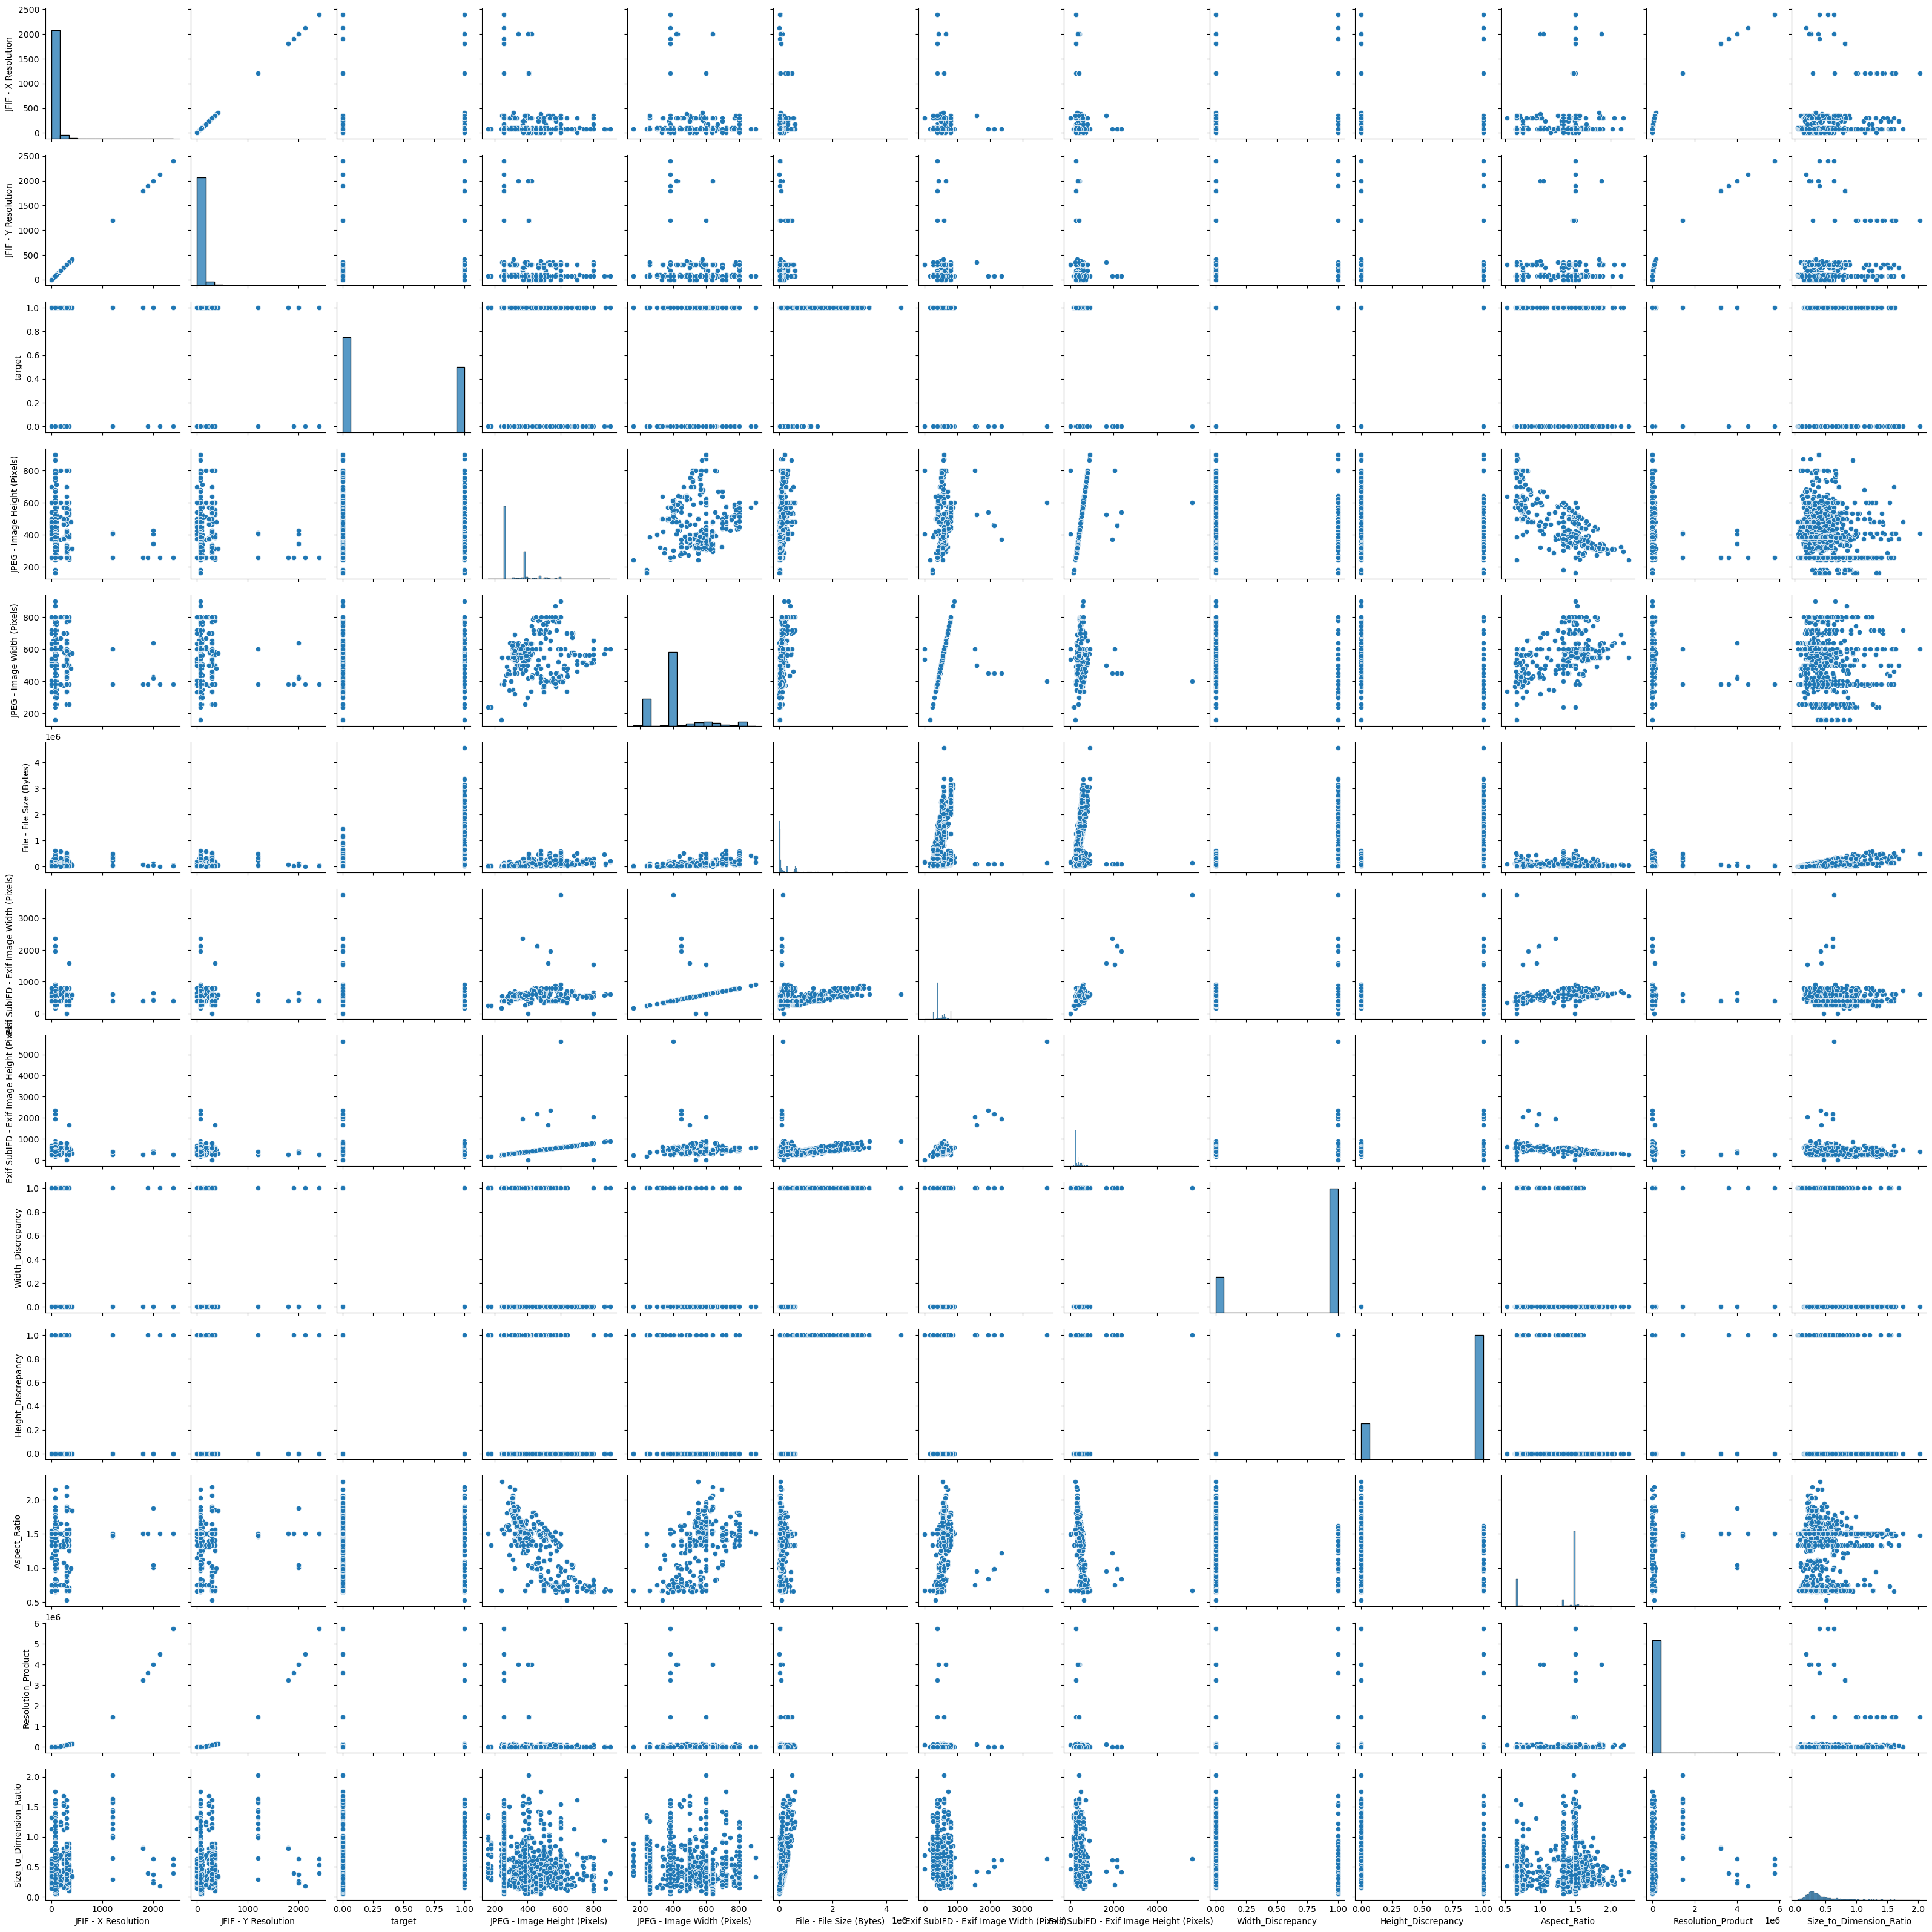

In [26]:
# Scatter plots of all numeric variables against each other
sns.pairplot(train)

In [8]:
# Missing Values: Check for missing values and their patterns.
train.isnull().sum()

ImageName                                      0
JFIF - X Resolution                         2589
JFIF - Y Resolution                         2589
target                                         0
JPEG - Image Height (Pixels)                2171
JPEG - Image Width (Pixels)                 2171
File - File Size (Bytes)                       0
Exif SubIFD - Exif Image Width (Pixels)     4702
Exif SubIFD - Exif Image Height (Pixels)    4702
Width_Discrepancy                              0
Height_Discrepancy                             0
Aspect_Ratio                                2171
Resolution_Product                          2589
Size_to_Dimension_Ratio                     2171
dtype: int64

<AxesSubplot:>

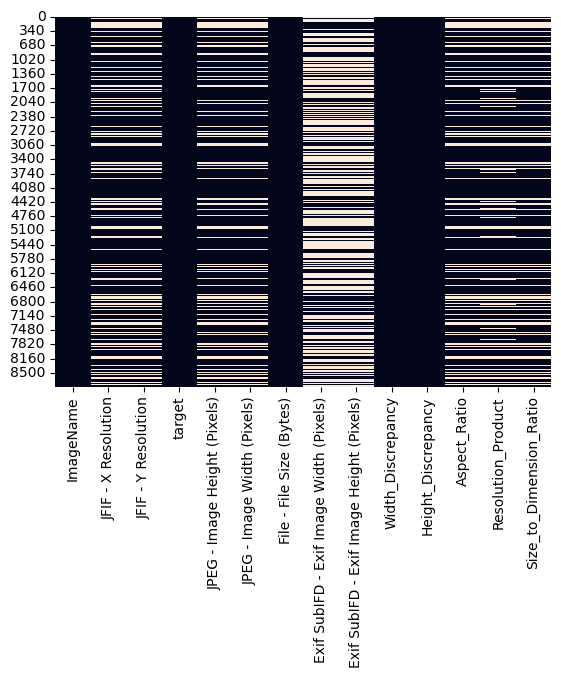

In [28]:
sns.heatmap(train.isnull(), cbar=False)

In [30]:
# Check for duplicates
print(train.duplicated().sum())
print(validation.duplicated().sum())
print(test.duplicated().sum())

0
0
0


## Model Training and Validation

In [9]:
# Function to move the target column to the front of a DataFrame, which is a requirement for Sagemaker's implementation of XGBoost.
def move_target_to_front(df, target_column):
    """
    Moves the target column to the front of the DataFrame.

    Parameters:
    - df (pd.DataFrame): The original DataFrame
    - target_column (str): The name of the target column

    Returns:
    - pd.DataFrame: A new DataFrame with the target column at the front
    """
    # Get a list of all columns
    cols = list(df.columns)
    
    # Remove the target column from the list
    cols.remove(target_column)
    
    # Create a new ordered list with the target column at the front
    cols = [target_column] + cols
    
    # Reorder the DataFrame
    df = df[cols]
    
    return df

# Call
train = move_target_to_front(train, 'target')
validation = move_target_to_front(validation, 'target')
test = move_target_to_front(test, 'target')

In [14]:
train.head()

target                                 ImageName  JFIF - X Resolution  \
0       0                          Au_txt_00016.jpg                 72.0   
1       1  Tp_S_NRD_S_N_pla20007_pla20007_01907.tif                  NaN   
2       1  Tp_S_NNN_S_N_art20088_art20088_02309.tif                  NaN   
3       1  Tp_D_NRN_M_N_nat10160_nat10147_12069.jpg                 72.0   
4       1  Tp_S_NNN_S_N_nat00050_nat00050_00660.tif                  NaN   

   JFIF - Y Resolution  JPEG - Image Height (Pixels)  \
0                 72.0                         256.0   
1                  NaN                           NaN   
2                  NaN                           NaN   
3                 72.0                         480.0   
4                  NaN                           NaN   

   JPEG - Image Width (Pixels)  File - File Size (Bytes)  \
0                        384.0                     33368   
1                          NaN                   4550700   
2                          NaN                   2212528   
3                        640.0                     77339   
4                          NaN                    598644   

   Exif SubIFD - Exif Image Width (Pixels)  \
0                                      NaN   
1                                    600.0   
2                                    720.0   
3                                    640.0   
4                                    384.0   

   Exif SubIFD - Exif Image Height (Pixels)  Width_Discrepancy  \
0                                       NaN                  1   
1                                     901.0                  1   
2                                     480.0                  1   
3                                     480.0                  0   
4                                     256.0                  1   

   Height_Discrepancy  Aspect_Ratio  Resolution_Product  \
0                   1      1.500000              5184.0   
1                   1           NaN                 NaN   
2                   1           NaN                 NaN   
3                   0      1.333333              5184.0   
4                   1           NaN                 NaN   

   Size_to_Dimension_Ratio  
0                 0.339437  
1                      NaN  
2                      NaN  
3                 0.251755  
4                      NaN

In [61]:
# Check unique labels in your training data
unique_labels = validation_df['target'].unique()
print("Unique label values:", unique_labels)

# Check if any label is outside the [0,1] range
if any((label < 0 or label > 1) for label in unique_labels):
    print("Labels outside [0, 1] found")
else:
    print("All labels are within [0, 1]")

Unique label values: [0 1]
All labels are within [0, 1]


In [58]:
train_df['target'].value_counts(dropna=False)

0    5243
1    3586
Name: target, dtype: int64

In [64]:
# Drop 'ImageName' from training and validation DataFrames
train_df = train.drop(columns=['ImageName'])
validation_df = validation.drop(columns=['ImageName'])

# In respect to the test Dataframe, store 'ImageName' in a separate variable before dropping it from 'test'. The image names can, then, be married up with their respective predictions during evaluation.
test_image_names = test['ImageName']

# Drop 'ImageName' from the test DataFrame
test_df = test.drop(columns=['ImageName'])

In [8]:
# Initialize SageMaker session
sagemaker_session = None  # Removed for public version

# Get SageMaker role
role = get_execution_role()

# Specify the bucket and files
bucket = 'your-bucket-name'
prefix = 'example-project'

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [65]:
# Upload data to Sagemaker
train_file = 'train.csv'
validation_file = 'validation.csv'
test_file = 'test.csv'

# Upload as CSV files
train_df.to_csv(train_file, header=False, index=False)
validation_df.to_csv(validation_file, header=False, index=False)
test_df.to_csv(test_file, header=False, index=False)

In [66]:
# Upload CSV files to S3
train_uri = S3Uploader.upload(train_file, 's3://{}/{}'.format(bucket, prefix))
validation_uri = S3Uploader.upload(validation_file, 's3://{}/{}'.format(bucket, prefix))
test_uri = S3Uploader.upload(test_file, 's3://{}/{}'.format(bucket, prefix))

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [67]:
# Set the location for the training and validation data
s3_input_train = TrainingInput(s3_data=f"s3://{bucket}/{prefix}/train", content_type="csv")
s3_input_validation = TrainingInput(s3_data=f"s3://{bucket}/{prefix}/validation", content_type="csv")

### Initialise XGBoost Estimator

In [68]:
# Get the XGBoost container
container = retrieve("xgboost", region=sagemaker_session.boto_region_name, version="1.0-1")

# Create an XGBoost estimator
xgb = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    output_path=f"s3://{bucket}/{prefix}/output",
    sagemaker_session=sagemaker_session,
)

# Set common hyperparameters (those not being tuned)
xgb.set_hyperparameters(
    objective="binary:logistic",
    eval_metric="auc",
    num_round=500,  # You could also rely on early stopping
    early_stopping_rounds=10
)

# Define hyperparameter ranges
hyperparameter_ranges = {
    "max_depth": IntegerParameter(3, 10),
    "eta": ContinuousParameter(0.01, 0.2),
    "gamma": ContinuousParameter(0, 5),
    "min_child_weight": IntegerParameter(1, 6),
    "subsample": ContinuousParameter(0.5, 1),
    "colsample_bytree": ContinuousParameter(0.5, 1),
}

# Create the hyperparameter tuner
tuner = HyperparameterTuner(
    xgb,
    objective_metric_name="validation:auc",
    hyperparameter_ranges=hyperparameter_ranges,
    max_jobs=20,
    max_parallel_jobs=1,
)

In [69]:
# Start hyperparameter tuning
tuner.fit({"train": s3_input_train, "validation": s3_input_validation})

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.................................................................................................................................................................................................................................................!


In [5]:
# Read train, validation and test CSVs back in as DataFrames
train = pd.read_csv('train.csv')
validation = pd.read_csv('validation.csv')
test = pd.read_csv('test.csv')

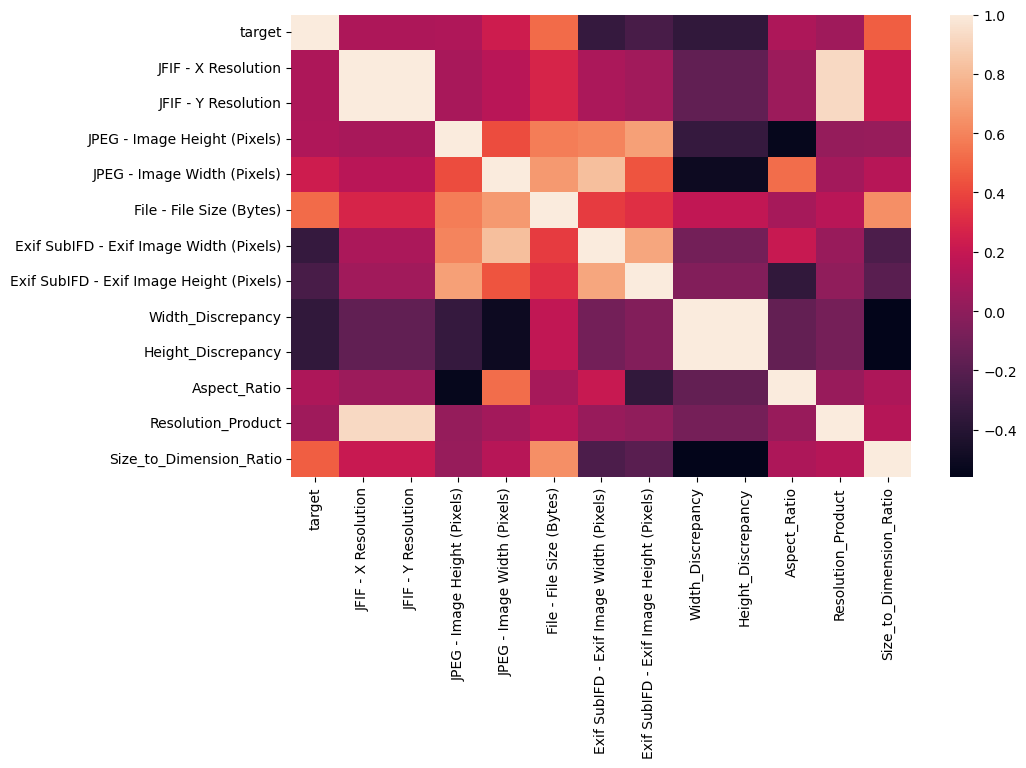

In [11]:
# Heatmap of correlation matrix
plt.figure(figsize=(10,6))
sns.heatmap(train.corr())
plt.show()

In [12]:
train.corr()

target  JFIF - X Resolution  \
target                                    1.000000             0.107166   
JFIF - X Resolution                       0.107166             1.000000   
JFIF - Y Resolution                       0.107166             1.000000   
JPEG - Image Height (Pixels)              0.113559             0.088392   
JPEG - Image Width (Pixels)               0.231211             0.152658   
File - File Size (Bytes)                  0.519161             0.272391   
Exif SubIFD - Exif Image Width (Pixels)  -0.336129             0.100448   
Exif SubIFD - Exif Image Height (Pixels) -0.263007             0.062867   
Width_Discrepancy                        -0.354824            -0.162682   
Height_Discrepancy                       -0.354824            -0.162682   
Aspect_Ratio                              0.107321             0.045803   
Resolution_Product                        0.061426             0.924252   
Size_to_Dimension_Ratio                   0.470885             0.209220   

                                          JFIF - Y Resolution  \
target                                               0.107166   
JFIF - X Resolution                                  1.000000   
JFIF - Y Resolution                                  1.000000   
JPEG - Image Height (Pixels)                         0.088392   
JPEG - Image Width (Pixels)                          0.152658   
File - File Size (Bytes)                             0.272391   
Exif SubIFD - Exif Image Width (Pixels)              0.100448   
Exif SubIFD - Exif Image Height (Pixels)             0.062867   
Width_Discrepancy                                   -0.162682   
Height_Discrepancy                                  -0.162682   
Aspect_Ratio                                         0.045803   
Resolution_Product                                   0.924252   
Size_to_Dimension_Ratio                              0.209220   

                                          JPEG - Image Height (Pixels)  \
target                                                        0.113559   
JFIF - X Resolution                                           0.088392   
JFIF - Y Resolution                                           0.088392   
JPEG - Image Height (Pixels)                                  1.000000   
JPEG - Image Width (Pixels)                                   0.420185   
File - File Size (Bytes)                                      0.577964   
Exif SubIFD - Exif Image Width (Pixels)                       0.599882   
Exif SubIFD - Exif Image Height (Pixels)                      0.700908   
Width_Discrepancy                                            -0.333239   
Height_Discrepancy                                           -0.333239   
Aspect_Ratio                                                 -0.534157   
Resolution_Product                                            0.023608   
Size_to_Dimension_Ratio                                       0.030981   

                                          JPEG - Image Width (Pixels)  \
target                                                       0.231211   
JFIF - X Resolution                                          0.152658   
JFIF - Y Resolution                                          0.152658   
JPEG - Image Height (Pixels)                                 0.420185   
JPEG - Image Width (Pixels)                                  1.000000   
File - File Size (Bytes)                                     0.676475   
Exif SubIFD - Exif Image Width (Pixels)                      0.821577   
Exif SubIFD - Exif Image Height (Pixels)                     0.440963   
Width_Discrepancy                                           -0.509384   
Height_Discrepancy                                          -0.509384   
Aspect_Ratio                                                 0.522446   
Resolution_Product                                           0.072366   
Size_to_Dimension_Ratio                                      0.147655   

                      

### Run 2 - Remove File Size and Size-to-Dimension Ratio

#### Both features seem to be heavily influenced by the data creation process

In [16]:
# As in run 1, drop 'ImageName' from training and validation DataFrames, but include file size and size to dimension ratio too.
train_df = train.drop(columns=['ImageName', 'File - File Size (Bytes)', 'Size_to_Dimension_Ratio'])
validation_df = validation.drop(columns=['ImageName', 'File - File Size (Bytes)', 'Size_to_Dimension_Ratio'])

# In respect to the test Dataframe, store 'ImageName' in a separate variable before dropping it from 'test'. The image names can, then, be married up with their respective predictions during evaluation.
test_image_names = test['ImageName']
test_image_names_file = 'test_image_names.csv'
test_image_names.to_csv(test_image_names_file, header=False, index=False)

# Drop 'ImageName' from the test DataFrame
test_df = test.drop(columns=['ImageName', 'File - File Size (Bytes)', 'Size_to_Dimension_Ratio'])

In [17]:
# Check
train_df.head()

target  JFIF - X Resolution  JFIF - Y Resolution  \
0       0                 72.0                 72.0   
1       1                  NaN                  NaN   
2       1                  NaN                  NaN   
3       1                 72.0                 72.0   
4       1                  NaN                  NaN   

   JPEG - Image Height (Pixels)  JPEG - Image Width (Pixels)  \
0                         256.0                        384.0   
1                           NaN                          NaN   
2                           NaN                          NaN   
3                         480.0                        640.0   
4                           NaN                          NaN   

   Exif SubIFD - Exif Image Width (Pixels)  \
0                                      NaN   
1                                    600.0   
2                                    720.0   
3                                    640.0   
4                                    384.0   

   Exif SubIFD - Exif Image Height (Pixels)  Width_Discrepancy  \
0                                       NaN                  1   
1                                     901.0                  1   
2                                     480.0                  1   
3                                     480.0                  0   
4                                     256.0                  1   

   Height_Discrepancy  Aspect_Ratio  Resolution_Product  
0                   1      1.500000              5184.0  
1                   1           NaN                 NaN  
2                   1           NaN                 NaN  
3                   0      1.333333              5184.0  
4                   1           NaN                 NaN

In [19]:
# Upload data to Sagemaker
train_file = 'train.csv'
validation_file = 'validation.csv'
test_file = 'test.csv'

# Upload as CSV files
train_df.to_csv(train_file, header=False, index=False)
validation_df.to_csv(validation_file, header=False, index=False)
test_df.to_csv(test_file, header=False, index=False)

In [20]:
# Upload CSV files to S3
train_uri = S3Uploader.upload(train_file, 's3://{}/{}'.format(bucket, prefix))
validation_uri = S3Uploader.upload(validation_file, 's3://{}/{}'.format(bucket, prefix))
test_uri = S3Uploader.upload(test_file, 's3://{}/{}'.format(bucket, prefix))

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [21]:
# Set the location for the training and validation data
s3_input_train = TrainingInput(s3_data=f"s3://{bucket}/{prefix}/train", content_type="csv")
s3_input_validation = TrainingInput(s3_data=f"s3://{bucket}/{prefix}/validation", content_type="csv")

In [22]:
# Get the XGBoost container
container = retrieve("xgboost", region=sagemaker_session.boto_region_name, version="1.0-1")

# Create an XGBoost estimator
xgb = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    output_path=f"s3://{bucket}/{prefix}/output",
    sagemaker_session=sagemaker_session,
)

# Set common hyperparameters (those not being tuned)
xgb.set_hyperparameters(
    objective="binary:logistic",
    eval_metric="auc",
    num_round=500,  # You could also rely on early stopping
    early_stopping_rounds=10
)

# Define hyperparameter ranges
hyperparameter_ranges = {
    "max_depth": IntegerParameter(3, 10),
    "eta": ContinuousParameter(0.01, 0.2),
    "gamma": ContinuousParameter(0, 5),
    "min_child_weight": IntegerParameter(1, 6),
    "subsample": ContinuousParameter(0.5, 1),
    "colsample_bytree": ContinuousParameter(0.5, 1),
}

# Create the hyperparameter tuner
tuner = HyperparameterTuner(
    xgb,
    objective_metric_name="validation:auc",
    hyperparameter_ranges=hyperparameter_ranges,
    max_jobs=20,
    max_parallel_jobs=1,
)

In [23]:
# Start hyperparameter tuning
tuner.fit({"train": s3_input_train, "validation": s3_input_validation})

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.........................................................................................................................................................................................................!


### Run 3 - 'leave-one-out' strategy

#### Rationale: determine the effect of each feature on model performance

In [42]:
# Function to get the best hyperparameters and objective metric score
def get_best_auc_from_tuner(tuner):
    # Fetch completed hyperparameter tuning jobs sorted by the final metric (ObjectiveValue)
    tuner_analysis = tuner.analytics()
    summary_df = tuner_analysis.dataframe()
    if summary_df.empty:
        return None
    summary_df = summary_df.sort_values('FinalObjectiveValue', ascending=False)
    
    # Get the best objective metric from the top-performing job
    best_objective_metric = summary_df.iloc[0]['FinalObjectiveValue']
    
    return best_objective_metric

In [43]:
# List of feature names
features = [
    'JFIF - X Resolution',
    'JFIF - Y Resolution',
    'JPEG - Image Height (Pixels)',
    'JPEG - Image Width (Pixels)',
    'Exif SubIFD - Exif Image Width (Pixels)',
    'Exif SubIFD - Exif Image Height (Pixels)',
    'Width_Discrepancy',
    'Height_Discrepancy',
    'Aspect_Ratio',
    'Resolution_Product'
]

# Dictionary to hold results
results = {}

# Define common hyperparameter ranges
hyperparameter_ranges = {
    "max_depth": IntegerParameter(3, 10),
    "eta": ContinuousParameter(0.01, 0.2),
    "gamma": ContinuousParameter(0, 5),
    "min_child_weight": IntegerParameter(1, 6),
    "subsample": ContinuousParameter(0.5, 1),
    "colsample_bytree": ContinuousParameter(0.5, 1),
}

# Loop over each feature to be left out
for feature in features:
    print(f"Leaving out feature: {feature}")
    
    # Drop the feature from the training and validation data
    train_df_temp = train_df.drop([feature], axis=1)
    validation_df_temp = validation_df.drop([feature], axis=1)
    
    # Save the modified data to CSV files
    train_df_temp.to_csv("train_temp.csv", header=False, index=False)
    validation_df_temp.to_csv("validation_temp.csv", header=False, index=False)
    
    # Upload modified data to S3
    sagemaker_session.upload_data(path='train_temp.csv', bucket=bucket, key_prefix=f'{prefix}/train_temp')
    sagemaker_session.upload_data(path='validation_temp.csv', bucket=bucket, key_prefix=f'{prefix}/validation_temp')

    # Configure the training and validation data locations in S3
    s3_input_train = TrainingInput(s3_data=f"s3://{bucket}/{prefix}/train_temp", content_type="csv")
    s3_input_validation = TrainingInput(s3_data=f"s3://{bucket}/{prefix}/validation_temp", content_type="csv")

    # Initialize the XGBoost estimator
    xgb = sagemaker.estimator.Estimator(
        container,
        role,
        instance_count=1,
        instance_type="ml.g4dn.xlarge",
        output_path=f"s3://{bucket}/{prefix}/output",
        sagemaker_session=sagemaker_session,
    )

    # Set common hyperparameters
    xgb.set_hyperparameters(
        objective="binary:logistic",
        eval_metric="auc",
        num_round=500,
        early_stopping_rounds=10
    )

    # Create the hyperparameter tuner
    tuner = HyperparameterTuner(
        xgb,
        objective_metric_name="validation:auc",
        hyperparameter_ranges=hyperparameter_ranges,
        max_jobs=10,
        max_parallel_jobs=1,
    )
    
    # Fit the model using the tuner
    tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})

    # Get the best hyperparameters and AUC score from the tuner
    best_objective_metric = get_best_auc_from_tuner(tuner)
    
    # Record the results
    results[feature] = best_objective_metric

# Print results
for feature, auc_score in results.items():
    print(f"AUC score when leaving out {feature}: {auc_score}")

Leaving out feature: JFIF - X Resolution


No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


......................................................................................................................................................!
Leaving out feature: JFIF - Y Resolution


No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.......................................................................................................................................................!
Leaving out feature: JPEG - Image Height (Pixels)


No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


...............................................................................................................................!
Leaving out feature: JPEG - Image Width (Pixels)


No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.......................................................................................................................................!
Leaving out feature: Exif SubIFD - Exif Image Width (Pixels)


No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


........................................................................................................................................!
Leaving out feature: Exif SubIFD - Exif Image Height (Pixels)


No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


....................................................................................................................!
Leaving out feature: Width_Discrepancy


No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


...........................................................................................................................!
Leaving out feature: Height_Discrepancy


No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.................................................................................................................................................................!
Leaving out feature: Aspect_Ratio


No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.......................................................................................................................!
Leaving out feature: Resolution_Product


No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


..........................................................................................................................................!
AUC score when leaving out JFIF - X Resolution: 0.9986000061035156
AUC score when leaving out JFIF - Y Resolution: 0.998420000076294
AUC score when leaving out JPEG - Image Height (Pixels): 0.9985600113868713
AUC score when leaving out JPEG - Image Width (Pixels): 0.9986000061035156
AUC score when leaving out Exif SubIFD - Exif Image Width (Pixels): 0.998420000076294
AUC score when leaving out Exif SubIFD - Exif Image Height (Pixels): 0.9983800053596497
AUC score when leaving out Width_Discrepancy: 0.9984400272369385
AUC score when leaving out Height_Discrepancy: 0.9983400106430054
AUC score when leaving out Aspect_Ratio: 0.9986900091171265
AUC score when leaving out Resolution_Product: 0.9984599947929382


### Run 4 - n - 1 training jobs: training job 1 removes 1st feature in features, training job 2 removes 1st and 2nd feature in features... training job n - 1 removes all features in features except for nth feature

In [44]:
# List of feature names
features = [
    'JFIF - X Resolution',
    'JFIF - Y Resolution',
    'JPEG - Image Height (Pixels)',
    'JPEG - Image Width (Pixels)',
    'Exif SubIFD - Exif Image Width (Pixels)',
    'Exif SubIFD - Exif Image Height (Pixels)',
    'Width_Discrepancy',
    'Height_Discrepancy',
    'Aspect_Ratio',
    'Resolution_Product'
]

# Dictionary to hold results
results = {}

# Define common hyperparameter ranges
hyperparameter_ranges = {
    "max_depth": IntegerParameter(3, 10),
    "eta": ContinuousParameter(0.01, 0.2),
    "gamma": ContinuousParameter(0, 5),
    "min_child_weight": IntegerParameter(1, 6),
    "subsample": ContinuousParameter(0.5, 1),
    "colsample_bytree": ContinuousParameter(0.5, 1),
}

# Loop over each feature to be left out, cumulatively
features_to_remove = []
for i in range(len(features) - 1): # Loop until the second last element
    features_to_remove.append(features[i])
    print(f"Removing features: {features_to_remove}")
    
    # Drop the features from the training and validation data
    train_df_temp = train_df.drop(features_to_remove, axis=1)
    validation_df_temp = validation_df.drop(features_to_remove, axis=1)
    
    # Save the modified data to CSV files
    train_df_temp.to_csv("train_temp.csv", header=False, index=False)
    validation_df_temp.to_csv("validation_temp.csv", header=False, index=False)
    
    # Upload modified data to S3
    sagemaker_session.upload_data(path='train_temp.csv', bucket=bucket, key_prefix=f'{prefix}/train_temp')
    sagemaker_session.upload_data(path='validation_temp.csv', bucket=bucket, key_prefix=f'{prefix}/validation_temp')

    # Configure the training and validation data locations in S3
    s3_input_train = TrainingInput(s3_data=f"s3://{bucket}/{prefix}/train_temp", content_type="csv")
    s3_input_validation = TrainingInput(s3_data=f"s3://{bucket}/{prefix}/validation_temp", content_type="csv")

    # Initialize the XGBoost estimator
    xgb = sagemaker.estimator.Estimator(
        container,
        role,
        instance_count=1,
        instance_type="ml.g4dn.xlarge",
        output_path=f"s3://{bucket}/{prefix}/output",
        sagemaker_session=sagemaker_session,
    )

    # Set common hyperparameters
    xgb.set_hyperparameters(
        objective="binary:logistic",
        eval_metric="auc",
        num_round=500,
        early_stopping_rounds=10
    )

    # Create the hyperparameter tuner
    tuner = HyperparameterTuner(
        xgb,
        objective_metric_name="validation:auc",
        hyperparameter_ranges=hyperparameter_ranges,
        max_jobs=20,
        max_parallel_jobs=1,
    )
    
    # Fit the model using the tuner
    tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})

    # Get the best hyperparameters and AUC score from the tuner
    best_objective_metric = get_best_auc_from_tuner(tuner)
    
    # Record the results
    results[', '.join(features_to_remove)] = best_objective_metric

# Print results
for feature_set, auc_score in results.items():
    print(f"AUC score when removing {feature_set}: {auc_score}")

Removing features: ['JFIF - X Resolution']


No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


..............................................................................................................................................................................................................................................................!
Removing features: ['JFIF - X Resolution', 'JFIF - Y Resolution']


No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


...............................................................................................................................................................................................................................!
Removing features: ['JFIF - X Resolution', 'JFIF - Y Resolution', 'JPEG - Image Height (Pixels)']


No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.............................................................................................................................................................................................................................!
Removing features: ['JFIF - X Resolution', 'JFIF - Y Resolution', 'JPEG - Image Height (Pixels)', 'JPEG - Image Width (Pixels)']


No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


..................................................................................................................................................................................................................!
Removing features: ['JFIF - X Resolution', 'JFIF - Y Resolution', 'JPEG - Image Height (Pixels)', 'JPEG - Image Width (Pixels)', 'Exif SubIFD - Exif Image Width (Pixels)']


No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


..............................................................................................................................................................................................................................................!
Removing features: ['JFIF - X Resolution', 'JFIF - Y Resolution', 'JPEG - Image Height (Pixels)', 'JPEG - Image Width (Pixels)', 'Exif SubIFD - Exif Image Width (Pixels)', 'Exif SubIFD - Exif Image Height (Pixels)']


No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


............................................................................................................................................................................................................................!
Removing features: ['JFIF - X Resolution', 'JFIF - Y Resolution', 'JPEG - Image Height (Pixels)', 'JPEG - Image Width (Pixels)', 'Exif SubIFD - Exif Image Width (Pixels)', 'Exif SubIFD - Exif Image Height (Pixels)', 'Width_Discrepancy']


No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.............................................................................................................................................................................................................................!
Removing features: ['JFIF - X Resolution', 'JFIF - Y Resolution', 'JPEG - Image Height (Pixels)', 'JPEG - Image Width (Pixels)', 'Exif SubIFD - Exif Image Width (Pixels)', 'Exif SubIFD - Exif Image Height (Pixels)', 'Width_Discrepancy', 'Height_Discrepancy']


No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


........................................................................................................................................................................................................................................................................................!
Removing features: ['JFIF - X Resolution', 'JFIF - Y Resolution', 'JPEG - Image Height (Pixels)', 'JPEG - Image Width (Pixels)', 'Exif SubIFD - Exif Image Width (Pixels)', 'Exif SubIFD - Exif Image Height (Pixels)', 'Width_Discrepancy', 'Height_Discrepancy', 'Aspect_Ratio']


No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


...........................................................................................................................................................................................................................................................!
AUC score when removing JFIF - X Resolution: 0.9985299706459045
AUC score when removing JFIF - X Resolution, JFIF - Y Resolution: 0.9987000226974487
AUC score when removing JFIF - X Resolution, JFIF - Y Resolution, JPEG - Image Height (Pixels): 0.9987300038337708
AUC score when removing JFIF - X Resolution, JFIF - Y Resolution, JPEG - Image Height (Pixels), JPEG - Image Width (Pixels): 0.9986400008201599
AUC score when removing JFIF - X Resolution, JFIF - Y Resolution, JPEG - Image Height (Pixels), JPEG - Image Width (Pixels), Exif SubIFD - Exif Image Width (Pixels): 0.9987000226974487
AUC score when removing JFIF - X Resolution, JFIF - Y Resolution, JPEG - Image Height (Pixels), JPEG - Image Width (Pixels), Exif SubIFD - Exif Image Widt

## Model Evaluation

In [5]:
# Read train, validation and test CSVs back in as DataFrames
train = pd.read_csv('train.csv')
validation = pd.read_csv('validation.csv')
test = pd.read_csv('test.csv')

In [6]:
test.head()

1   72.0  72.0.1  402.0  600.0  600.0.1  402.0.1  0  0.1  \
0  1  100.0   100.0  513.0  756.0    756.0    513.0  0    0   
1  0   72.0    72.0  384.0  256.0      NaN      NaN  1    1   
2  0   72.0    72.0  256.0  384.0      NaN      NaN  1    1   
3  1    NaN     NaN    NaN    NaN    256.0    384.0  1    1   
4  1    NaN     NaN    NaN    NaN    797.0    439.0  1    1   

   1.492537313432836   5184.0  
0           1.473684  10000.0  
1           0.666667   5184.0  
2           1.500000   5184.0  
3                NaN      NaN  
4                NaN      NaN

In [7]:
# Original, complete feature set
features = [
    'JFIF - X Resolution',
    'JFIF - Y Resolution',
    'JPEG - Image Height (Pixels)',
    'JPEG - Image Width (Pixels)',
    'Exif SubIFD - Exif Image Width (Pixels)',
    'Exif SubIFD - Exif Image Height (Pixels)',
    'Width_Discrepancy',
    # train['Width_Discrepancy'] = (train['JPEG - Image Width (Pixels)'] != train['Exif SubIFD - Exif Image Width (Pixels)']).astype(int)
    'Height_Discrepancy',
    # train['Height_Discrepancy'] = (train['JPEG - Image Height (Pixels)'] != train['Exif SubIFD - Exif Image Height (Pixels)']).astype(int)
    'Aspect_Ratio',
    # train['JPEG - Image Width (Pixels)'] / train['JPEG - Image Height (Pixels)']
    'Resolution_Product'
    # train['Resolution_Product'] = train['JFIF - X Resolution'] * train['JFIF - Y Resolution']
]

In [8]:
# Features dropped for best model 
features_to_drop = ['JFIF - X Resolution', 'JFIF - Y Resolution']

In [9]:
# Prepare the test data (drop the same features as in the best model)
# You have to know the indices of the best features to drop them. Since the target is the first column, the index adjustments will be shifted by 1.
indices_to_drop = [features.index(feat) + 1 for feat in features_to_drop] # "+1" to account for the target column at index 0
test_data_to_use = np.delete(test.values, indices_to_drop, axis=1)[:, 1:]  # Skipping the target column

In [10]:
test_data_to_use

array([[5.13000000e+02, 7.56000000e+02, 7.56000000e+02, ...,
        0.00000000e+00, 1.47368421e+00, 1.00000000e+04],
       [3.84000000e+02, 2.56000000e+02,            nan, ...,
        1.00000000e+00, 6.66666667e-01, 5.18400000e+03],
       [2.56000000e+02, 3.84000000e+02,            nan, ...,
        1.00000000e+00, 1.50000000e+00, 5.18400000e+03],
       ...,
       [           nan,            nan, 6.00000000e+02, ...,
        1.00000000e+00,            nan,            nan],
       [3.84000000e+02, 2.56000000e+02,            nan, ...,
        1.00000000e+00, 6.66666667e-01, 5.18400000e+03],
       [2.56000000e+02, 3.84000000e+02, 3.84000000e+02, ...,
        0.00000000e+00, 1.50000000e+00, 5.18400000e+03]])

In [19]:
# Get the XGBoost container
container = retrieve("xgboost", region=sagemaker_session.boto_region_name, version="1.0-1")

In [29]:
# Deploy the Best Model to an Endpoint
best_training_job_name = "sagemaker-xgboost-job" 

# Create a model from the best training job
best_model = sagemaker.model.Model(
    image_uri=container,
    model_data=f"s3://{bucket}/{prefix}/output/{best_training_job_name}/output/model.tar.gz",
    role=role,
    sagemaker_session=sagemaker_session,
)

In [30]:
type(best_model)

sagemaker.model.Model

In [32]:
def deploy_model(model):
    return model.deploy(
        initial_instance_count=1,
        instance_type="ml.g4dn.xlarge",
        serializer=CSVSerializer()
    )

predictor = deploy_model(best_model)
print(predictor)

----!None


In [38]:
print(predictions)

[['0.9389249682426453' '0.0004936530021950603' '0.0004936530021950603'
  ... '0.999152660369873' '0.0004936530021950603' '0.9412109851837158']]


In [39]:
# Use the endpoint_name we defined earlier (or retrieve it from AWS Console if not defined)
predictor = Predictor(endpoint_name="sagemaker-endpoint", sagemaker_session=sagemaker_session, serializer=CSVSerializer(), deserializer=CSVDeserializer())

# Invoke the endpoint
predictions = predictor.predict(test_data_to_use)

# Convert the returned comma-separated string to a NumPy array
predictions = np.array(predictions)

# Extract the inner list and convert strings to floats
predictions_float = [float(p) for p in predictions[0]]

# Convert probabilities to class labels based on a threshold of 0.5
y_pred = [1 if p > 0.5 else 0 for p in predictions_float]

# Compute Evaluation Metrics
y_true = test.iloc[:, 0].values

# Compute metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

# Display the metrics
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"Accuracy: {accuracy}")

Precision: 0.9757653061224489
Recall: 0.99609375
F1-Score: 0.9858247422680413
Accuracy: 0.9883720930232558


In [40]:
# Convert predictions to DataFrame
predictions_df = pd.DataFrame({"Predicted_Probability": predictions_float, "Predicted_Class": y_pred})

# Save to a CSV file
file_name = "predictions.csv"
predictions_df.to_csv(file_name, index=False)

print(f"Predictions saved to {file_name}")

Predictions saved to predictions.csv
